# 3. Data Collection and Preparation

## 3.1.1 Library Setup

In [405]:
# Base libraries
import time
import datetime
import os

# Scientific libraries
import numpy as np
import pandas as pd
# from empiricaldist import Cdf, Pmf

# Visual libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import missingno as msno  # Visualize missing values

# Helper libraries
from tqdm.notebook import tqdm, trange
from colorama import Fore, Back, Style
import warnings
warnings.filterwarnings('ignore')

# Visual setup
import matplotlib.ticker as ticker
plt.style.use('ggplot')
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Pandas options
pd.set_option('max_colwidth', 40)
pd.options.display.max_columns = None  # Possible to limit
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Seed value for numpy.random
np.random.seed(42)

## 3.1.2 Loading in Data

Data Source: https://www.kaggle.com/datasets/carrie1/ecommerce-data <br>
Company: https://www.rexlondon.com/

In [406]:
data = pd.read_csv(r'C:\Users\nickb\Documents\Data Science\Projects\Data Sets To Play With\ecommerdate_kaggle\data.csv', encoding='ISO-8859-1')

# Basic Info
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## 3.1.3 Data Dictionary

In [407]:
class create_data_dictionary:
    def __init__(self):
        '''This class provides functions to quickly develop a data dictionary for your data set'''
        return None

    def make_my_data_dictionary(self, dataFrame):
        '''Create an initial data dictionary excluding definitions for the meaning of features'''
        col_ = dataFrame.columns
        df_DataDict = {}

        for col in col_:
            total_count = len(dataFrame[col])
            null_count = sum(dataFrame[col].isna())
            null_percentage = (null_count / total_count) * 100

            df_DataDict[col] = {
                'Column Name': col,
                'Definition': str(''),
                'Type': str(dataFrame.dtypes[col]),
                'Length': total_count,
                'Null_Count': null_count,
                'Null_Percentage': null_percentage,
                'Size(Memory)': dataFrame.memory_usage()[col]
            }

        df_DD = pd.DataFrame(df_DataDict).transpose()

        return df_DD

    def define_data_meaning(self, df_data_dictionary):
        '''Quickly provide input regarding each column's meaning and transpose into a usable dictionary'''
        col_ = df_data_dictionary.columns
        d = 'Definition'

        for col in col_:
            if col != 'Column Name' and col != 'Definition':
                df_data_dictionary[col][d] = input('Provide a data definition for {}'.format(col))

        return df_data_dictionary

    def update_dd_definition(self, df_data_dictionary, attribute):
        try:
            df_dd = df_data_dictionary.transpose()
            df_dd[attribute]['Definition'] = input('Provide a data definition for {}'.format(attribute))
            return df_dd.transpose()
        except:
            print('Sorry, there was an error. Check the attribute name and try again')

    def export_to_csv(self, df_data_dictionary, original_file_path):
        '''Export the data dictionary to a CSV file'''
        file_name = os.path.basename(original_file_path)
        csv_filename = 'Data_Dictionary_{}.csv'.format(os.path.splitext(file_name)[0])
        df_data_dictionary.to_csv(csv_filename, index=False)
        print('Data dictionary exported to {}'.format(csv_filename))

In [408]:
# dd = create_data_dictionary()
# df_dd = dd.make_my_data_dictionary(data)
# df_dd = dd.define_data_meaning(df_dd)

# print(df_dd)

# # Export to CSV
# original_file_path = r'C:\Users\nickb\Documents\Data Science\Projects\Data Sets To Play With\ecommerdate_kaggle\data.csv'
# dd.export_to_csv(df_dd, original_file_path)

## 3.2 Basic Exploration & Initial Data Cleaning

10624 Transactions had a - number for quantity. We are assuming these represent refunds. We will be creating a column denoting this.

In [409]:
# Create a Column if a row has a negative quantity
data['is_return'] = data['Quantity'].apply(lambda x: 1 if x < 0 else 0)

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='Count', ylabel='Count'>

(1.0, 50.0)

Text(0.5, 0.98, '     Customer Refund Trends')

Text(0.5, 1.0, 'Frequency Distribution of Refunds per Customer')

Text(0.5, 0, 'Count of Refunds')

Text(0, 0.5, 'Frequency')

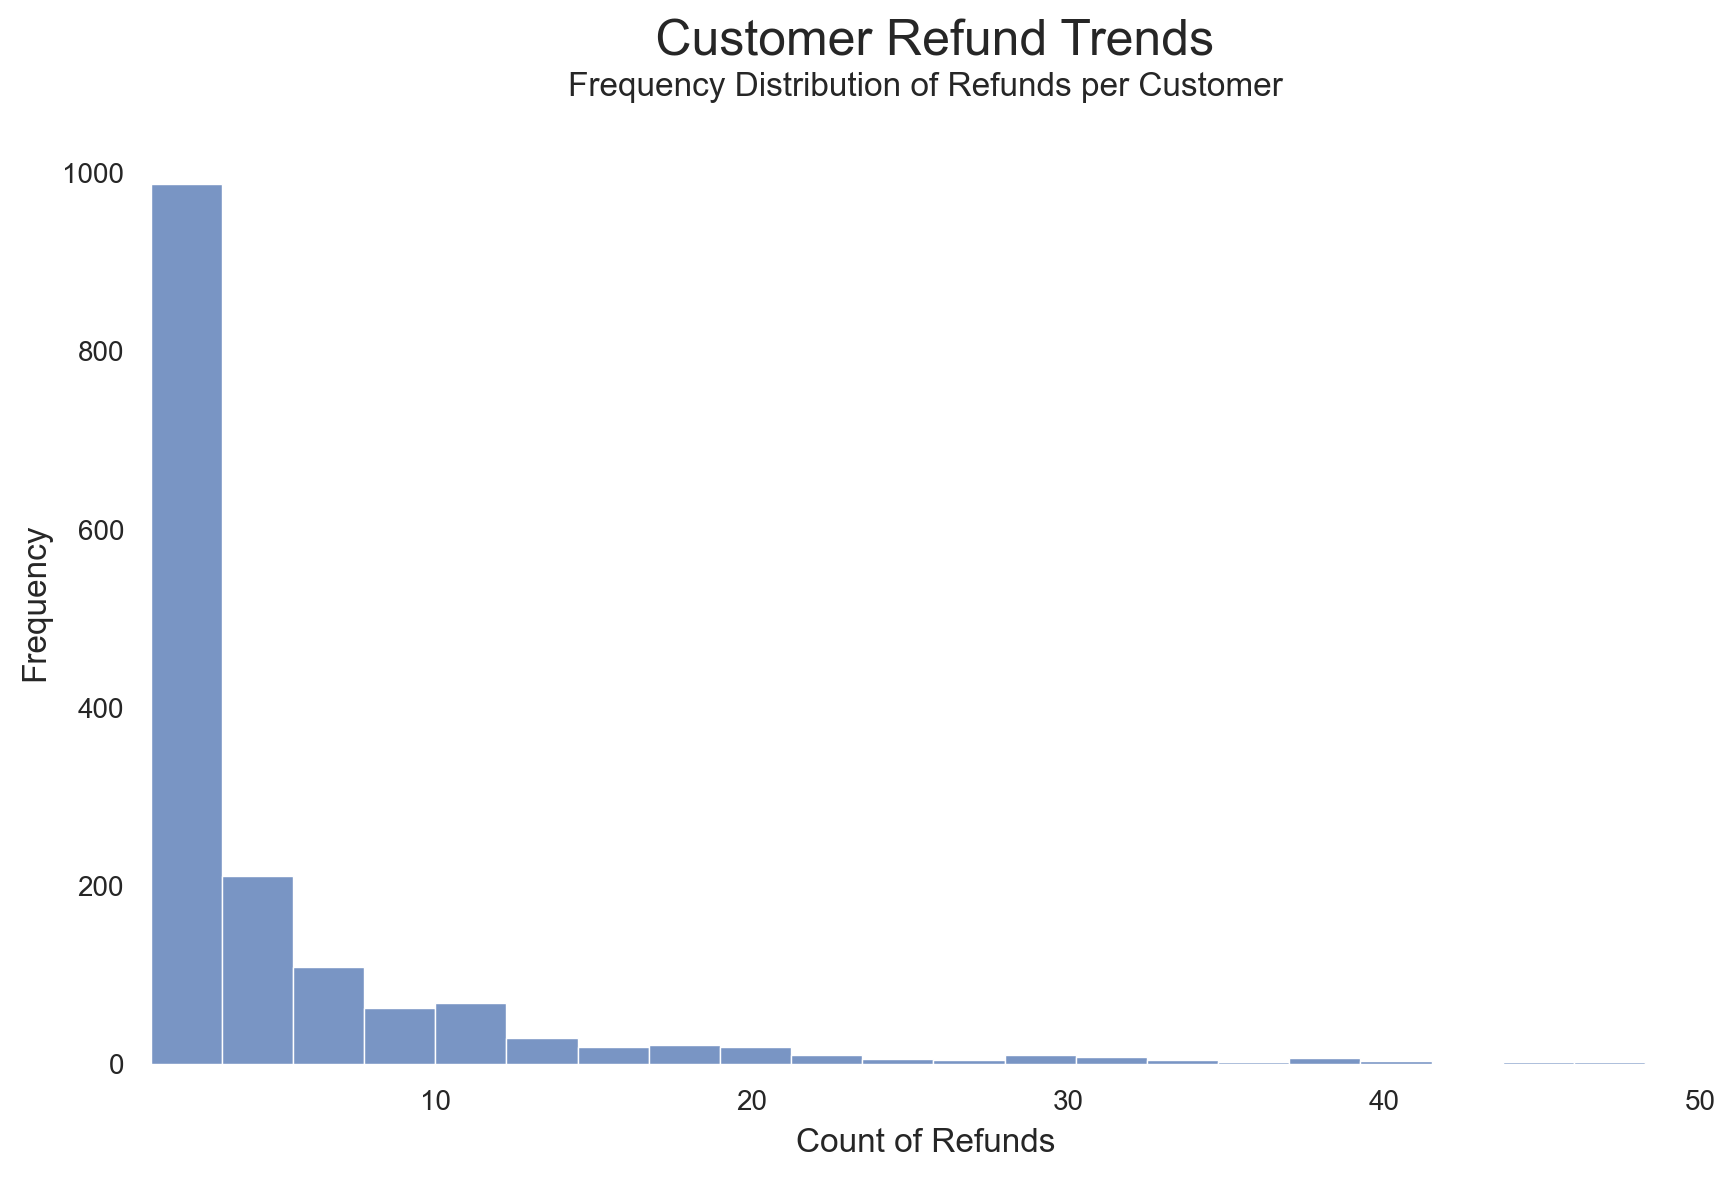

In [410]:
# Filter the DataFrame for transactions that are returns
return_data = data[data['is_return'] == 1]

# Group by 'InvoiceNo' and count the number of rows (i.e., the number of items) for each invoice
grouped_return_data = return_data.groupby('CustomerID').size().reset_index(name='Count')

# Set style to white for minimalism
sns.set(style="white")

# Create a minimal and aesthetically pleasing histogram
plt.figure(figsize=(10, 6))

# Plotting the distribution of counts of refunds per InvoiceNo
sns.histplot(grouped_return_data['Count'], kde=False, bins=100)
plt.xlim(1, 50)  # Change the range according to your specific data


# Title and labels with custom font
custom_font = "Arial"  # Change this to the font you prefer

plt.suptitle("     Customer Refund Trends", fontsize=18)
plt.title("Frequency Distribution of Refunds per Customer", fontsize=12,  pad=16)


plt.xlabel("Count of Refunds", fontsize=12, fontname=custom_font)
plt.ylabel("Frequency", fontsize=12, fontname=custom_font)

# Removing spines for a cleaner look
sns.despine(left=True, bottom=True)

# Change tick labels font
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontname(custom_font)
    label.set_fontsize(10)

plt.show()

In [411]:
data[data['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom,0
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom,0


Items with a Unit Price below 0 are debts that appear to have been removed from wholesale funders. These have been removed.

In [412]:
# There are only two transactions where the Unit Price is below 0.
data[data['UnitPrice'] < 0].head()

# Revove rows where UnitPrice is below 0
data = data[data['UnitPrice'] > 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom,0
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom,0


We're eventually going to be doing analysis at a customer level, so items without a CustomerID are removed.

In [413]:
# Drop Rows with no Customer ID
data = data[data['CustomerID'].notna()]

It appears that there are some Stock Codes that have multiple items for Description. Upon Closer Investigation, these represent variants of a given product (such as diffferent color).

In [414]:
# Group by StockCode and count unique descriptions
unique_counts = data.groupby("StockCode")["Description"].nunique()

# Filter for duplicate stock codes
duplicate_stockcodes = unique_counts[unique_counts > 1]

# Print the duplicate stock codes and their counts
print(duplicate_stockcodes)

# # Only Show StockCodes that have more than 1 unique description
data[data['StockCode'].isin(duplicate_stockcodes.index)].sort_values("StockCode").tail(5)

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: Description, Length: 213, dtype: int64


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return
386649,570241,90014B,GOLD M.O.P. ORBIT NECKLACE,1,10/9/2011 15:24,2.95,14801.0,United Kingdom,0
419842,572861,90014B,GOLD M.O.P. ORBIT NECKLACE,1,10/26/2011 12:46,2.95,14102.0,United Kingdom,0
142063,548545,90014C,SILVER/BLACK ORBIT NECKLACE,1,3/31/2011 19:12,9.95,13118.0,United Kingdom,0
504721,578993,90014C,SILVER AND BLACK ORBIT NECKLACE,1,11/27/2011 15:38,2.95,15987.0,United Kingdom,0
305558,563698,90014C,SILVER/BLACK ORBIT NECKLACE,2,8/18/2011 13:46,9.95,14667.0,United Kingdom,0


Changing InvoiceDate to datetime datatype + Creating more Date Features

In [415]:
# Adding More Date Features
data['year'] = pd.DatetimeIndex(data['InvoiceDate']).year
data['month'] = pd.DatetimeIndex(data['InvoiceDate']).month

# Adding a Quarter Column Based on Month
data['quarter'] = data['month'].apply(lambda x: 1 if x <= 3 else (2 if x <= 6 else (3 if x <= 9 else 4)))

Changing CustomerID to Object

In [416]:
# Change CustomerID dtype to object
data['CustomerID'] = data['CustomerID'].astype('object')

There were 5261 duplicate transactions. After conducting this step, there are now 401,568 transactions.

In [417]:
# Identify duplicate entries based on InvoiceNo, Description, CustomerID, and InvoiceDate
duplicates = data.duplicated()

# Remove duplicate entries and keep the first occurrence
data = data.drop_duplicates()

##### Handling Outliers

Quantity

For quantity there appear to be two extreme outliers, that reflect an item being ordered and then not ordered. It looks like someone might have added an extra zero on their order and then asked for a refund. They have been removed.

<Figure size 1400x200 with 0 Axes>

<Axes: xlabel='Quantity'>

Text(0.5, 1.0, 'Distribution of Quantity')

Text(0.5, 0, 'Values')

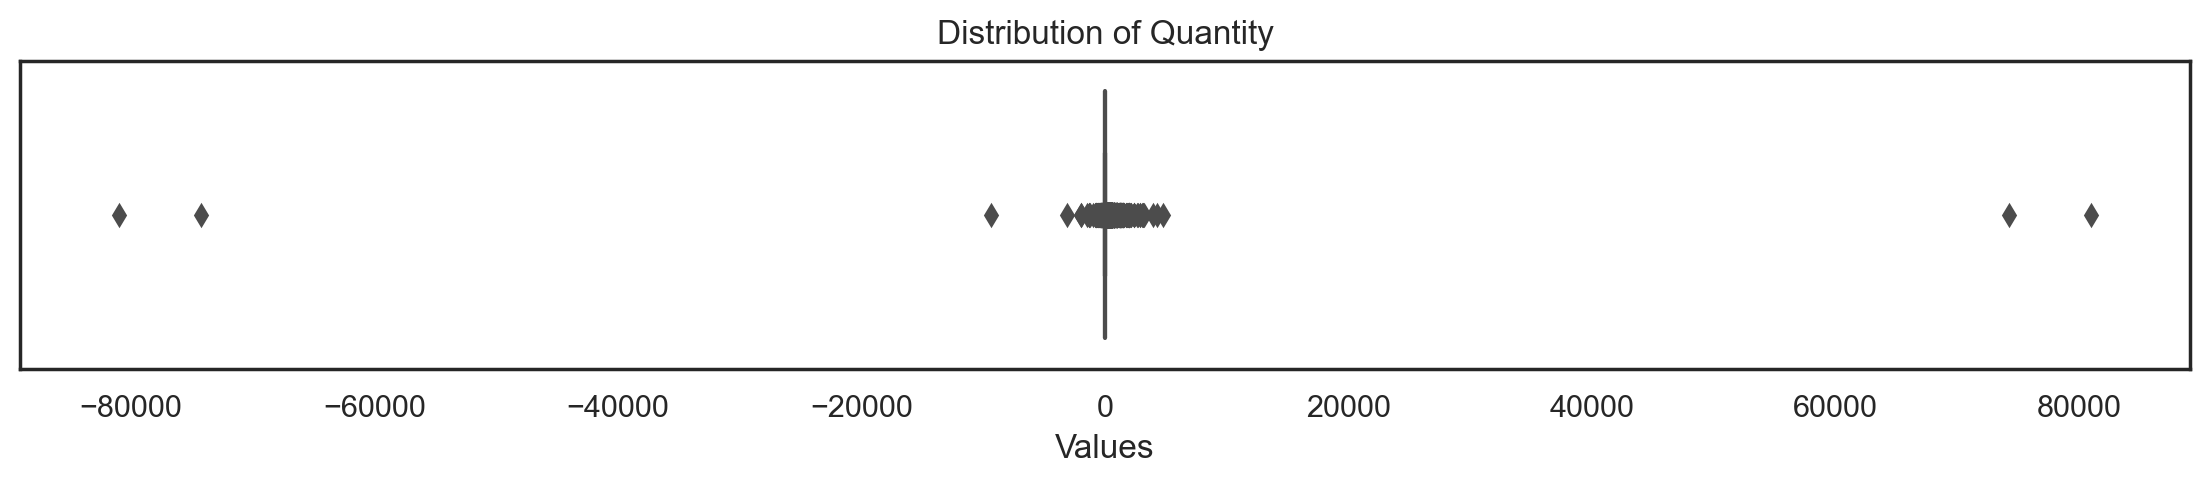

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,0,2011,1,1
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,0,2011,12,4


In [418]:
plt.figure(figsize=(14, 2))

sns.boxplot(x='Quantity', data=data)

# Optional: Set the title and labels for the plot
plt.title('Distribution of {}'.format('Quantity'))
plt.xlabel('Values')

# Display the plot and have height be 3 inches and width be 6 inches
plt.show()

data[data['Quantity'] > 8000]

# Removing Extreme Outliers for Quantity
data = data[data['Quantity'] < 8000]
data = data[data['Quantity'] > -8000]

After examining the Distribution for Unit Price, it is evident that there are a few extreme outliers. These outliers can be categorized based on their prices into three main groups:
- 'Manual' items (which could include refunds or unique items),
- Shipping Costs (such as 'Postage' or 'DOTCOM Postage'),
- CRUK Commission (which represents a Cancer charity).<br>

In order to maintain data integrity and improve the accuracy of our analysis, these extreme outliers have been removed.

<Figure size 1400x200 with 0 Axes>

<Axes: xlabel='UnitPrice'>

Text(0.5, 1.0, 'Distribution of UnitPrice')

Text(0.5, 0, 'Values')

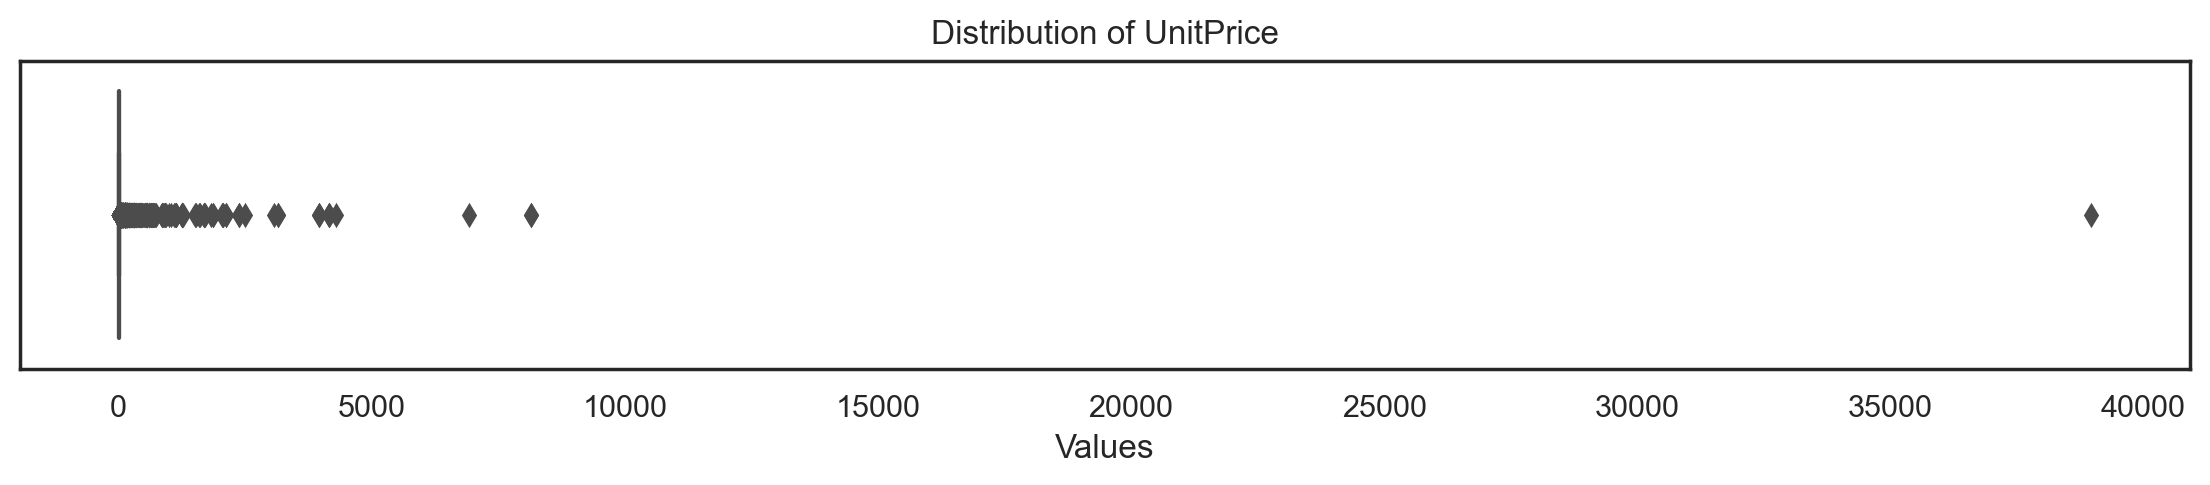

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
45622,C540271,M,Manual,-1,1/6/2011 11:51,1126.00,12503.0,Spain,1,2011,1,1
73446,C542348,M,Manual,-1,1/27/2011 12:09,1715.85,12539.0,Spain,1,2011,1,1
88210,C543789,M,Manual,-1,2/11/2011 17:10,856.48,17450.0,United Kingdom,1,2011,2,1
117052,C546325,M,Manual,-1,3/11/2011 10:15,1687.17,14911.0,EIRE,1,2011,3,1
117053,C546327,M,Manual,-1,3/11/2011 10:18,1687.17,14911.0,EIRE,1,2011,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
494745,C578269,CRUK,CRUK Commission,-1,11/23/2011 13:39,849.93,14096.0,United Kingdom,1,2011,11,4
508459,579196,DOT,DOTCOM POSTAGE,1,11/28/2011 15:54,1526.76,14096.0,United Kingdom,0,2011,11,4
508561,C579195,CRUK,CRUK Commission,-1,11/28/2011 15:54,987.14,14096.0,United Kingdom,1,2011,11,4
528082,580727,DOT,DOTCOM POSTAGE,1,12/5/2011 17:17,1599.26,14096.0,United Kingdom,0,2011,12,4


In [419]:
# Create a Box Plot for Unit Price
plt.figure(figsize=(14, 2))

sns.boxplot(x='UnitPrice', data=data)

# Optional: Set the title and labels for the plot
plt.title('Distribution of {}'.format('UnitPrice'))
plt.xlabel('Values')

# Display the plot and have height be 3 inches and width be 6 inches
plt.show();

# Show only UnitPrice Values above 4000
data[data['UnitPrice'] > 400]

# Remove all values where the Description is Postage or Manual or Dotcom Postage
data = data[data['Description'] != 'POSTAGE']
data = data[data['Description'] != 'Postage']
data = data[data['Description'] != 'Manual']
data = data[data['Description'].str.lower() != 'dotcom postage']

# remove all rows that contain Cruck Commision in Description
data = data[~data['Description'].str.contains('CRUK Commission')]

<Figure size 1400x200 with 0 Axes>

<Axes: xlabel='UnitPrice'>

Text(0.5, 1.0, 'Distribution of UnitPrice')

Text(0.5, 0, 'Values')

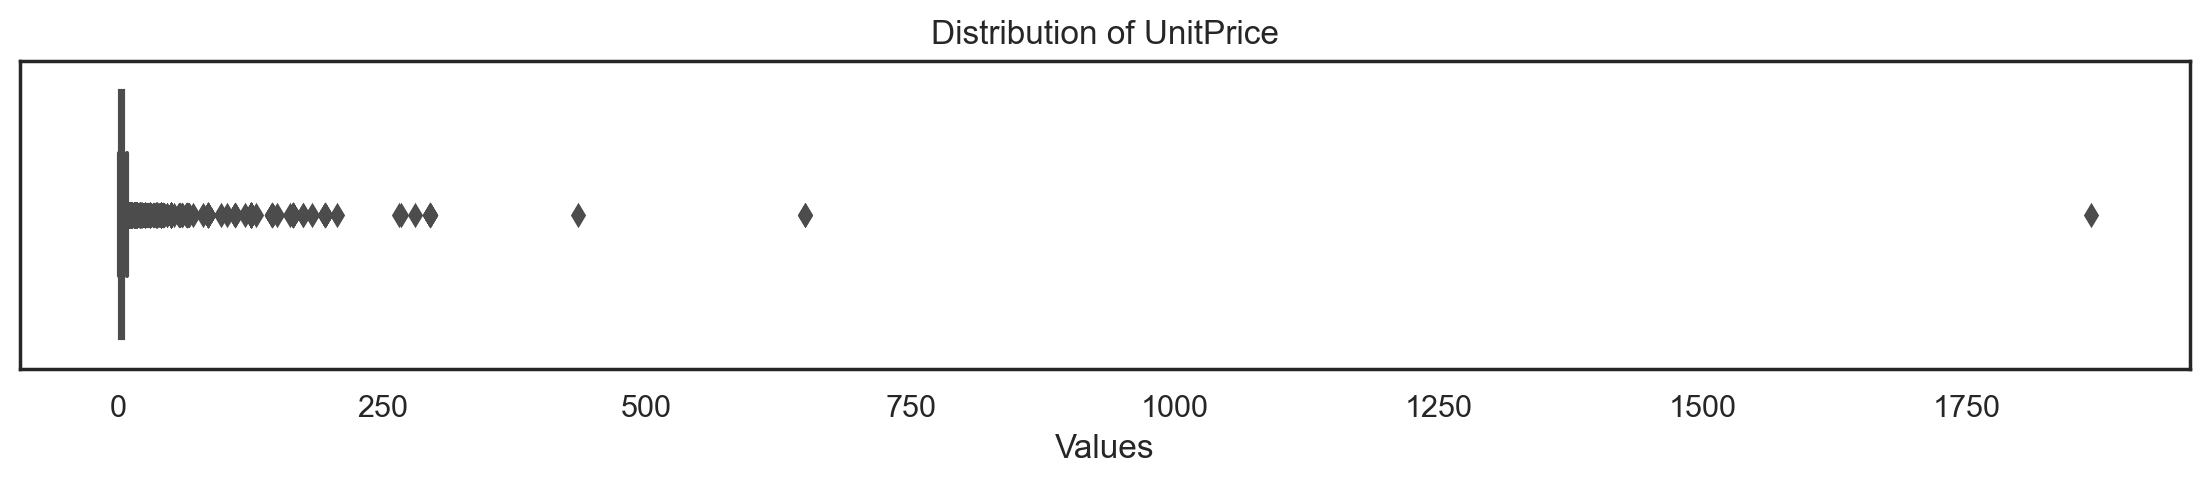

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
150591,C549452,D,Discount,-1,4/8/2011 14:17,1867.86,17940.0,United Kingdom,1,2011,4,2
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,6/10/2011 15:33,649.50,15098.0,United Kingdom,0,2011,6,2
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,6/10/2011 15:28,649.50,15098.0,United Kingdom,0,2011,6,2
300951,C563225,D,Discount,-1,8/14/2011 14:35,434.51,14911.0,EIRE,1,2011,8,3
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,3/14/2011 11:38,295.00,13452.0,United Kingdom,0,2011,3,1
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,5/26/2011 16:25,295.00,13015.0,United Kingdom,0,2011,5,2
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,4/28/2011 12:22,295.00,14973.0,United Kingdom,0,2011,4,2
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,3/25/2011 14:19,295.00,13452.0,United Kingdom,0,2011,3,1
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,12/2/2010 18:06,295.00,13145.0,United Kingdom,0,2010,12,4
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2/4/2011 15:32,295.00,14842.0,United Kingdom,0,2011,2,1


In [420]:
# Create a Box Plot for Unit Price
plt.figure(figsize=(14, 2))
sns.boxplot(x='UnitPrice', data=data)

# Optional: Set the title and labels for the plot
plt.title('Distribution of {}'.format('UnitPrice'))
plt.xlabel('Values')

# Display the plot and have height be 3 inches and width be 6 inches
plt.show()

# Show Items with Unit Price above 250 and sort by Unit Price
data[data['UnitPrice'] > 250].sort_values('UnitPrice', ascending=False)

In [421]:
# Show Invoice C537597
data[data['InvoiceNo'] == 'C537597']

# Show Invoice Date 12/7/2010 12:34	
data[data['InvoiceDate'] == '12/7/2010 12:34']

# Show CustomerID 15498.0 & Unit Price 281.0
data[(data['CustomerID'] == 15498.0) & (data['UnitPrice'] == 281.0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
14498,C537597,D,Discount,-1,12/7/2010 12:34,281.0,15498.0,United Kingdom,1,2010,12,4


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
14498,C537597,D,Discount,-1,12/7/2010 12:34,281.0,15498.0,United Kingdom,1,2010,12,4


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
14498,C537597,D,Discount,-1,12/7/2010 12:34,281.0,15498.0,United Kingdom,1,2010,12,4


One area where potential data entry errors may exist is when the item Description includes a specific item quantity, which is also listed separately in the dataset. This situation could be a result of incorrect data entry by employees or a lack of standardized procedures for recording item quantities.

To address this issue, one potential solution, although not without limitations, is to compare the listed quantity with the corresponding number mentioned in the Description column. This comparison was performed selectively, focusing on items with more extensive descriptions, as it is more likely that such information could be inaccurate for items with lower unit prices or quantities.

After conducting a thorough analysis of several rows (only 5 shown here) using this approach, it remains challenging to determine conclusively which entries were entered incorrectly. Since the revenue generated from these sales is relatively low and represents only a small portion of the overall dataset, the decision was made to retain these entries.

In [422]:
# include rows where the value in the 'Quantity' column is above 30 and is found somewhere in the 'Description' column for that given row
data[data.apply(lambda row: str(row['Quantity']) in row['Description'] and row['Quantity'] > 30, axis=1)].head()

# Remove Rows where PICNIC BASKET WICKER 60 PIECES is in the Description
data = data[data['Description'] != 'PICNIC BASKET WICKER 60 PIECES']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter
34083,539318,84992,72 SWEETHEART FAIRY CAKE CASES,72,12/16/2010 19:09,0.55,12348.0,Finland,0,2010,12,4
34093,539318,21211,SET OF 72 SKULL PAPER DOILIES,72,12/16/2010 19:09,1.45,12348.0,Finland,0,2010,12,4
54271,540907,21972,SET OF 36 DINOSAUR PAPER DOILIES,36,1/12/2011 11:52,1.45,13488.0,United Kingdom,0,2011,1,1
54272,540907,22949,36 DOILIES DOLLY GIRL,36,1/12/2011 11:52,1.45,13488.0,United Kingdom,0,2011,1,1
61848,541488,21212,PACK OF 72 RETROSPOT CAKE CASES,72,1/18/2011 13:34,0.42,15061.0,United Kingdom,0,2011,1,1


## 3.3. Data Transformations

In [423]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399875 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    399875 non-null  object 
 1   StockCode    399875 non-null  object 
 2   Description  399875 non-null  object 
 3   Quantity     399875 non-null  int64  
 4   InvoiceDate  399875 non-null  object 
 5   UnitPrice    399875 non-null  float64
 6   CustomerID   399875 non-null  object 
 7   Country      399875 non-null  object 
 8   is_return    399875 non-null  int64  
 9   year         399875 non-null  int64  
 10  month        399875 non-null  int64  
 11  quarter      399875 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 39.7+ MB


##### Creating Derived Columns

##### Create a Column for Continent (Categorical)

In [424]:
# Maps Country to Continents and Creates a Column for Continent... Worth XPementing with instead of Country
country_to_continent = {
    'United Kingdom': 'Europe',
    'France': 'Europe',
    'Australia': 'Oceania',
    'Belgium': 'Europe',
    'Netherlands': 'Europe',
    'EIRE': 'Europe',
    'Bahrain': 'Middle East',
    'Israel': 'Asia',
    'Hong Kong': 'Asia',
    'Unspecified': 'Unknown',
    'Switzerland': 'Europe',
    'Portugal': 'Europe',
    'Germany': 'Europe',
    'Norway': 'Europe',
    'Spain': 'Europe',
    'Poland': 'Europe',
    'Italy': 'Europe',
    'Lithuania': 'Europe',
    'Japan': 'Asia',
    'Iceland': 'Europe',
    'Channel Islands': 'Europe',
    'Denmark': 'Europe',
    'Austria': 'Europe',
    'Cyprus': 'Asia',
    'Sweden': 'Europe',
    'Finland': 'Europe',
    'Greece': 'Europe',
    'Singapore': 'Asia',
    'Lebanon': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Saudi Arabia': 'Middle East',
    'Czech Republic': 'Europe',
    'Canada': 'North America',
    'Brazil': 'South America',
    'USA': 'North America',
    'European Community': 'Europe',
    'Malta': 'Europe',
    'RSA': 'Africa'
}

# Apply the mapping to the 'Country' column and store the result in a new column called 'Continent'
data['Continent'] = data['Country'].map(country_to_continent)

# Make Continent a Category
data['Continent'] = data['Continent'].astype('category')

##### Creating a Column for Total Invoices Per Customer

In [425]:
# # Group the data by CustomerID and calculate the total count of invoices for each customer
# invoices_per_customer = data.groupby('CustomerID')['InvoiceNo'].nunique()

# # Merge the resulting Series with the original data DataFrame based on CustomerID
# data = data.merge(invoices_per_customer.rename('TotalInvoices'), on='CustomerID')

##### Creating a Column for Colors

In [426]:
# Define a list of colors to search for
colors = ['Cream','Amaranth', 'Amber', 'Apricot', 'Aquamarine', 'Azure', 'Beige', 'Bistre', 'Black', 'Blue', 'Blush', 'Bronze', 'Brown', 'Burgundy', 'Byzantium', 'Carmine', 'Cerise', 'Cerulean', 'Champagne', 'Chartreuse', 'Chocolate', 'Cobalt', 'Coffee', 'Copper', 'Coral', 'Crimson', 'Cyan', 'Desert sand', 'Electric blue', 'Emerald', 'Erin', 'Gold', 'Gray', 'Green', 'Harlequin', 'Indigo', 'Ivory', 'Jade', 'Jungle green', 'Lavender', 'Lemon', 'Lilac', 'Lime', 'Magenta', 'Maroon', 'Mauve', 'Navy blue', 'Ocher', 'Olive', 'Orange', 'Orchid', 'Peach', 'Pear', 'Periwinkle', 'Persian blue', 'Pink', 'Plum', 'Powder blue', 'Purple', 'Raspberry', 'Red', 'Rose', 'Ruby', 'Salmon', 'Sangria', 'Sapphire', 'Scarlet', 'Silver', 'Slate gray', 'Spring bud', 'Spring green', 'Tan', 'Taupe', 'Teal', 'Turquoise', 'Ultramarine', 'Violet', 'Viridian', 'White', 'Wine', 'Yellow', 'Zinnwaldite']

# Convert to lowercase and capitalize first letter of each word
data['Description'] = data['Description'].str.lower().str.title()

# Iterate over each row in the Description column
item_colors = []
for desc in data['Description']:
    # Check if desc is a string
    if isinstance(desc, str):
        # Check if any of the colors are present in the text
        found_color = None
        for color in colors:
            if color in desc:
                found_color = color
                break
        # Assign the color to the item_color column
        item_colors.append(found_color)
    else:
        # If desc is not a string, assign None to the item_color column
        item_colors.append(None)

# Add the item_color column to the dataset
data['item_color'] = item_colors

In [427]:
# if the Description column contains a word in a list called colors, remove that word from the given row in the Description column
data['Description'] = data['Description'].str.replace('|'.join(colors), '') 

In [428]:
materials = ['Wood', 'Metal', 'Glass', 'Plastic', 'Stone', 'Fabric', 'Leather', 'Ceramic', 'Porcelain', 'Paper', 'Cardboard', 'Bamboo', 'Rattan', 'Wicker', 'Clay', 'Concrete', 'Marble', 'Granite', 'Brick', 'Sandstone', 'Limestone', 'Bronze', 'Brass', 'Copper', 'Silver', 'Gold', 'Pewter', 'Aluminum', 'Steel', 'Iron', 'Titanium', 'Carbon fiber', 'Fiberglass']

# Iterate over each row in the Description column
item_materials = []
for desc in data['Description']:
    # Check if desc is a string
    if isinstance(desc, str):
        # Check if any of the materials are present in the text
        found_material = None
        for material in materials:
            if material in desc:
                found_material = material
                break
        # Assign the material to the item_material column
        item_materials.append(found_material)
    else:
        # If desc is not a string, assign None to the item_material column
        item_materials.append(None)

# Add the item_material column to the dataset
data['item_material'] = item_materials

In [429]:
# if the Descrption column contains a word in a list called colors, remove that word from the given row in the Description column
data['Description'] = data['Description'].str.replace('|'.join(materials), '') 

Item Color and Item Material in any NLP analysis had a higher liklihood of being found frequently, so by creating columns for them the hope is that NLP will produce more fruitful results.... then again the fact we have so many None Values might mess things up...

In [430]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material
0,536365,85123A,Hanging Heart T-Light Holder,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None
1,536365,71053,Lantern,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,White,Metal
2,536365,84406B,Cupid Hearts Coat Hanger,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,0,2010,12,4,Europe,Cream,None
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,None,None
4,536365,84029E,Woolly Hottie Heart.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,Red,None


In [431]:
# Create a new column called 'Revenue' which is the product of Quantity and UnitPrice
data['Revenue'] = data['Quantity'] * data['UnitPrice']

In [432]:
# Drop Rows Where CustomerID is 0
data = data[data['CustomerID'] != 0]

### Creating a New Table Where Each Row Represents a Unique Customer

In [433]:
# Convert InvoiceDate to datetime
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [434]:
# Find the minimum date by Customer_ID
first_purchase = data.groupby('CustomerID')['InvoiceDate'].min()

# # Merge the resulting Series with the original data DataFrame based on CustomerID
# data = data.merge(first_purchase.rename('first_purchase'), on='CustomerID')
# # Convert first_purchase column to datetime
# data['first_purchase'] = pd.to_datetime(data['first_purchase'])

# Convert first_purchase column to datetime
first_purchase = pd.to_datetime(first_purchase)

In [435]:
# Find the minimum date by Customer_ID
last_purchase = data.groupby('CustomerID')['InvoiceDate'].max()
last_purchase = pd.to_datetime(last_purchase)

# # Merge the resulting Series with the original data DataFrame based on CustomerID
# data = data.merge(last_purchase.rename('last_purchase'), on='CustomerID')

# # Convert last_purchase column to datetime
# data['last_purchase'] = pd.to_datetime(data['last_purchase'])

In [436]:
# Group the data by CustomerID and calculate sum up the Revenue column
total_revenue = data.groupby('CustomerID')['Revenue'].sum()

# Merge the resulting Series with the original data DataFrame based on CustomerID
# data = data.merge(revenue_per_customer.rename('Total_Customer_Revenue'), on='CustomerID')

In [437]:
# Merge the series for first_purchase, last_purchase, and total_revenue into a single DataFrame where CustomerID is the index and the column names are first_purchase, last_purchase, and total_revenue
customer_data = pd.concat([first_purchase, last_purchase, total_revenue], axis=1)

# Rename the columns of the customer_data DataFrame to first_purchase, last_purchase, and total_revenue
customer_data.columns = ['first_purchase', 'last_purchase', 'total_revenue']

# Get rid of index for CustomerID
customer_data.reset_index(inplace=True)

customer_data.head()

,CustomerID,first_purchase,last_purchase,total_revenue
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24
2,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,1457.55
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41


Creating Columns for Customer Lifetime + Customer Lifetime Value (CLV)

In [438]:
#Subtract last_purchase months from first_purchase months
customer_data['Customer_Lifetime'] = (customer_data['last_purchase'] - customer_data['first_purchase']) / np.timedelta64(1, 'M')

customer_data['Customer_Lifetime_Value'] = customer_data['total_revenue'] / (customer_data['last_purchase'] - customer_data['first_purchase']).dt.days


In [439]:
customer_data.head()

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596
2,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,1457.55,0.000000,inf
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40,0.000000,inf
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962


In [440]:
# Create Cohort_Group Column Based on year and month of first_purchase
customer_data['Cohort_Group'] = customer_data['first_purchase'].dt.strftime('%Y-%m')

In [441]:
customer_data

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219,2010-12
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596,2010-12
2,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,1457.55,0.000000,inf,2011-11
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40,0.000000,inf,2011-02
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962,2011-02
...,...,...,...,...,...,...,...
4356,18280.0,2011-03-07 09:52:00,2011-03-07 09:52:00,180.60,0.000000,inf,2011-03
4357,18281.0,2011-06-12 10:53:00,2011-06-12 10:53:00,80.82,0.000000,inf,2011-06
4358,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00,176.60,3.907176,1.496610,2011-08
4359,18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00,2039.58,10.970520,6.124865,2011-01


In [442]:
# Export to CSV
customer_data.to_csv('customer_records.csv', index=False)

In [443]:
customer_data.head()

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219,2010-12
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596,2010-12
2,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,1457.55,0.000000,inf,2011-11
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40,0.000000,inf,2011-02
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962,2011-02


In [444]:
# merge the customer_data with data
merged_data = data.merge(customer_data, on='CustomerID')
merged_data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group
0,536365,85123A,Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.3,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12


In [445]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Getting the integers for date parts from the `InvoiceDay` column
transaction_year, transaction_month, transaction_day = get_date_int(merged_data, 'InvoiceDate')

# Getting the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(merged_data, 'first_purchase')

#  Get the  difference in years
years_diff = transaction_year - cohort_year

# Calculate difference in months
months_diff = transaction_month - cohort_month

# To calc the difference in months from all previous values, we add "+1" at the end of the calculation. This adjustment ensures that the first month is marked as 1 instead of 0 (aka easier to interpret)

merged_data['CohortIndex'] = years_diff * 12 + months_diff  + 1 
merged_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,CohortIndex
0,536365,85123A,Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.30,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12,1
1,536365,71053,Lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,White,Metal,20.34,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12,1
2,536365,84406B,Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010,12,4,Europe,Cream,None,22.00,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12,1
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,None,None,20.34,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12,1
4,536365,84029E,Woolly Hottie Heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,Red,None,20.34,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12,1


In [446]:
# Group Data by 

In [447]:
# # Export to CSV
# merged_data.to_csv('merged_data.csv', index=False)

In [448]:
# POTENTIALLY DELETE ALL OF THIS CODE BELOW...

# grouped = merged_data.groupby(['Cohort_Group', 'month'])

# cohorts = grouped.agg({'CustomerID': pd.Series.nunique,
#                        'Description': pd.Series.nunique,
#                        'Quantity': np.sum,
#                        'Revenue': np.sum})

# #Rename cohorts columns for Customer_ID = Total Customers, Description = Total Product Types, Quantity = Total Items Sold, Revenue = Total Revenue
# cohorts.rename(columns={'CustomerID': 'Total_Customers',
#                         'Description': 'Total_Product_Types',
#                         'Quantity': 'Total_Items_Sold',
#                         'Revenue': 'Total_Revenue'}, inplace=True)

# def cohort_period(df):
# #     df['cohort_period'] = np.arange(len(df)) + 1
# #     return df

# # cohorts = cohorts.groupby(level=0).apply(cohort_period)

# # cohorts.head()

In [449]:
merged_data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,CohortIndex
0,536365,85123A,Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.3,2010-12-01 08:26:00,2011-02-10 14:38:00,5303.48,2.341184,74.696901,2010-12,1


After Doing GroupBys + Pivots on the Data, we can create different Retention Matrixes

In [450]:
#counting customer ID 
cohort_data = merged_data.groupby(['Cohort_Group','CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_data

#pivot table creation
cohort_table = cohort_data.pivot(index='Cohort_Group', columns=['CohortIndex'],values='CustomerID')
 
# changing index of the cohort table
cohort_table.index = cohort_table.index


,Cohort_Group,CohortIndex,CustomerID
0,2010-12,1,948
1,2010-12,2,361
2,2010-12,3,316
3,2010-12,4,366
4,2010-12,5,340
...,...,...,...
86,2011-10,2,92
87,2011-10,3,46
88,2011-11,1,320
89,2011-11,2,42


In [451]:
cohort_table

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
Cohort_Group,,,,,,,,,,,,,
2010-12,948.0,361.0,316.0,366.0,340.0,376.0,358.0,333.0,334.0,374.0,353.0,473.0,260.0
2011-01,418.0,100.0,119.0,102.0,137.0,126.0,110.0,107.0,130.0,145.0,155.0,63.0,NaN
2011-02,378.0,93.0,73.0,107.0,102.0,93.0,98.0,105.0,98.0,119.0,35.0,NaN,NaN
2011-03,439.0,83.0,111.0,96.0,100.0,78.0,115.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,298.0,67.0,66.0,63.0,62.0,71.0,68.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05,279.0,66.0,48.0,48.0,60.0,68.0,74.0,28.0,NaN,NaN,NaN,NaN,NaN
2011-06,235.0,49.0,43.0,64.0,58.0,78.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,186.0,40.0,38.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,167.0,41.0,41.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [452]:
import plotly.graph_objects as go
import pandas as pd
import plotly.offline as pyo

# Assuming cohort_table is the DataFrame containing the cohort analysis data

# Create the heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=cohort_table.values,
    x=cohort_table.columns,
    y=cohort_table.index,
    colorscale='plotly3',  # Set your desired color palette here
    colorbar=dict(title='Value'),
    hovertemplate='Cohort Group: %{y}<br>Cohort Period: %{x}<br>Value: %{z}<extra></extra>',
    text=cohort_table.values,
    texttemplate='%{text}',
    textfont=dict(color='white', size=10)  # Adjust the size and color of the text here
))

fig.update_layout(
    title='Cohort Analysis Heatmap',
    xaxis=dict(title='# of Periods (in Months)', dtick=1),  # Adjust the dtick parameter to show all cohort periods
    yaxis=dict(title='Cohort Group', tickmode='auto',
    # ticktext=cohort_table.index
    ),
    height=600,  # Adjust the height of the plot here
    width=800  # Adjust the width of the plot here
)

# Export the plot to an HTML file
pyo.plot(fig, filename='cohort_analysis_heatmap.html')

'cohort_analysis_heatmap.html'

In [453]:
# #creation of heatmap and visualization
# plt.figure(figsize=(21,10))
# sns.heatmap(cohort_table,annot=True,cmap='Greens', fmt='g')

In [454]:
import plotly.graph_objects as go
import numpy as np

# Assuming new_cohort_table contains the data
# #cohort for percentage analysis
new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0],axis=0)


# Calculate the percentages from the values in new_cohort_table (assuming the values are already in fractions)
percent_values = new_cohort_table.values * 100

# Set 0 values to NaN to hide them
percent_values[percent_values == 0] = np.nan

# Create the heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=percent_values,
    x=new_cohort_table.columns,
    y=new_cohort_table.index,
    colorscale='plotly3',  # Set your desired color palette here
    colorbar=dict(title='Percentage', tickvals=np.arange(0, 101, 10), tickformat='%d%'),  # Use custom tickvals and tickformat
    hovertemplate='Cohort Group: %{y}<br>Cohort Period: %{x}<br>Value: %{z:.1f}%<extra></extra>',  # Display values as percentages with one decimal place
    text=percent_values,
    texttemplate='%{text:.1f}%',  # Display the text as percentages with one decimal place
    textfont=dict(color='white', size=10)  # Adjust the size and color of the text here
))

fig.update_layout(
    title='User Retention of Monthly Cohorts',
    xaxis=dict(title='Cohort Period', dtick=1),  # Adjust the dtick parameter to show all cohort periods
    yaxis=dict(title='Cohort Group', tickmode='array', ticktext=new_cohort_table.index),
    height=600,  # Adjust the height of the plot here
    width=800  # Adjust the width of the plot here
)

pyo.plot(fig, filename='cohort_analysis_user_retention_percentage.html')

### SEABORN IMPLEMENTATION OF ABOVE...

# #cohort for percentage analysis
# new_cohort_table = cohort_table.divide(cohort_table.iloc[:,0],axis=0)
 
# #creating a percentage visualization
# plt.figure(figsize=(21,10))
# colormap=sns.color_palette("mako", as_cmap=True)
# sns.heatmap(new_cohort_table,annot=True,fmt='.0%',cmap=colormap)
 
# #show the heatmaps
# plt.show(); 



'cohort_analysis_user_retention_percentage.html'

##### Determining Item Categories
Maybe I should modify my categories based on this: https://www.rexlondon.com/all-categories

In [455]:
# Create an empty column called Item_Category in the dataframe
data['Item_Category'] = None

# If Row contains Clock in the Description Column, then Set Item_Category to Home Decor
data.loc[data['Description'].str.contains('Clock|Jumbo Shopper|Storage|Mat|Rug'), 'Item_Category'] = 'Home Decor'

# If Row contains Clock in the Description Column, then Set Item_Category to Home Decor
data.loc[data['Description'].str.contains('Light|Chalkboard|Bag|Frame'), 'Item_Category'] = 'Home Decor'

# If Row contains Clock in the Description Column, then Set Item_Category to Home Decor
data.loc[data['Description'].str.contains('Cake|Ornament|Bunting|Christmas|Party'), 'Item_Category'] = 'Party/Holiday'

# If Row contains Clock in the Description Column, then Set Item_Category to Home Decor
data.loc[data['Description'].str.contains('Kitchen|Tea|Pantry|Mug|Jam|Baking|Bowl'), 'Item_Category'] = 'Kitchenware'

# If Row contains Clock in the Description Column, then Set Item_Category to Home Decor
data.loc[data['Description'].str.contains('Postage|Ring|Trinket'), 'Item_Category'] = 'Accessories'

# If Row contains Lunch in the Description Column, then Set Item_Category to Lunchware
data.loc[data['Description'].str.contains('Lunch'), 'Item_Category'] = 'Lunchware'

# FINDING BLANK CATEGORY VALUES
# For Rows Where Item_Category is None, get a value count of Description
data[data['Item_Category'].isnull()]['Description'].value_counts()

Heart Of  Small                       990
Heart Of  Large                       827
Gardeners Kneeling Pad Keep Calm      773
Set/20  Retrospot  Napkins            748
6 Ribbons Rustic Charm                747
                                     ... 
Set 12 Colouring Pencils Doiley         1
Set 36 Colouring Pencils Doiley         1
 I Love London Mini Rucksack            1
Cherry Blossom Purse                    1
Heavens Scent Fragrance Oils Asstd      1
Name: Description, Length: 2587, dtype: int64

This is an example of a section where AI is incredibly useful. It will help generate the best Item_Categories for data.  
That being said, as it stands this is inefficient with such a large dataset.

Here is the current prompt given to AI to generate categories...

    Each row contains a transaction for the sale of an item. Transactions are classified into an Item_Category based upon the 'Description' column. The potential values are 'Home Decor', None, 'Kitchenware', 'Party/Holiday', 'Accessories' or 'Lunchware'. Based upon the 'Description', each transaction must be classified as one of potential values. In my next message I'll send a few of the transactions which need to be classified.

    Have this code act as the basis for which item classification occurs.
    # If Row contains Lunch in the Description Column, then Set Item_Category to Lunchware
    data.loc[data['Description'].str.contains('Lunch'), 'Item_Category'] = 'Lunchware'

In [456]:
# This Shows Values Where Item_Category is None
data[data['Item_Category'].isnull()]['Description'].value_counts().head()

Heart Of  Small                      990
Heart Of  Large                      827
Gardeners Kneeling Pad Keep Calm     773
Set/20  Retrospot  Napkins           748
6 Ribbons Rustic Charm               747
Name: Description, dtype: int64

In [457]:
# Example classifications for the provided items
data.loc[data['Description'].str.contains('6 Ribbons Rustic Charm'), 'Item_Category'] = 'Party/Holiday'
data.loc[data['Description'].str.contains('Hot Water Bottle Keep Calm'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Vintage Snap Cards'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Gin + Tonic Diet Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Popcorn Holder'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Doormat Keep Calm And Come In'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Clothes Pegs Retrospot Pack 24'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Heart Card Holder'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Round Snack Boxes Set Of4 land'), 'Item_Category'] = 'Kitchenware'
data.loc[data['Description'].str.contains('Plasters In Tin land Animals'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Hand Over The Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Spot Drawer Knob'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Plasters In Tin Spaceboy'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Hand Warmer Owl Design'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Vintage Spot Beaker'), 'Item_Category'] = 'Kitchenware'
data.loc[data['Description'].str.contains('Gumball Coat Rack'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Doormat Retrospot'), 'Item_Category'] = 'Home Decor'

# Example classifications for the remaining items
data.loc[data['Description'].str.contains('Heart Of  Small'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Heart Of  Large'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Gardeners Kneeling Pad Keep Calm'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Set/20  Retrospot  Napkins'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Hot Water Bottle'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Please One Person  Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Edwardian Parasol'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Stripe  Drawer Knob'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Home Building Block Word'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Scottie Dog Hot Water Bottle'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Gin + Tonic Diet  Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Cook With   Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Board Ant  Finish'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Small  Heart Of'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Hand Over The    Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Spot   Drawer Knob'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Doormat  Retrospot'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Spot  Drawer Knob'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Gingerbread Man Cookie Cutter'), 'Item_Category'] = 'Kitchenware'
data.loc[data['Description'].str.contains('Drawer Knob Crackle Glaze'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Harmonica In Box'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Giant Garden Thermometer'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Love Building Block Word'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Small  Babushka Notebook'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Retrospot Heart Hot Water Bottle'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Drawer Knob Acrylic Edwardian'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Childrens Cutlery Polkadot'), 'Item_Category'] = 'Kitchenware'
data.loc[data['Description'].str.contains('Doormat New England'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Grey Heart Hot Water Bottle'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Set Of 3 Heart Cookie Cutters'), 'Item_Category'] = 'Kitchenware'

data.loc[data['Description'].str.contains('Gin + Tonic Diet  Sign'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Plasters In Tin Circus Parade'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Traditional Knitting Nancy'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Doormat Union Flag'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Large  Heart Of'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('2 Drawer Cabinet  Finish'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Set Of 3 Butterfly Cookie Cutters'), 'Item_Category'] = 'Kitchenware'
data.loc[data['Description'].str.contains('Vintage Heads And Tails Card Game'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Plasters In Tin Vintage Paisley'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Zinc  Heart Decoration'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Hand Warmer Scotty Dog Design'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Doormat Hearts'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Hand Warmer Bird Design'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('World War 2 Gliders Asstd Designs'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Feltcraft 6 Flower Friends'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('en Box Of Dominoes'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Round Snack Boxes Set Of 4 Fruits'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Plasters In Tin Strongman'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Hand Warmer Union Jack'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Bread Bin Diner Style'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Childrens Apron Spaceboy Design'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Sweetheart Mini Chest'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Feltcraft Butterfly Hearts'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Plasters In Tin Skulls'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Recipe Box Retrospot'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Chain Kit Retrospot'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Enamel Flower Jug'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Travel Card Wallet Keep Calm'), 'Item_Category'] = 'Accessories'
data.loc[data['Description'].str.contains('Feltcraft Cushion Owl'), 'Item_Category'] = 'Home Decor'
data.loc[data['Description'].str.contains('Set Of 20 Kids Cookie Cutters'), 'Item_Category'] = 'Kitchenware'

In [458]:
# # Create Columns for the percentage contribution of each revenue category to the total revenue for each individual customer

# customer_data['Accessories_Percentage'] = (customer_data['Accessories_Revenue'] / customer_data['Total_Customer_Revenue']) * 100
# customer_data['Home_Decor_Percentage'] = (customer_data['Home_Decor_Revenue'] / customer_data['Total_Customer_Revenue']) * 100
# customer_data['Kitchenware_Percentage'] = (customer_data['Kitchenware_Revenue'] / customer_data['Total_Customer_Revenue']) * 100
# customer_data['Lunchware_Percentage'] = (customer_data['Lunchware_Revenue'] / customer_data['Total_Customer_Revenue']) * 100
# customer_data['Party/Holiday_Percentage'] = (customer_data['Party/Holiday_Revenue'] / customer_data['Total_Customer_Revenue']) * 100
# customer_data['Other_Percentage'] = (customer_data['Other_Revenue'] / customer_data['Total_Customer_Revenue']) * 100


Here we can see that over 50% of the items in the store have been processed into different categories.

In [459]:
data['Item_Category'].value_counts(normalize=True, dropna=False) * 100

None             47.160488
Home Decor       22.903407
Party/Holiday    11.374805
Kitchenware      11.191747
Lunchware         3.746171
Accessories       3.623382
Name: Item_Category, dtype: float64

Australia seems to be an emerging market for the company.

In [460]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,Item_Category
0,536365,85123A,Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.30,Home Decor
1,536365,71053,Lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,White,Metal,20.34,None
2,536365,84406B,Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010,12,4,Europe,Cream,None,22.00,None
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,None,None,20.34,Home Decor
4,536365,84029E,Woolly Hottie Heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,Red,None,20.34,None


In [461]:
# Group By InvoiceDate at a Date Level and Country
df_daily = data.groupby([data['InvoiceDate'].dt.date]).sum()

In [462]:
df_daily

,Quantity,UnitPrice,is_return,year,month,quarter,Revenue
InvoiceDate,,,,,,,
2010-12-01,23924,6045.05,26,3857190,23028,7676,45760.06
2010-12-02,30149,6511.54,43,4022010,24012,8004,45919.27
2010-12-03,11490,3485.15,14,2190900,13080,4360,22207.68
2010-12-05,16106,7538.62,16,5238060,31272,10424,30514.32
2010-12-06,15898,5766.52,28,3857190,23028,7676,30161.75
...,...,...,...,...,...,...,...
2011-12-05,37407,8746.22,23,6730817,40164,13388,55382.24
2011-12-06,26613,6138.38,98,5208490,31080,10360,42984.87
2011-12-07,40884,5221.27,27,4333705,25860,8620,68362.61


In [463]:
# Drop all columns besides Sales
df_daily = df_daily.drop(columns=['year','month','quarter', 'Quantity', 'UnitPrice'])

In [464]:
# reset index
df_daily.reset_index(inplace=True)

In [465]:
df_daily.to_csv('daily_sales.csv', index=False)

<Axes: >

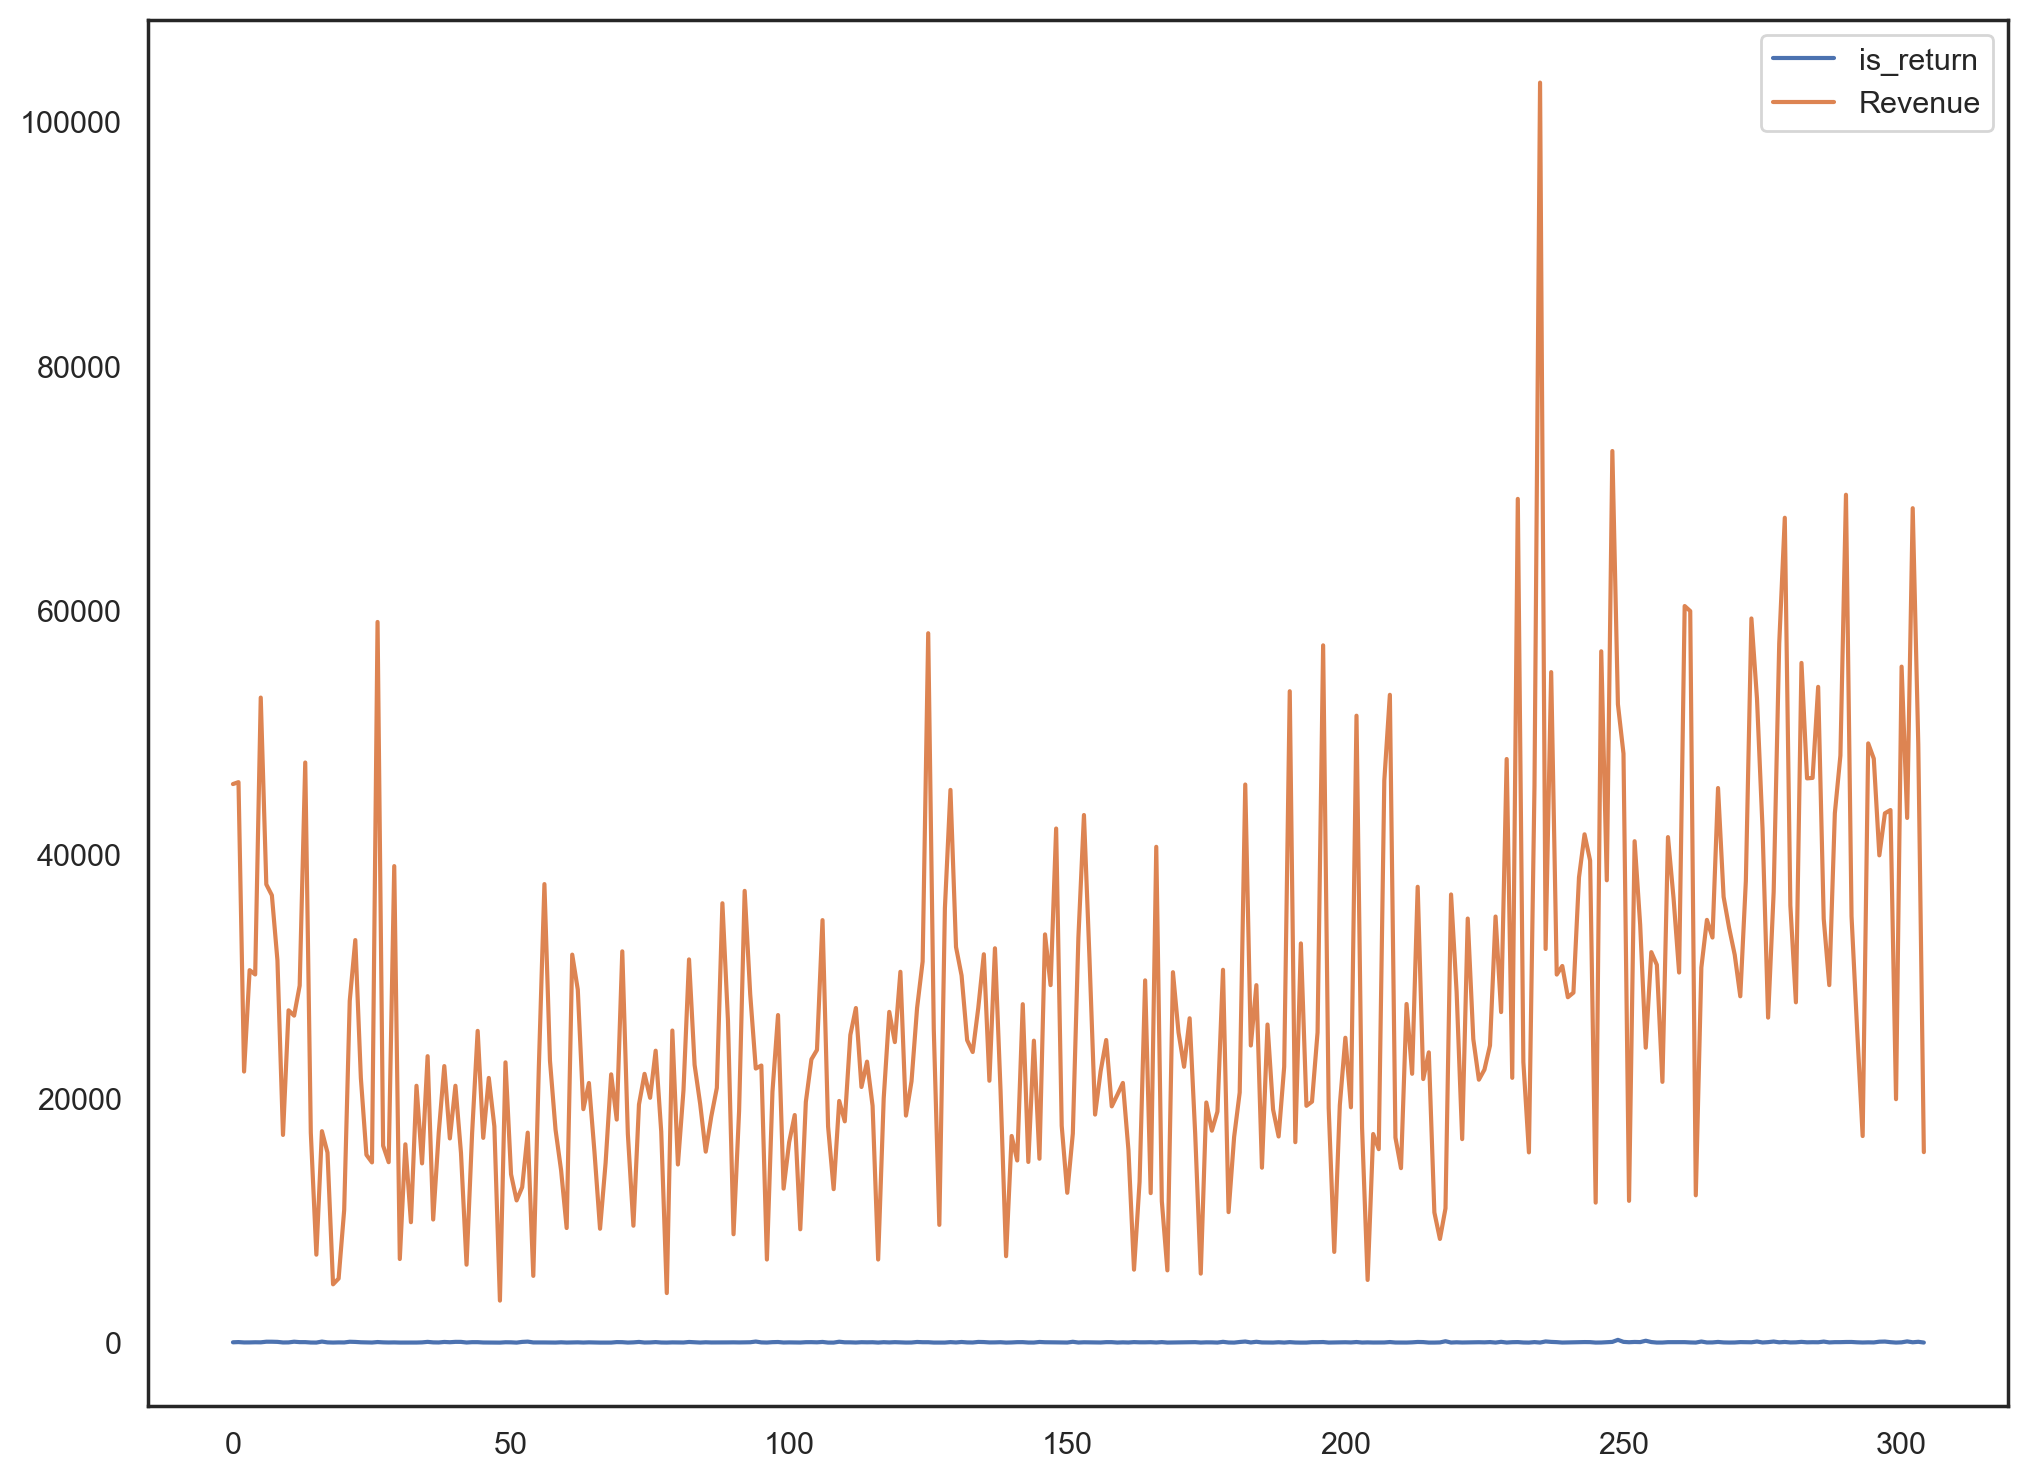

In [466]:
df_daily.plot()

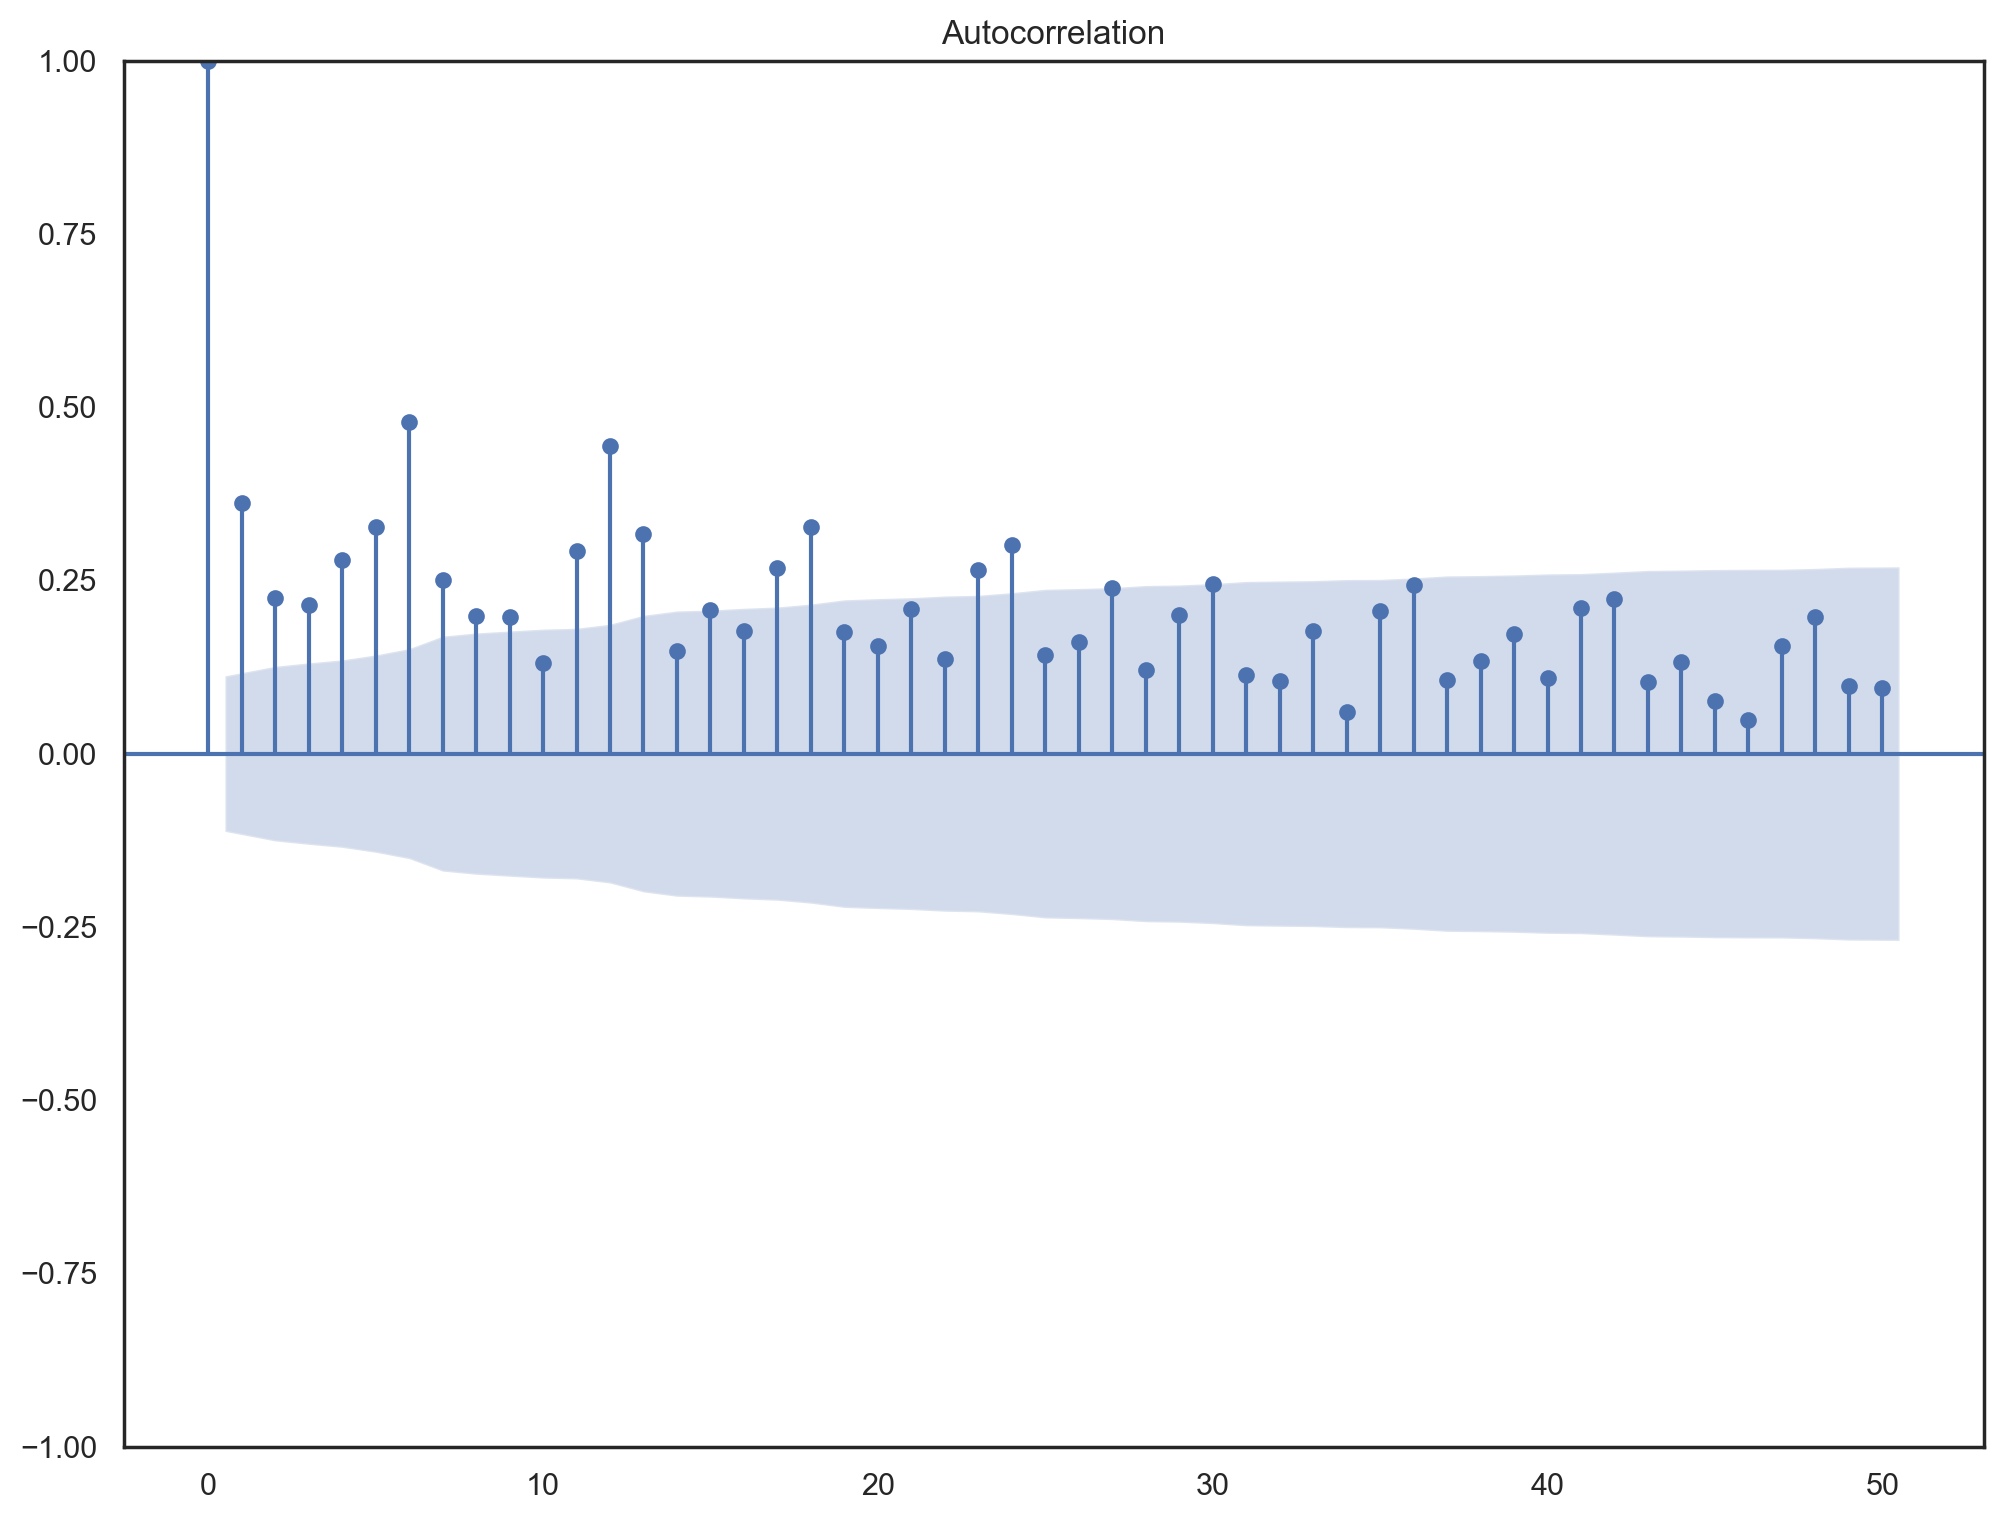

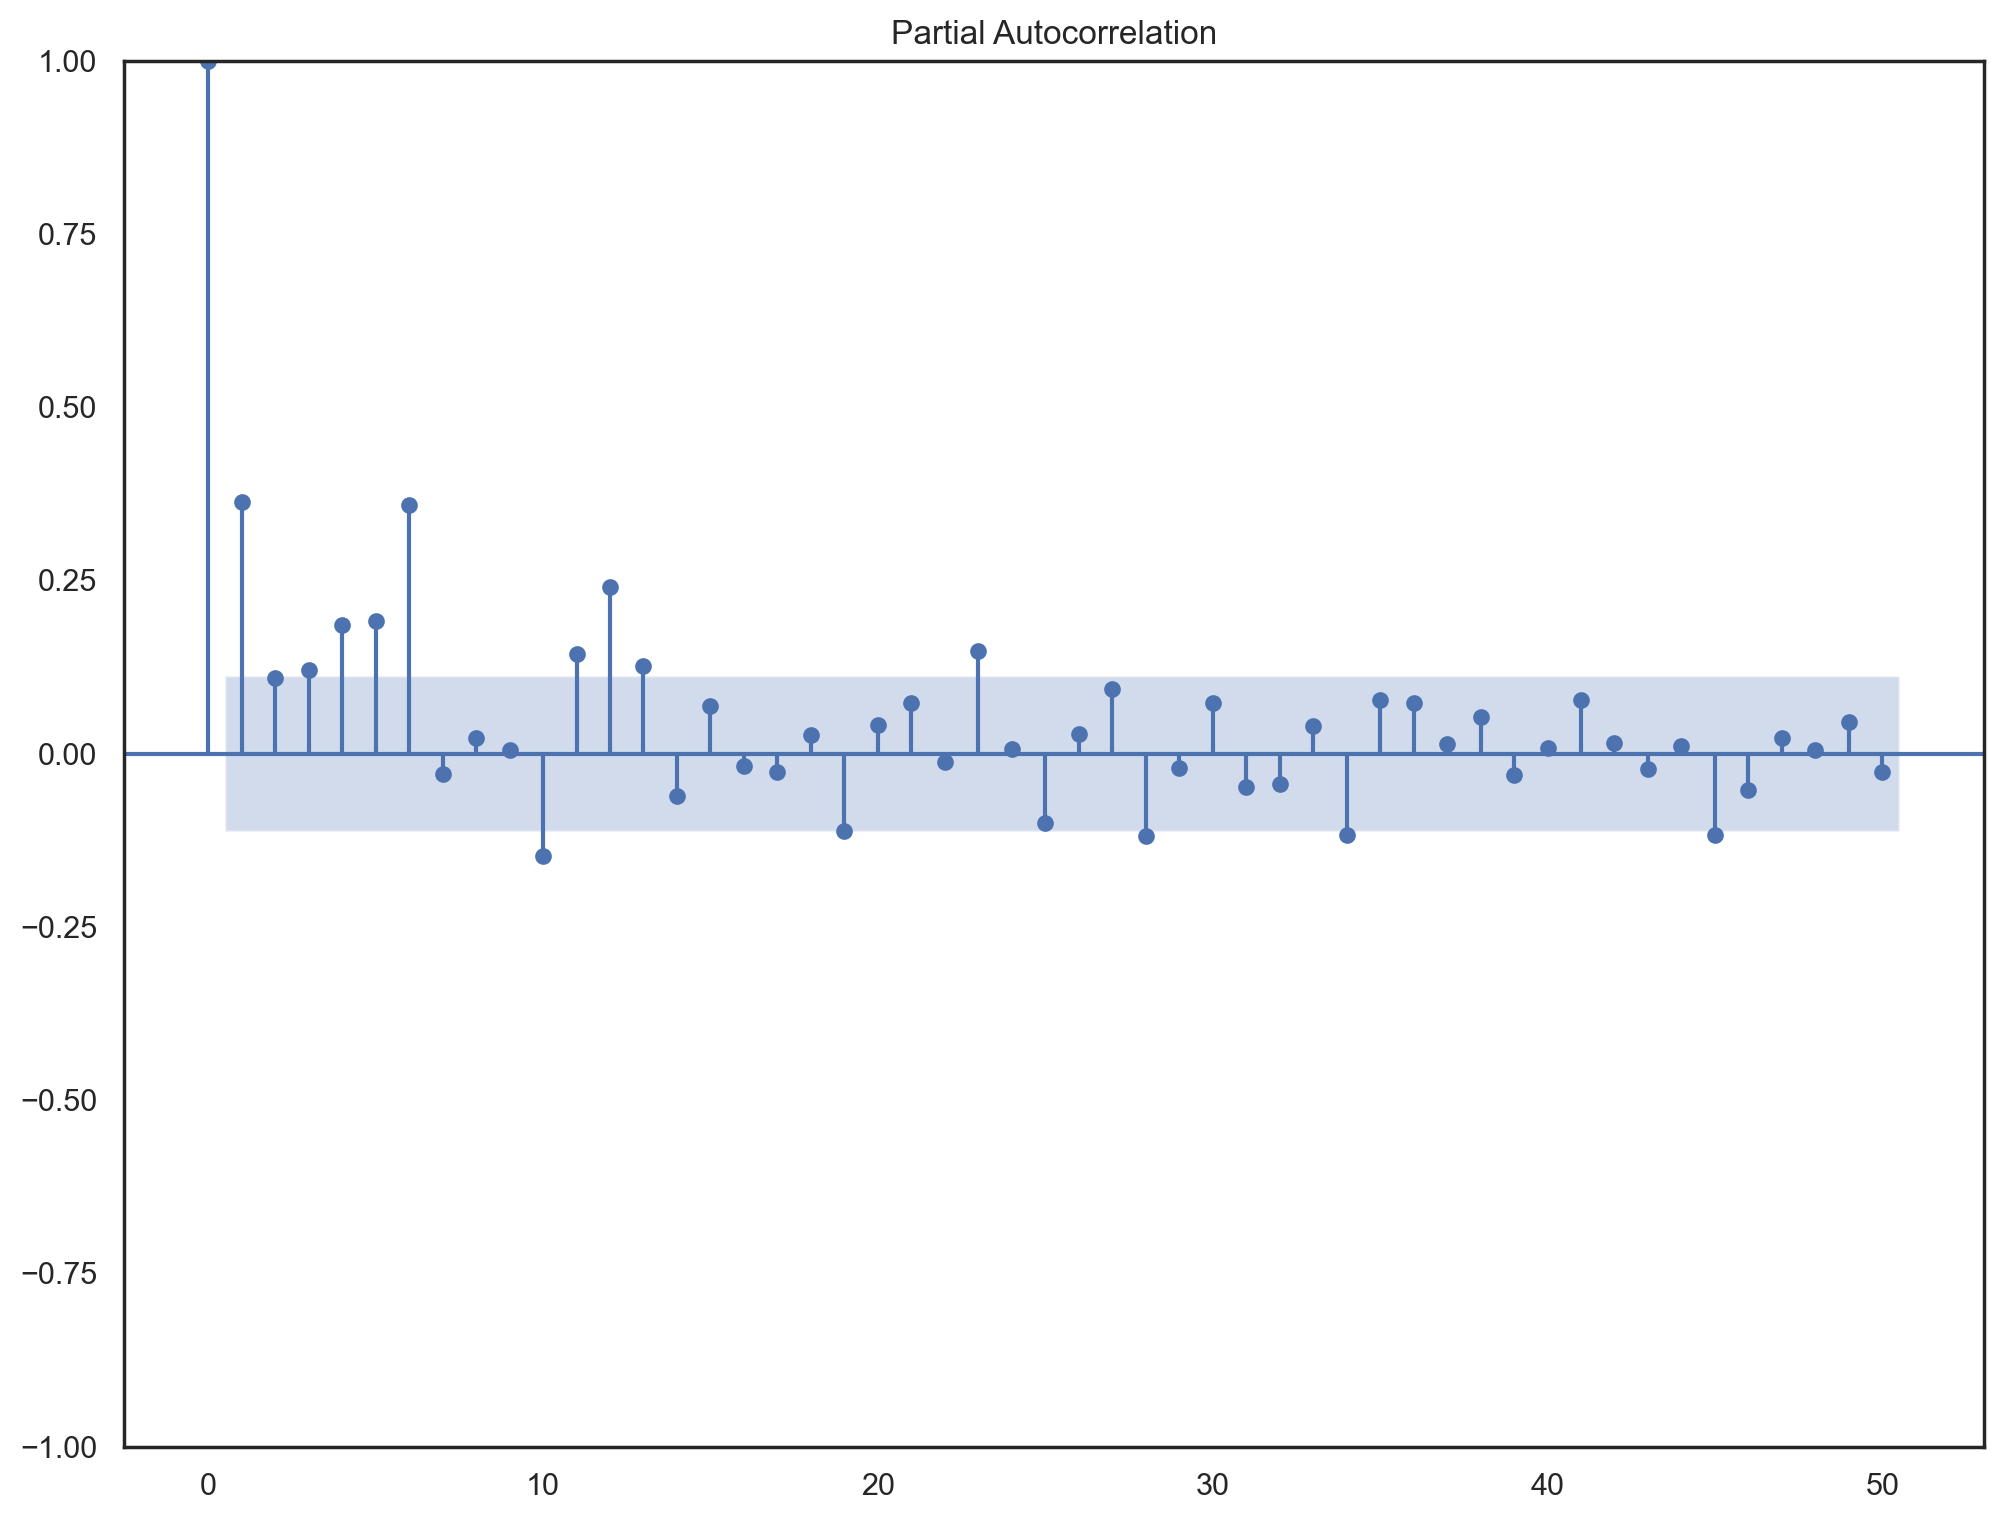

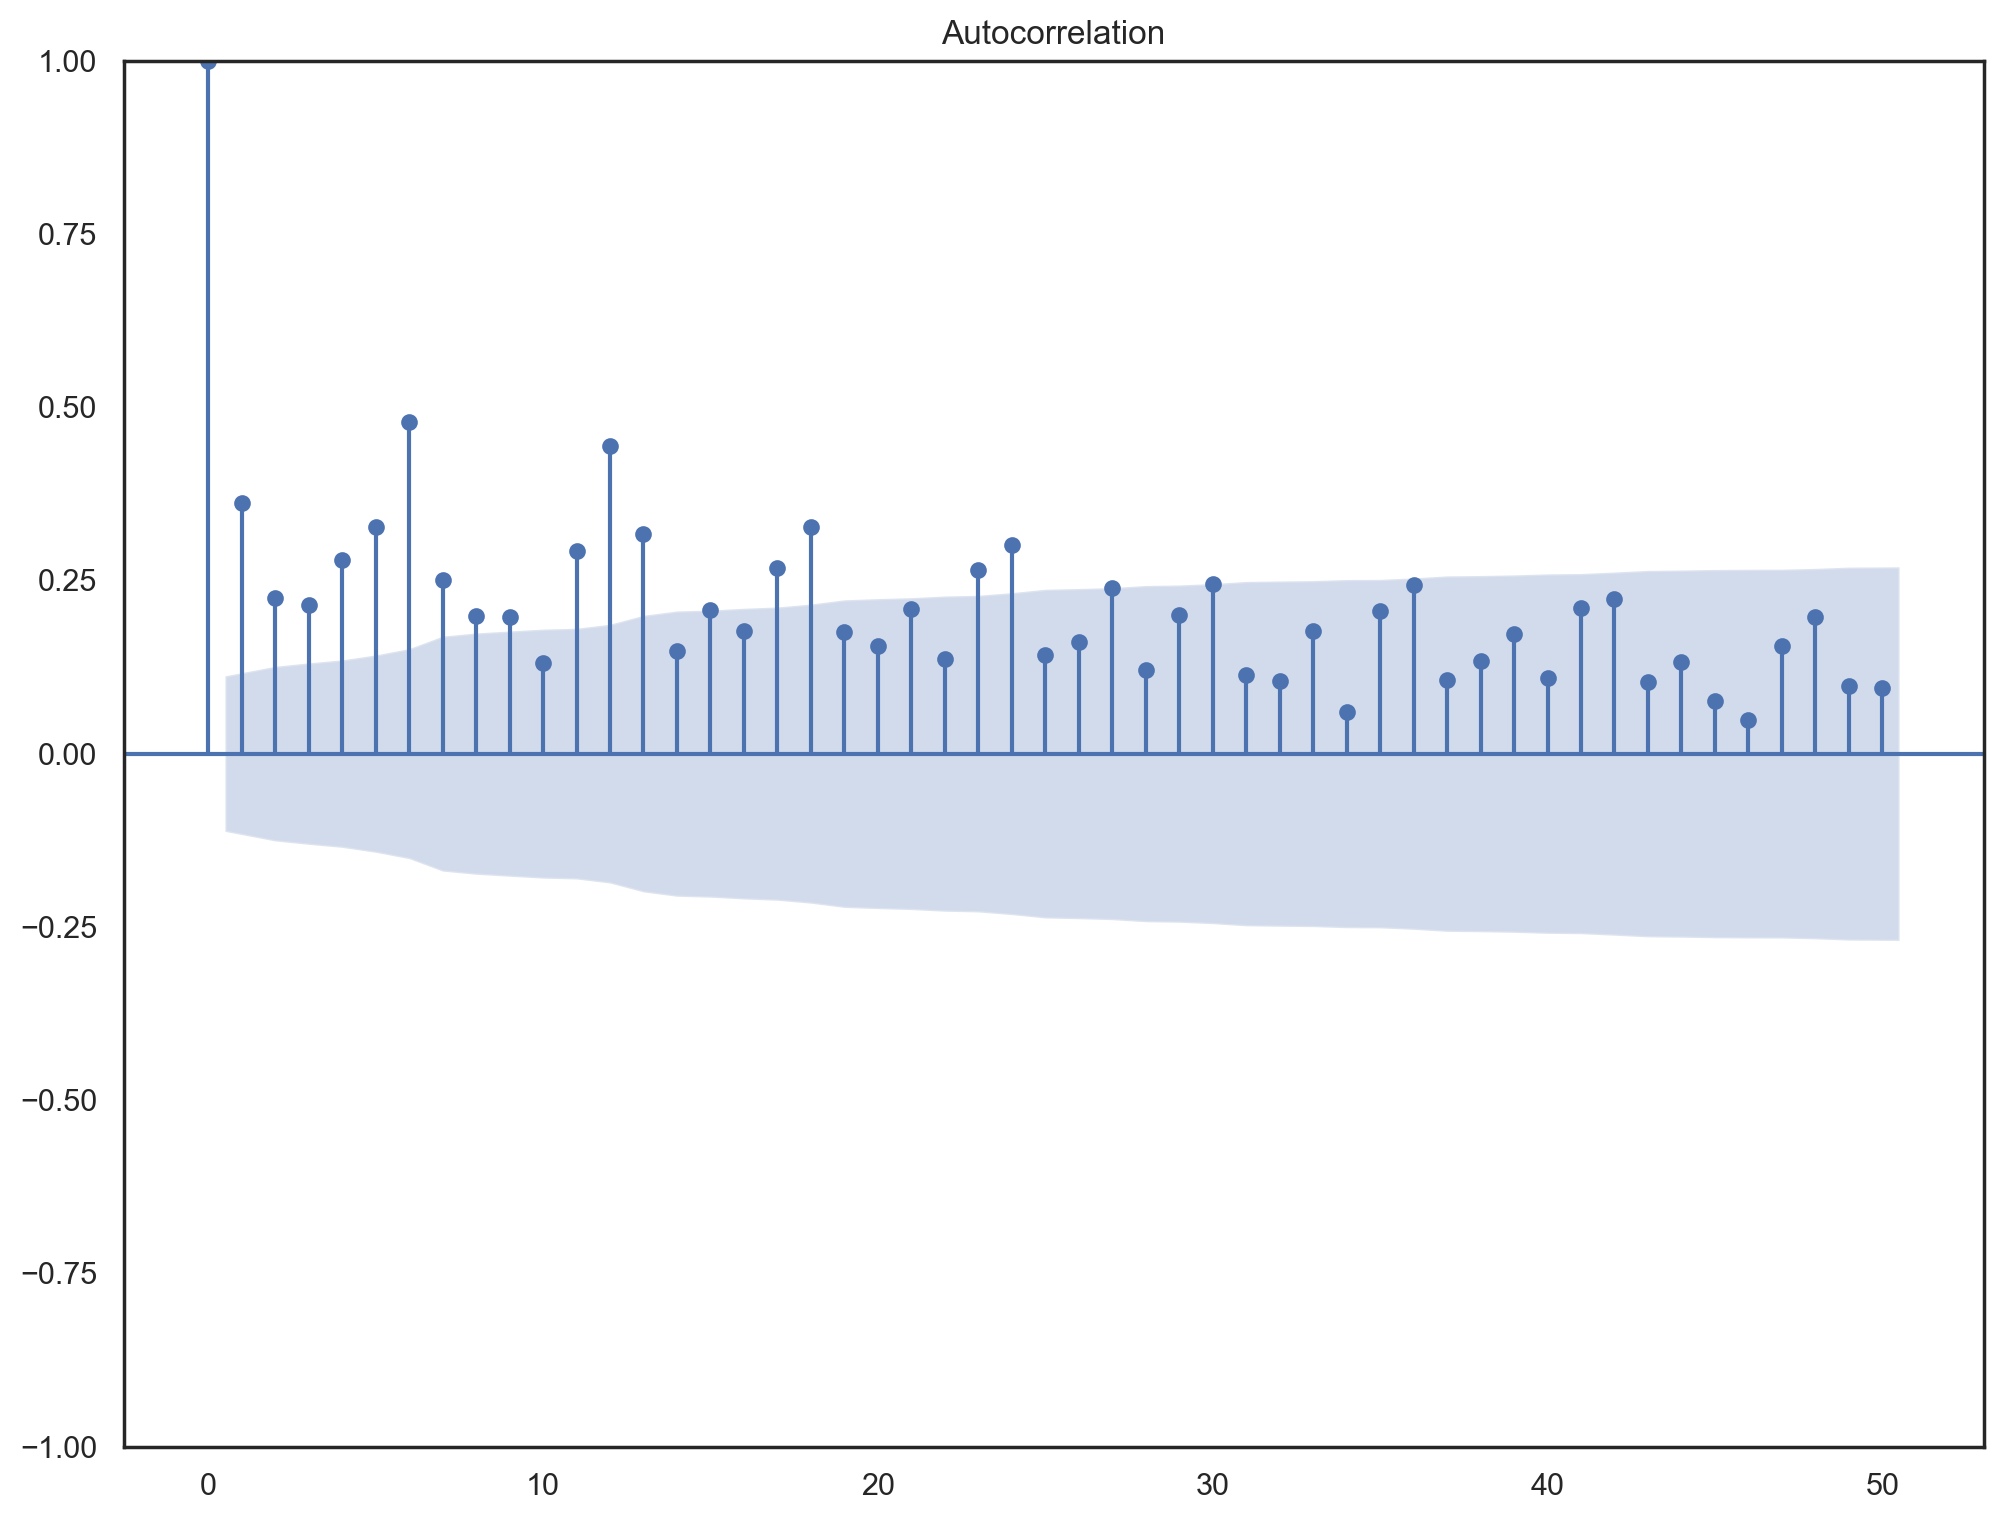

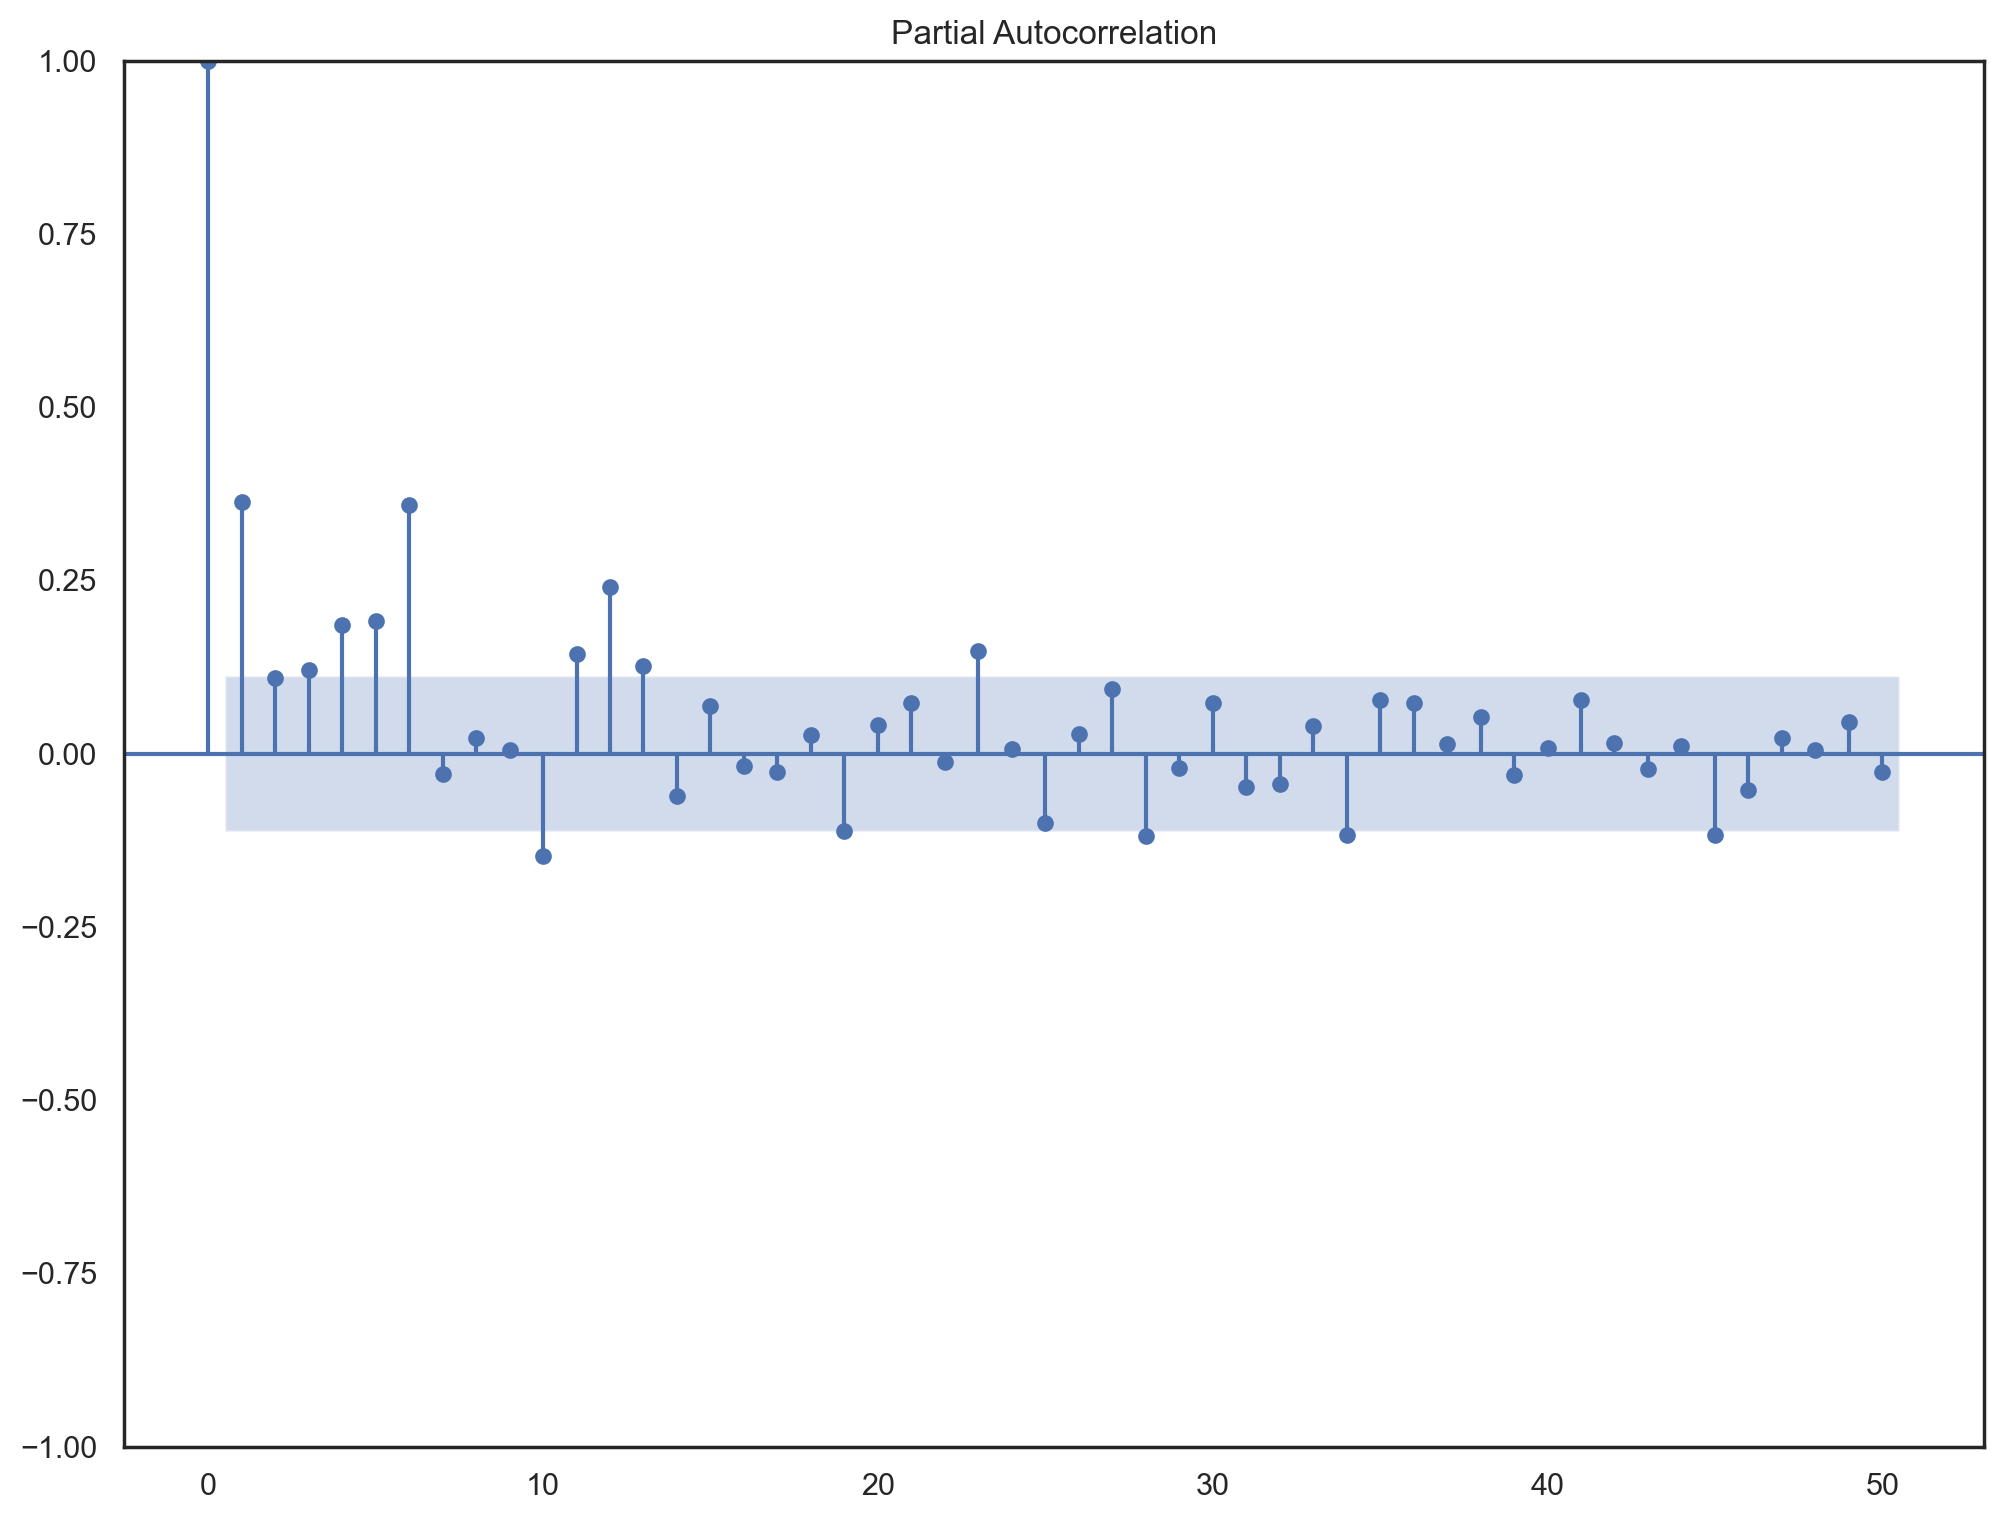

In [467]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df_daily['Revenue'], lags=50)
plot_pacf(df_daily['Revenue'], lags=50)
plt.show()

In [468]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# # Show the existing data
# df_daily['Revenue'].plot()
# plt.title("Existing Revenue Data")
# plt.show()


# # Fit the SARIMA model
# model = SARIMAX(df_daily['Revenue'], 
#                 order=(1, 1, 1),  # ARIMA Order (p,d,q)
#                 seasonal_order=(1, 1, 1, 12))  # Seasonal Order (P,D,Q,S)
# model_fit = model.fit(disp=False)

# # Make a Revenue forecast for the next 365 days
# forecast = model_fit.get_forecast(steps=365).predicted_mean

# # Plot the Revenue forecast
# plt.figure(figsize=(12, 6))
# plt.plot(df_daily.index, df_daily['Revenue'], label='Observed')
# plt.plot(pd.date_range(start=df_daily.index[-1] + pd.Timedelta(days=1), periods=365, freq='D'), forecast, label='Forecast')
# plt.title("Revenue Forecast for the Next Year")
# plt.legend()
# plt.show()

In [469]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,Item_Category
0,536365,85123A,Hanging Heart T-Light Holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.30,Home Decor
1,536365,71053,Lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,White,Metal,20.34,None
2,536365,84406B,Cupid Hearts Coat Hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,2010,12,4,Europe,Cream,None,22.00,None
3,536365,84029G,Knitted Union Flag Hot Water Bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,None,None,20.34,Home Decor
4,536365,84029E,Woolly Hottie Heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,2010,12,4,Europe,Red,None,20.34,None


Revenue By Different Sections By Customer

In [470]:
#Group By CusteomerID and Item_Category and sum the revenue then create a new table called data_rev_by_cat
data_rev_by_cat = data.groupby(['CustomerID', 'Item_Category'])['Revenue'].sum()

# Turn data_rev_by_cat into a DataFrame
data_rev_by_cat = data_rev_by_cat.to_frame()
data_rev_by_cat.head()

# Fill the Customer_ID down until a new customerID appears
data_rev_by_cat_1 = data_rev_by_cat.reset_index().pivot(index='CustomerID', columns='Item_Category', values='Revenue').fillna(0)

data_rev_by_cat_1.head()

# # Now merge data_rev_by_cat_1 with the original data DataFrame
# data = data.merge(data_rev_by_cat_1, on='CustomerID')

Revenue
CustomerID Item_Category         
12347.0    Accessories      79.80
           Home Decor     1439.44
           Kitchenware     589.08
           Party/Holiday   359.93
12348.0    Kitchenware      63.60

Item_Category,Accessories,Home Decor,Kitchenware,Lunchware,Party/Holiday
CustomerID,,,,,
12347.0,79.8,1439.44,589.08,0.0,359.93
12348.0,0.0,0.00,63.60,0.0,270.00
12349.0,208.8,183.09,407.48,0.0,69.15
12350.0,54.6,0.00,20.40,0.0,0.00
12352.0,66.6,225.35,323.18,23.4,182.75


In [471]:
data_rev_by_cat_1.reset_index(inplace=True)
data_rev_by_cat_1.head()

Item_Category,CustomerID,Accessories,Home Decor,Kitchenware,Lunchware,Party/Holiday
0,12347.0,79.8,1439.44,589.08,0.0,359.93
1,12348.0,0.0,0.00,63.60,0.0,270.00
2,12349.0,208.8,183.09,407.48,0.0,69.15
3,12350.0,54.6,0.00,20.40,0.0,0.00
4,12352.0,66.6,225.35,323.18,23.4,182.75


In [472]:
# Step 1: Calculate the total revenue for each row
data_rev_by_cat_1['Total_Revenue'] = data_rev_by_cat_1[['Accessories', 'Home Decor', 'Kitchenware', 'Lunchware', 'Party/Holiday']].sum(axis=1)

# # Step 2: Calculate the percentage of each product category relative to Total_Revenue
# categories = ['Accessories', 'Home Decor', 'Kitchenware', 'Lunchware', 'Party/Holiday']
# for category in categories:
#     data_rev_by_cat_1[f'{category}_Percentage'] = (data_rev_by_cat_1[category] / data_rev_by_cat_1['Total_Revenue'])

# # Step 3: Drop the existing columns for those product categories
# # data_rev_by_cat_1.drop(columns=categories, inplace=True)

# data_rev_by_cat_1.head()

# # Drop Total_revenue
# data_rev_by_cat_1.drop(columns='Total_Revenue', inplace=True)


In [473]:
data_rev_by_cat_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4278 entries, 0 to 4277
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4278 non-null   float64
 1   Accessories    4278 non-null   float64
 2   Home Decor     4278 non-null   float64
 3   Kitchenware    4278 non-null   float64
 4   Lunchware      4278 non-null   float64
 5   Party/Holiday  4278 non-null   float64
 6   Total_Revenue  4278 non-null   float64
dtypes: float64(7)
memory usage: 234.1 KB


In [474]:
data_rev_by_cat_1['CustomerID'].nunique()

4278

In [475]:
# Merge the resulting DataFrame with the customer_data DataFrame based on CustomerID
customer_data = customer_data.merge(data_rev_by_cat_1, on='CustomerID')
customer_data.head()

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,Accessories,Home Decor,Kitchenware,Lunchware,Party/Holiday,Total_Revenue
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219,2010-12,79.8,1439.44,589.08,0.0,359.93,2468.25
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596,2010-12,0.0,0.00,63.60,0.0,270.00,333.60
2,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,1457.55,0.000000,inf,2011-11,208.8,183.09,407.48,0.0,69.15,868.52
3,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,294.40,0.000000,inf,2011-02,54.6,0.00,20.40,0.0,0.00,75.00
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962,2011-02,66.6,225.35,323.18,23.4,182.75,821.28


In [476]:
# Remove Customers with a Customer Lifetime below 1, which is indicative of customers less than a month
customer_data = customer_data[customer_data['Customer_Lifetime'] > 1]

In [477]:
# # # Export Data to CSV
# customer_data.to_csv('customer_july_20_2023.csv', index=False)

# # Export Data to CSV
# data.to_csv('main_transaction_july_20_2023.csv', index=False)

# # Sum up the revenue for each category besides CustomerID
# data_rev_by_cat_1 = data_rev_by_cat_1.groupby('CustomerID').sum()

#### Removing Outliers from Quantity + Revenue Columns

In [478]:
# Remove Outliers from Quantity and Revenue Columns
def find_boundaries(df, variable,q1=0.05,q2=0.95):

# the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary

def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                       np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

capping_outliers(data,'UnitPrice')
capping_outliers(data,'Quantity')

#### Creating a Customers Only Dataframe

In [479]:
# # Create a New Table that Only has the CustomerID, Country, Continent, Total Invoices, first_purchase,	last_purchase,	Total_Customer_Revenue,Customer_Lifetime,	Customer_Lifetime_Value, Accessories_Revenue	Home Decor_Revenue	Kitchenware_Revenue	Lunchware_Revenue	Party/Holiday_Revenue
# customer_data = data[['CustomerID', 'Country', 'Continent', 'TotalInvoices', 'first_purchase', 'last_purchase', 'Total_Customer_Revenue', 'Customer_Lifetime', 'Customer_Lifetime_Value',
#                       'Accessories', 'Home Decor', 'Kitchenware', 'Lunchware','Party/Holiday']]

In [480]:
customer_data.head()

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,Accessories,Home Decor,Kitchenware,Lunchware,Party/Holiday,Total_Revenue
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219,2010-12,79.80,1439.44,589.08,0.0,359.93,2468.25
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596,2010-12,0.00,0.00,63.60,0.0,270.00,333.60
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962,2011-02,66.60,225.35,323.18,23.4,182.75,821.28
8,12356.0,2011-01-18 09:50:00,2011-11-17 08:40:00,2487.43,9.953433,8.236523,2011-01,121.12,12.75,1075.13,0.0,714.71,1923.71
10,12358.0,2011-07-12 10:04:00,2011-12-08 10:26:00,928.06,4.895880,6.228591,2011-07,15.00,785.40,44.94,0.0,82.72,928.06


In [481]:
# Create a Column Called Other that is total_revenue sbutracted by Accessories, Home Decor, Kitchenware, Lunchware, Party/Holiday
customer_data['Other'] = customer_data['total_revenue'] - customer_data['Accessories'] - customer_data['Home Decor'] - customer_data['Kitchenware'] - customer_data['Lunchware'] - customer_data['Party/Holiday']

# Change the Column Names for Accessories	Home Decor	Kitchenware	Lunchware	Party/Holiday	Other to Accessories_Revenue	Home Decor_Revenue	Kitchenware_Revenue	Lunchware_Revenue	Party/Holiday_Revenue	Other_Revenue
customer_data.columns.values[-6:] = [x + '_Revenue' for x in customer_data.columns.values[-6:]]

# Doing this is necessary in order to have methods such as info still function properly
customer_data.columns = customer_data.columns.str.replace(' ', '_')  # Replace spaces with underscores if necessary
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2630 entries, 0 to 4277
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustomerID               2630 non-null   float64       
 1   first_purchase           2630 non-null   datetime64[ns]
 2   last_purchase            2630 non-null   datetime64[ns]
 3   total_revenue            2630 non-null   float64       
 4   Customer_Lifetime        2630 non-null   float64       
 5   Customer_Lifetime_Value  2630 non-null   float64       
 6   Cohort_Group             2630 non-null   object        
 7   Accessories              2630 non-null   float64       
 8   Home_Decor_Revenue       2630 non-null   float64       
 9   Kitchenware_Revenue      2630 non-null   float64       
 10  Lunchware_Revenue        2630 non-null   float64       
 11  Party/Holiday_Revenue    2630 non-null   float64       
 12  Total_Revenue_Revenue    2630 non-

Create a Column for Cohort Month

In [482]:
customer_data['cohort_month'] = customer_data['first_purchase'].dt.to_period('M')

When calculating Customer Lifetime Value (CLV), encountering infinite values for customers with only one transaction is a common issue. This occurs because the formula for CLV typically involves dividing the total revenue or profit by the number of repeat transactions or the churn rate.

To address this issue, instead of letting the CLV be represented as infinite, I assigned a default value to indicate that the CLV for customers with one transaction is not available or meaningful. 

In [483]:
# Assign Rows where the Customer_Lifetime_Value is inf to be numpy.nan
customer_data.loc[customer_data['Customer_Lifetime_Value'] == np.inf, 'Customer_Lifetime_Value'] = np.nan

In [536]:
customer_data.head()

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,Accessories,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Total_Revenue_Revenue,Other_Revenue,cohort_month,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv,Segment
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219,2010-12,79.80,1439.44,589.08,0.0,359.93,2468.25,1.841750e+03,2010-12,6.0,365.0,367.0,599.701667,3.295395,1970.348608,Loyal Customers
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596,2010-12,0.00,0.00,63.60,0.0,270.00,333.60,1.103640e+03,2010-12,3.0,283.0,358.0,261.480000,2.198327,593.690882,Hibernating
2,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962,2011-02,66.60,225.35,323.18,23.4,182.75,821.28,4.441300e+02,2011-02,6.0,260.0,296.0,181.540000,3.875704,703.144886,Hibernating
3,12356.0,2011-01-18 09:50:00,2011-11-17 08:40:00,2487.43,9.953433,8.236523,2011-01,121.12,12.75,1075.13,0.0,714.71,1923.71,5.637200e+02,2011-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12358.0,2011-07-12 10:04:00,2011-12-08 10:26:00,928.06,4.895880,6.228591,2011-07,15.00,785.40,44.94,0.0,82.72,928.06,-2.842171e-14,2011-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

In [485]:
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,Item_Category
0,536365,85123A,Hanging Heart T-Light Holder,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.3,Home Decor


In [486]:
customer_data.head(1)

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,Accessories,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Total_Revenue_Revenue,Other_Revenue,cohort_month
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.0,11.993288,11.808219,2010-12,79.8,1439.44,589.08,0.0,359.93,2468.25,1841.75,2010-12


In [487]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2630 entries, 0 to 4277
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CustomerID               2630 non-null   float64       
 1   first_purchase           2630 non-null   datetime64[ns]
 2   last_purchase            2630 non-null   datetime64[ns]
 3   total_revenue            2630 non-null   float64       
 4   Customer_Lifetime        2630 non-null   float64       
 5   Customer_Lifetime_Value  2630 non-null   float64       
 6   Cohort_Group             2630 non-null   object        
 7   Accessories              2630 non-null   float64       
 8   Home_Decor_Revenue       2630 non-null   float64       
 9   Kitchenware_Revenue      2630 non-null   float64       
 10  Lunchware_Revenue        2630 non-null   float64       
 11  Party/Holiday_Revenue    2630 non-null   float64       
 12  Total_Revenue_Revenue    2630 non-

# Exploratory Data Analysis (EDA)

## Univariate Exploration

### Categorical Values

Checklist...  

[X] Country  

[X] InvoiceNo - Irrelevant Column  
[X] Description - Irrelevant Column  
[X] CustomerID  - Irrelevant Column  
[X] new_date - Irrelevant Column  
[X] new_time - Irrelevant Column  

[~] Continent - Skipping for Now   
[~] item_color - Skipping for Now    
[~] item_material - Skipping for Now  
[~] Item_Category - Skipping for Now

##### Country

The UK by FAR has is the largest source of the largest customer base and the greatest number of orders.

In [488]:
# # Group by country and count the number of customers
# country_counts = customer_data.groupby('Country').count()['CustomerID']

# # Sort the countries based on customer count in descending order
# sorted_countries = country_counts.sort_values(ascending=False)

# # Select the top 10 countries
# top_10_countries = sorted_countries.head(10)

# # Plot the horizontal bar chart for the top 10 countries
# plt.figure(figsize=(10, 3))  # Set the figure size if needed
# top_10_countries.plot(kind='barh')
# plt.xlabel('Number of Transactions')
# plt.ylabel('Country')
# plt.title('Top 10 Countries by Customer Count')
# plt.show();


# # Group by country and count the number of customers
# country_counts = data.groupby('Country').count()['CustomerID']

# # Sort the countries based on customer count in descending order
# sorted_countries = country_counts.sort_values(ascending=False)

# # Select the top 10 countries
# top_10_countries = sorted_countries.head(10)

# # Plot the horizontal bar chart for the top 10 countries
# plt.figure(figsize=(10, 3))  # Set the figure size if needed
# top_10_countries.plot(kind='barh')
# plt.xlabel('Number of Transactions')
# plt.ylabel('Country')
# plt.title('Top 10 Countries by Transaction Count')
# plt.show();

When we inspect the data more closely, whether that's from assessing unique customers or number of transactions, then the rankings differ.

For total number of transactions, EIRE (Ireland) is in third place. For number of customers, Spain is in third place.

In [489]:
# # Remove all transactions where UK is the country
# data_no_uk = data[data['Country'] != 'United Kingdom']
# customer_data_no_uk = customer_data[customer_data['Country'] != 'United Kingdom']

KeyError: 'Country'

To Do:
- Add a Note that the UK is not included
- Have  center title to redude title redundancy

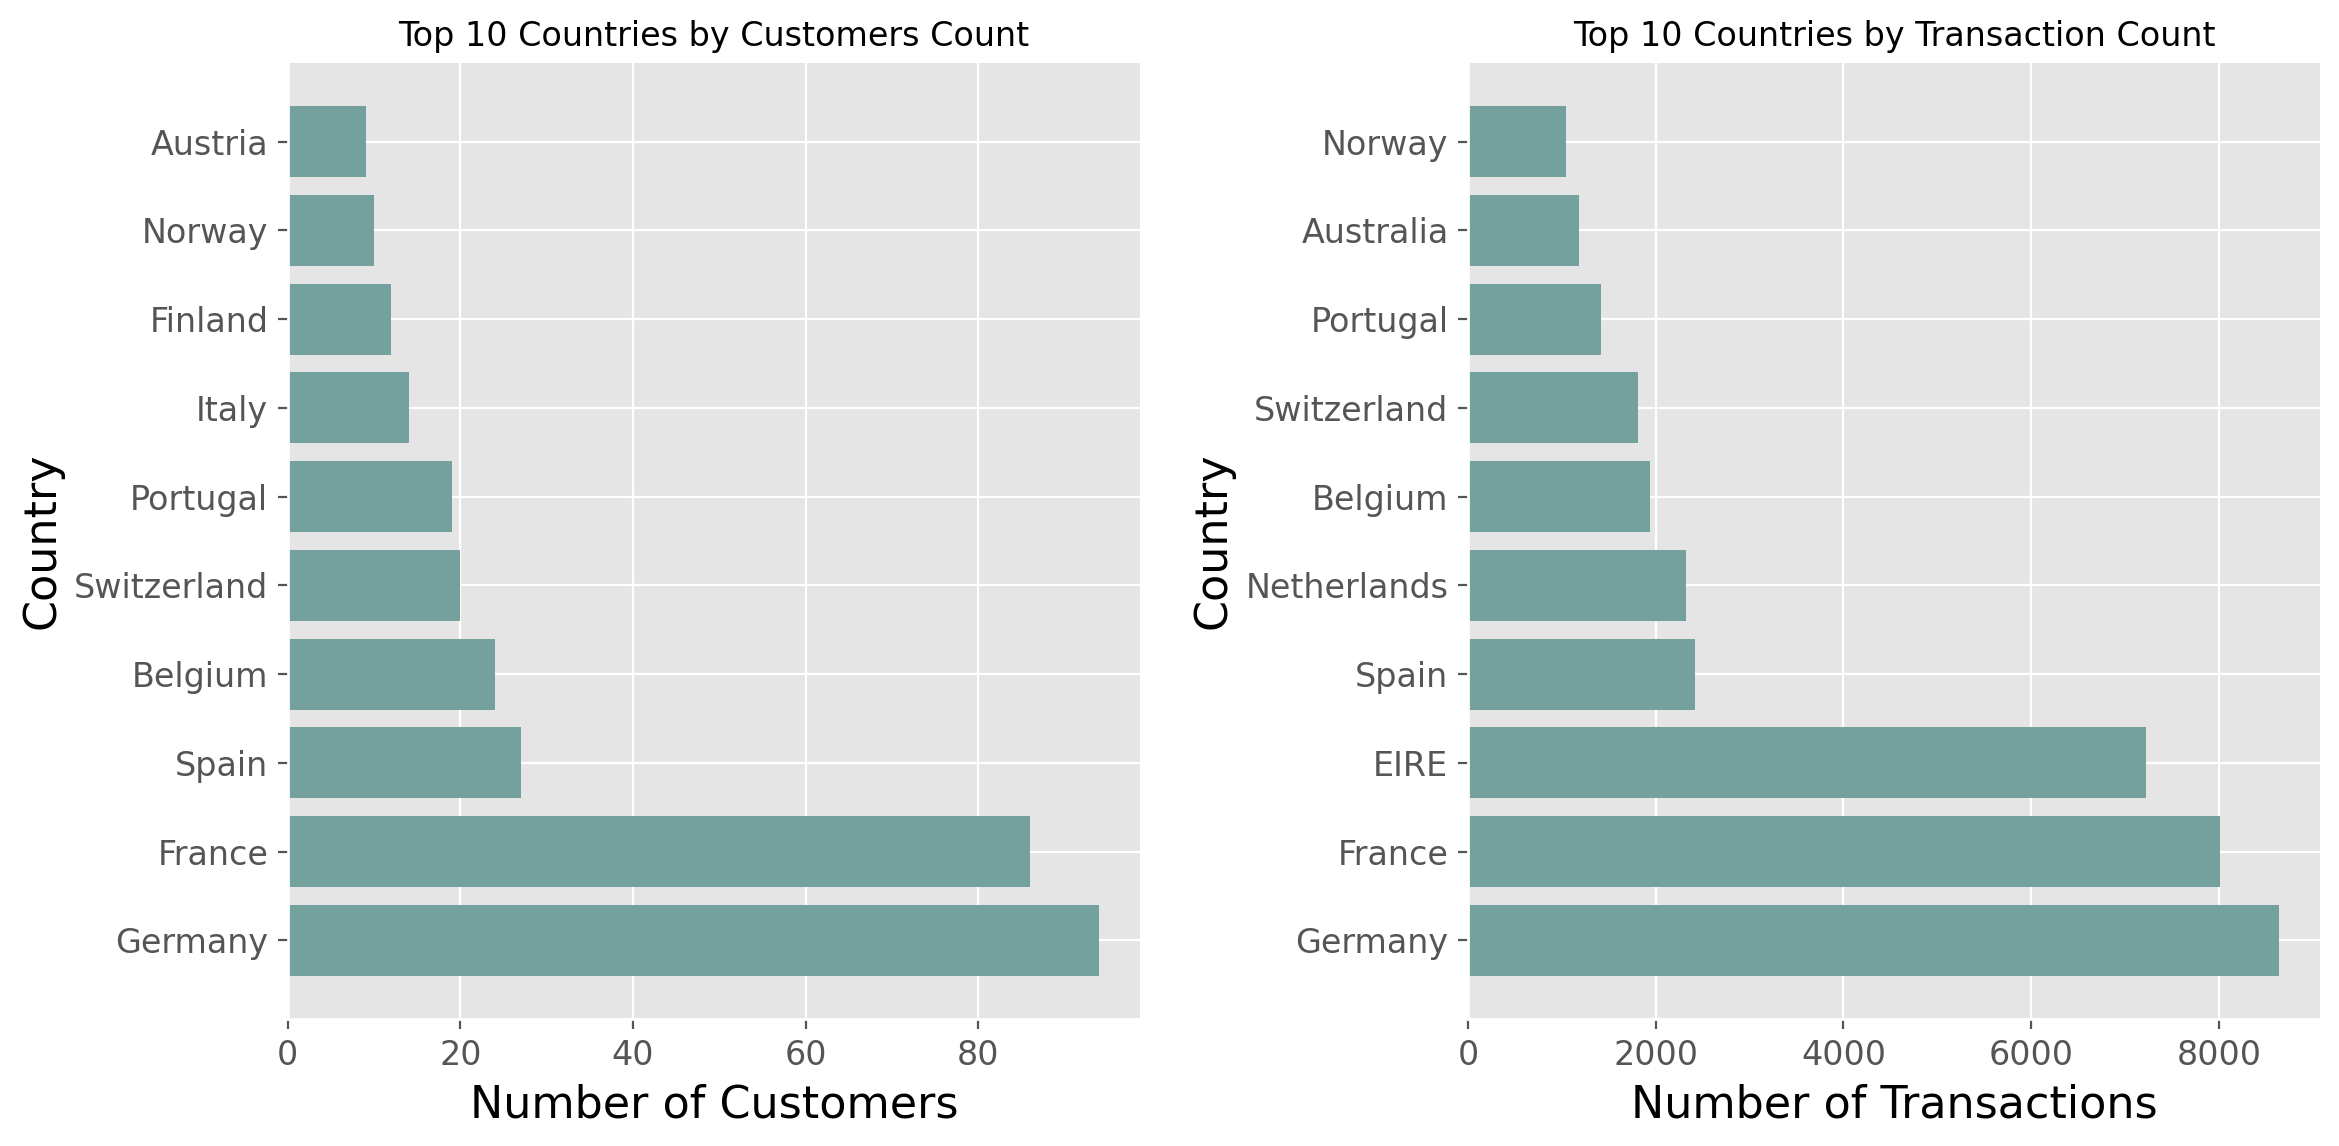

In [ ]:
# # Group by country and count the number of customers
# country_counts = customer_data_no_uk.groupby('Country').count()['CustomerID']

# # Sort the countries based on customer count in descending order
# sorted_countries = country_counts.sort_values(ascending=False)

# # Select the top 10 countries
# top_10_countries = sorted_countries.head(10)

# # Create a figure with two subplots
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the horizontal bar chart for the top 10 countries - First subplot
# axes[0].barh(top_10_countries.index, top_10_countries.values)
# axes[0].set_xlabel('Number of Customers')
# axes[0].set_ylabel('Country')
# axes[0].set_title('Top 10 Countries by Customers Count', fontsize=12)

# # Group by country and count the number of customers for the second plot
# country_counts = data_no_uk.groupby('Country').count()['CustomerID']

# # Sort the countries based on customer count in descending order
# sorted_countries = country_counts.sort_values(ascending=False)

# # Select the top 10 countries
# top_10_countries = sorted_countries.head(10)

# # Plot the horizontal bar chart for the top 10 countries - Second subplot
# axes[1].barh(top_10_countries.index, top_10_countries.values)
# axes[1].set_xlabel('Number of Transactions')
# axes[1].set_ylabel('Country')
# axes[1].set_title('Top 10 Countries by Transaction Count', fontsize=12)

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Display the plots
# plt.show();

#### Numeric Data

Checklist...

[ ] Quantity  
[ ] UnitPrice  
[ ] TotalInvoices  
[ ] Revenue  
[ ] Total_Customer_Revenue  
[ ] Customer_Lifetime  
[ ] Customer_Lifetime_Value  

In [491]:
data.describe()

,Quantity,UnitPrice,is_return,year,month,quarter,Revenue
count,399875.000000,399875.000000,399875.000000,399875.000000,399875.000000,399875.000000,399875.000000
mean,8.799132,2.682933,0.021459,2010.934349,7.596366,2.850958,20.574537
std,9.518530,2.273616,0.144909,0.247671,3.417310,1.121818,73.787947
min,1.000000,0.420000,0.000000,2010.000000,1.000000,1.000000,-6539.400000
25%,2.000000,1.250000,0.000000,2011.000000,5.000000,2.000000,4.250000
50%,5.000000,1.950000,0.000000,2011.000000,8.000000,3.000000,11.580000
75%,12.000000,3.750000,0.000000,2011.000000,11.000000,4.000000,19.500000
max,36.000000,8.500000,1.000000,2011.000000,12.000000,4.000000,7144.720000


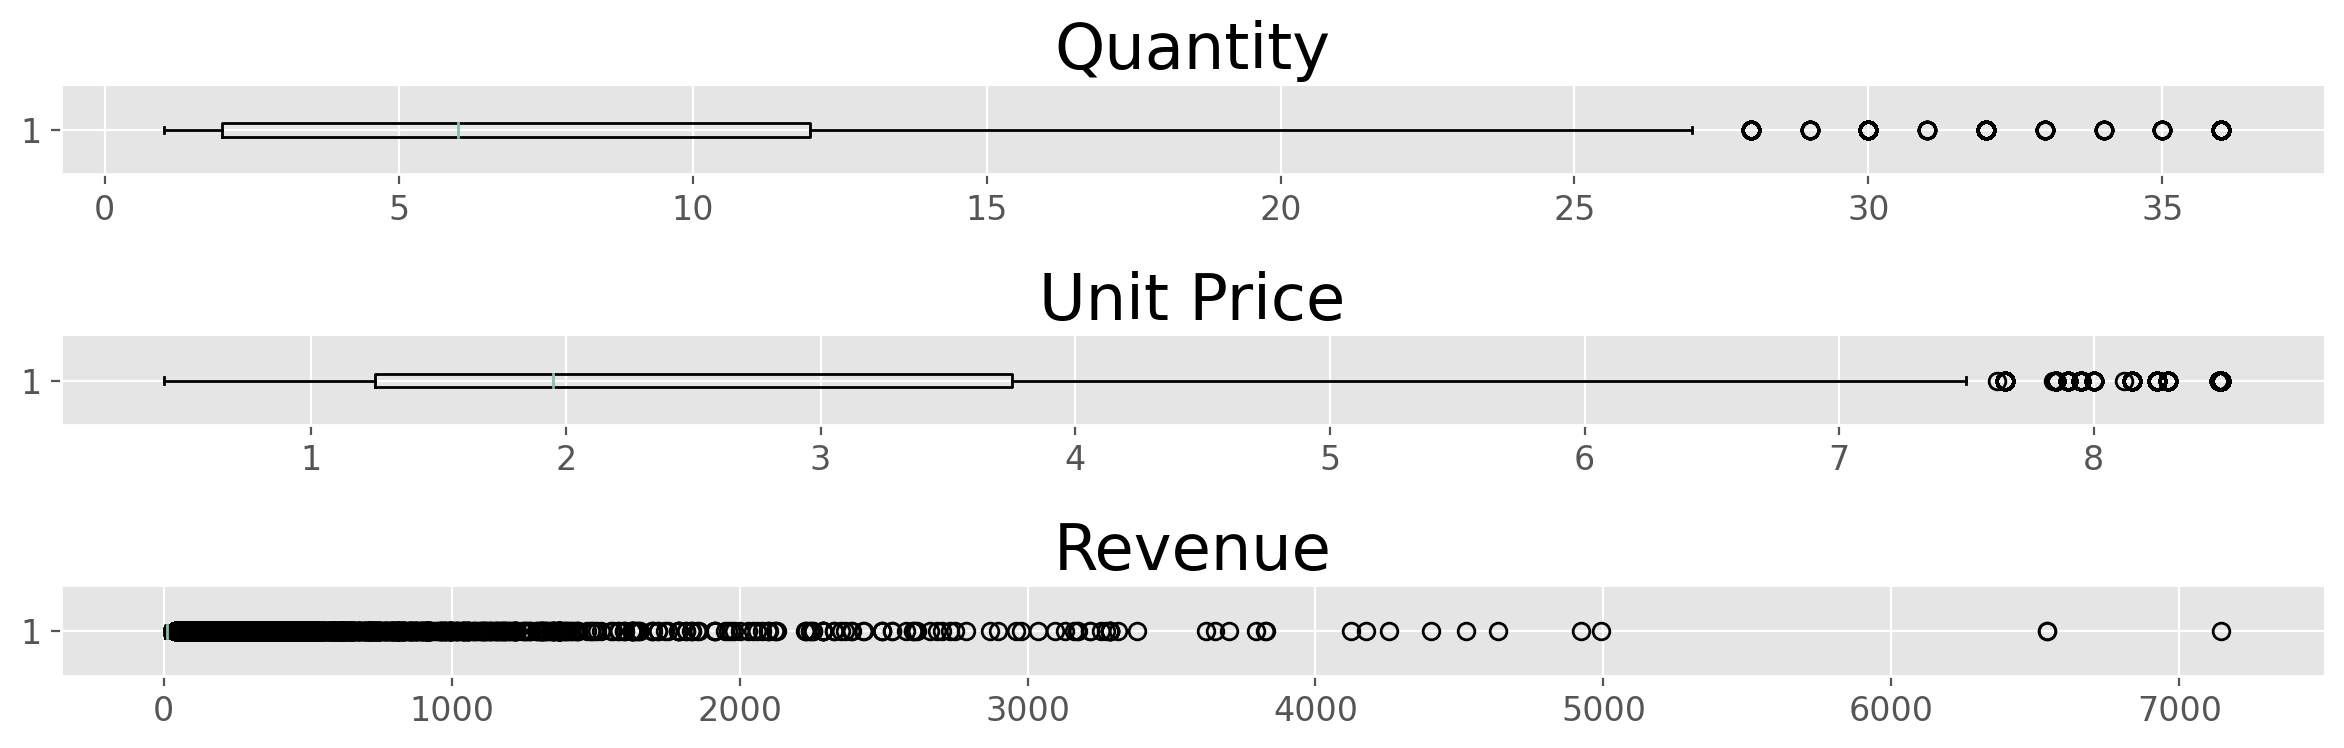

In [ ]:
# # Show a boxplot distribution of Quantity, UnitPrice, and Revenue
# plt.figure(figsize=(12, 4))

# plt.subplot(3, 1, 1)
# plt.boxplot(data['Quantity'], vert=False)
# plt.title('Quantity')

# plt.subplot(3, 1, 2)
# plt.boxplot(data['UnitPrice'], vert=False)
# plt.title('Unit Price')

# plt.subplot(3, 1, 3)
# plt.boxplot(data['Revenue'], vert=False)
# plt.title('Revenue')

# plt.tight_layout()
# plt.show();

In [492]:
customer_data['Customer_Lifetime_Value'].describe()

count    2630.000000
mean       12.623527
std        32.088231
min       -23.437059
25%         3.600160
50%         6.901288
75%        12.786534
max       789.154731
Name: Customer_Lifetime_Value, dtype: float64

KeyError: 'TotalInvoices'

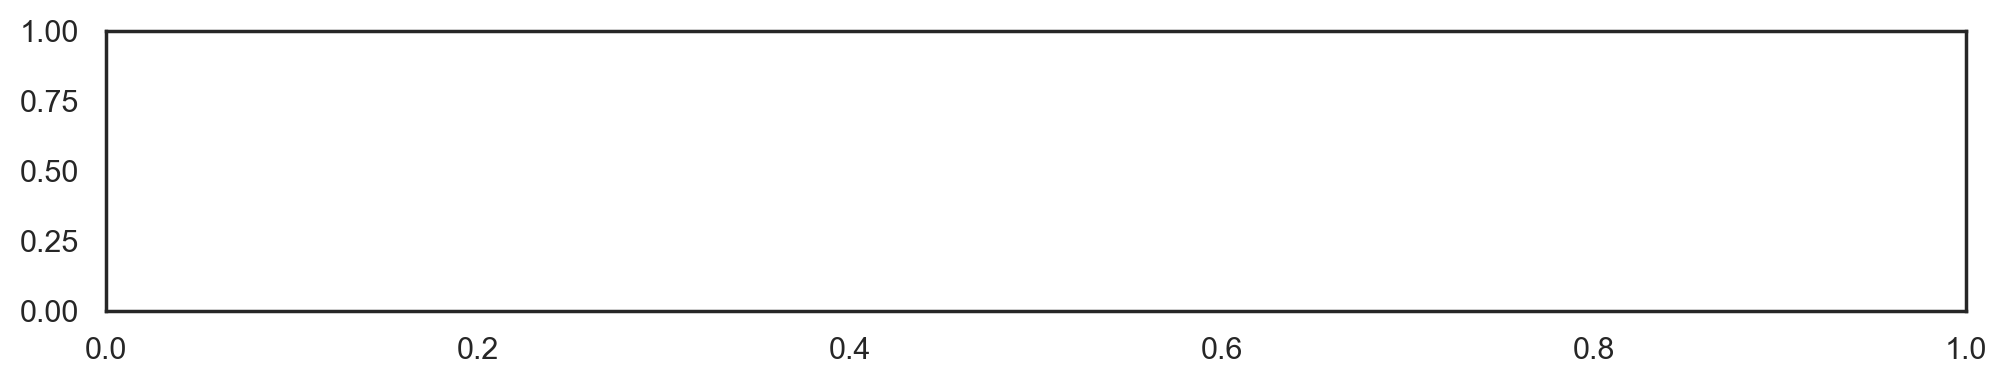

In [493]:
# # Show a boxplot distribution of TotalInvoices, UnitPrice, and Customer_Lifetime
# plt.figure(figsize=(12, 4))

# plt.subplot(2, 1, 1)
# plt.boxplot(customer_data['TotalInvoices'], vert=False)
# plt.title('TotalInvoices')

# plt.subplot(2, 1, 2)
# plt.boxplot(customer_data['Customer_Lifetime'], vert=False)
# plt.title('Customer_Lifetime')

# plt.tight_layout()
# plt.show();

Customer Lifetime Value (CLV)

1/2 of the customers who are in the top 20 for CLV have been customers for less than a month. As such, they've been removed. [TO DO]

In [ ]:
# customer_data.sort_values(by='Customer_Lifetime_Value', ascending=False).head(20)

,CustomerID,Country,Continent,TotalInvoices,first_purchase,last_purchase,Total_Customer_Revenue,Customer_Lifetime,Customer_Lifetime_Value,Accessories_Revenue,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Other_Revenue,cohort_month
161832,14646.0,Netherlands,Europe,72,2011-01-14 12:24:00,2011-09-08 11:28:00,279138.02,7.785330,1182.788220,11730.62,69103.36,30810.43,35811.90,26940.61,104741.10,2011-01
87041,17450.0,United Kingdom,Europe,46,2011-01-11 08:43:00,2011-09-05 13:52:00,194390.79,7.793658,820.214304,0.00,73536.46,68958.91,0.00,4488.18,47407.24,2011-01
356156,14356.0,United Kingdom,Europe,2,2011-09-19 14:43:00,2011-09-21 09:18:00,701.23,0.058295,701.230000,25.00,36.45,152.55,0.00,77.66,409.57,2011-09
321194,15700.0,United Kingdom,Europe,2,2011-06-19 15:36:00,2011-06-20 16:53:00,696.68,0.034612,696.680000,0.00,173.30,80.41,0.00,21.50,421.47,2011-06
388601,14893.0,United Kingdom,Europe,2,2011-11-28 10:49:00,2011-11-30 12:31:00,1237.85,0.068037,618.925000,42.12,555.15,63.00,0.00,104.67,472.91,2011-11
15794,14911.0,EIRE,Europe,199,2011-01-18 10:22:00,2011-09-07 14:13:00,140336.83,7.627604,604.900129,4348.23,26509.41,23952.22,1475.10,23958.56,60093.31,2011-01
64336,15332.0,Lithuania,Europe,4,2010-12-05 12:00:00,2010-12-08 14:43:00,1661.06,0.102284,553.686667,184.20,430.56,210.60,0.00,131.00,704.70,2010-12
169841,12415.0,Australia,Oceania,20,2011-01-10 09:58:00,2011-09-01 13:51:00,124564.53,7.693359,532.327051,4870.80,13404.52,23951.59,8172.40,18814.52,55350.70,2011-01
48391,14156.0,EIRE,Europe,55,2011-01-14 14:11:00,2011-09-07 16:00:00,117210.08,7.756240,496.652881,3242.48,22913.17,20468.81,3967.50,19547.46,47070.66,2011-01
181943,15749.0,United Kingdom,Europe,3,2011-01-11 12:55:00,2011-04-18 13:20:00,44534.30,3.187494,459.116495,0.00,9553.50,6045.00,0.00,21855.80,7080.00,2011-01


<Axes: xlabel='CustomerID'>

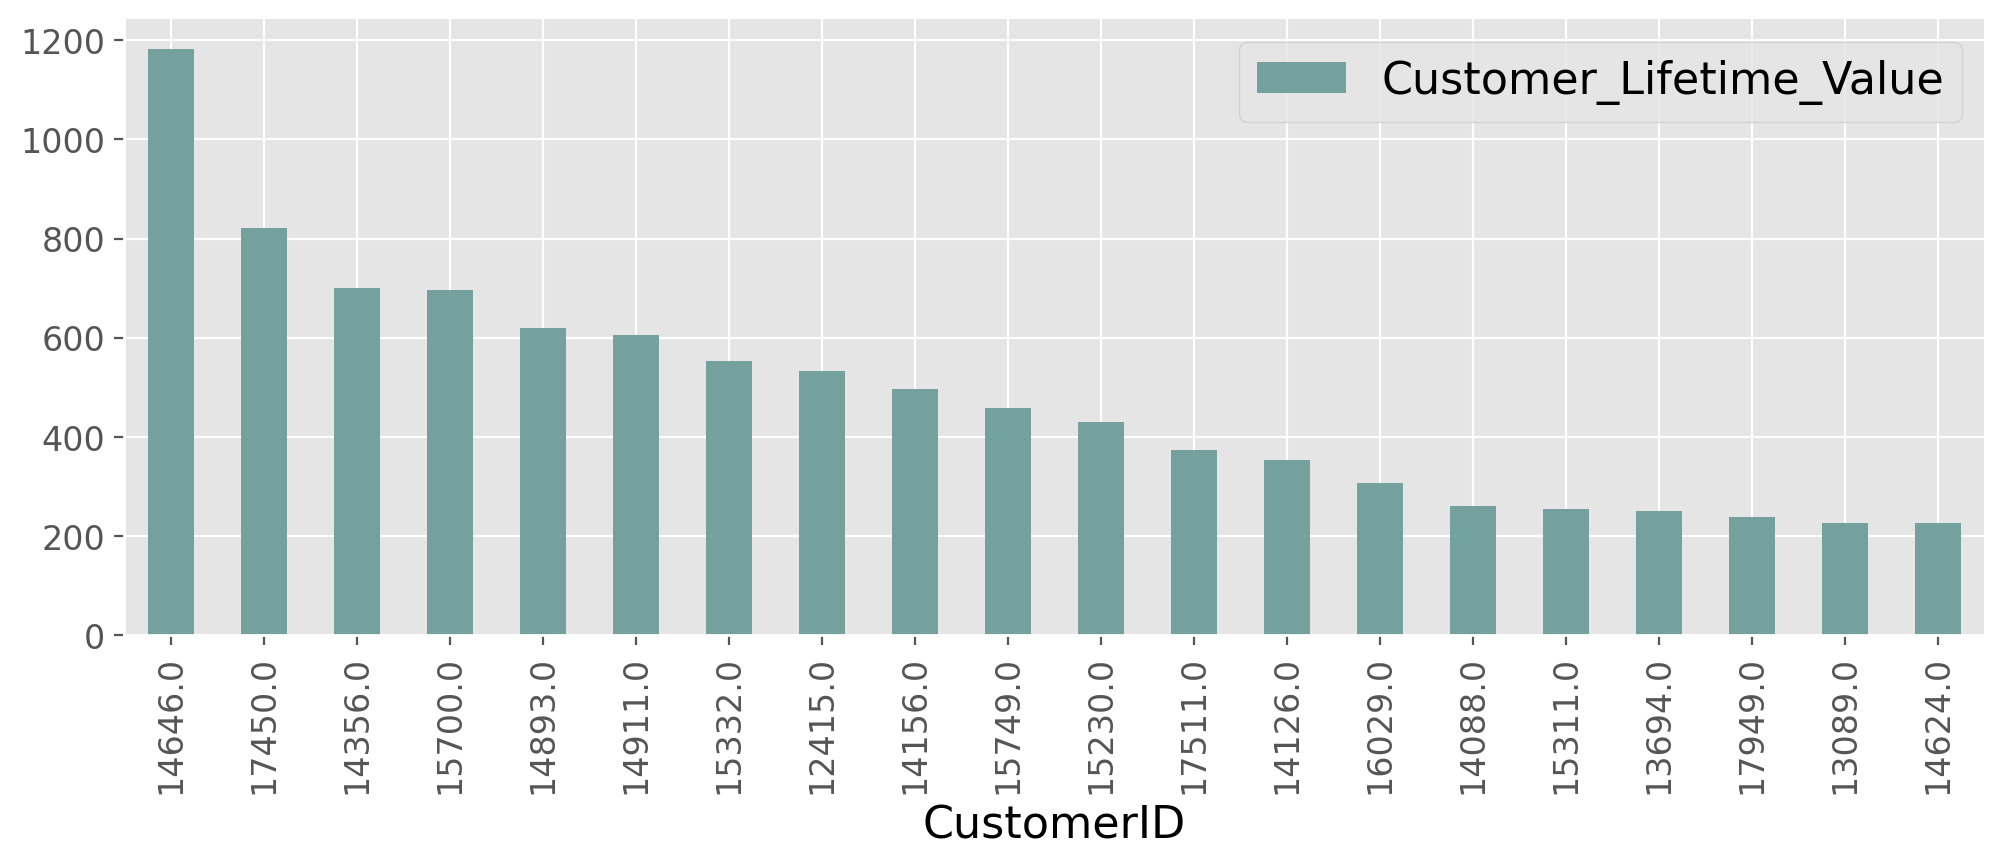

In [ ]:
# # Show only the top 10 highest values for Customer LIfetime Value and have the hue be Customer_Lifetime

# customer_data.sort_values(by='Customer_Lifetime_Value', ascending=False).head(20).plot(kind='bar', x='CustomerID', y='Customer_Lifetime_Value', figsize=(12, 4))

In [494]:
# Remove Customers with a Customer Lifetime below 1, which is indicative of customers less than a month
customer_data = customer_data[customer_data['Customer_Lifetime'] > 1]

<Axes: xlabel='Customer_Lifetime_Value', ylabel='Density'>

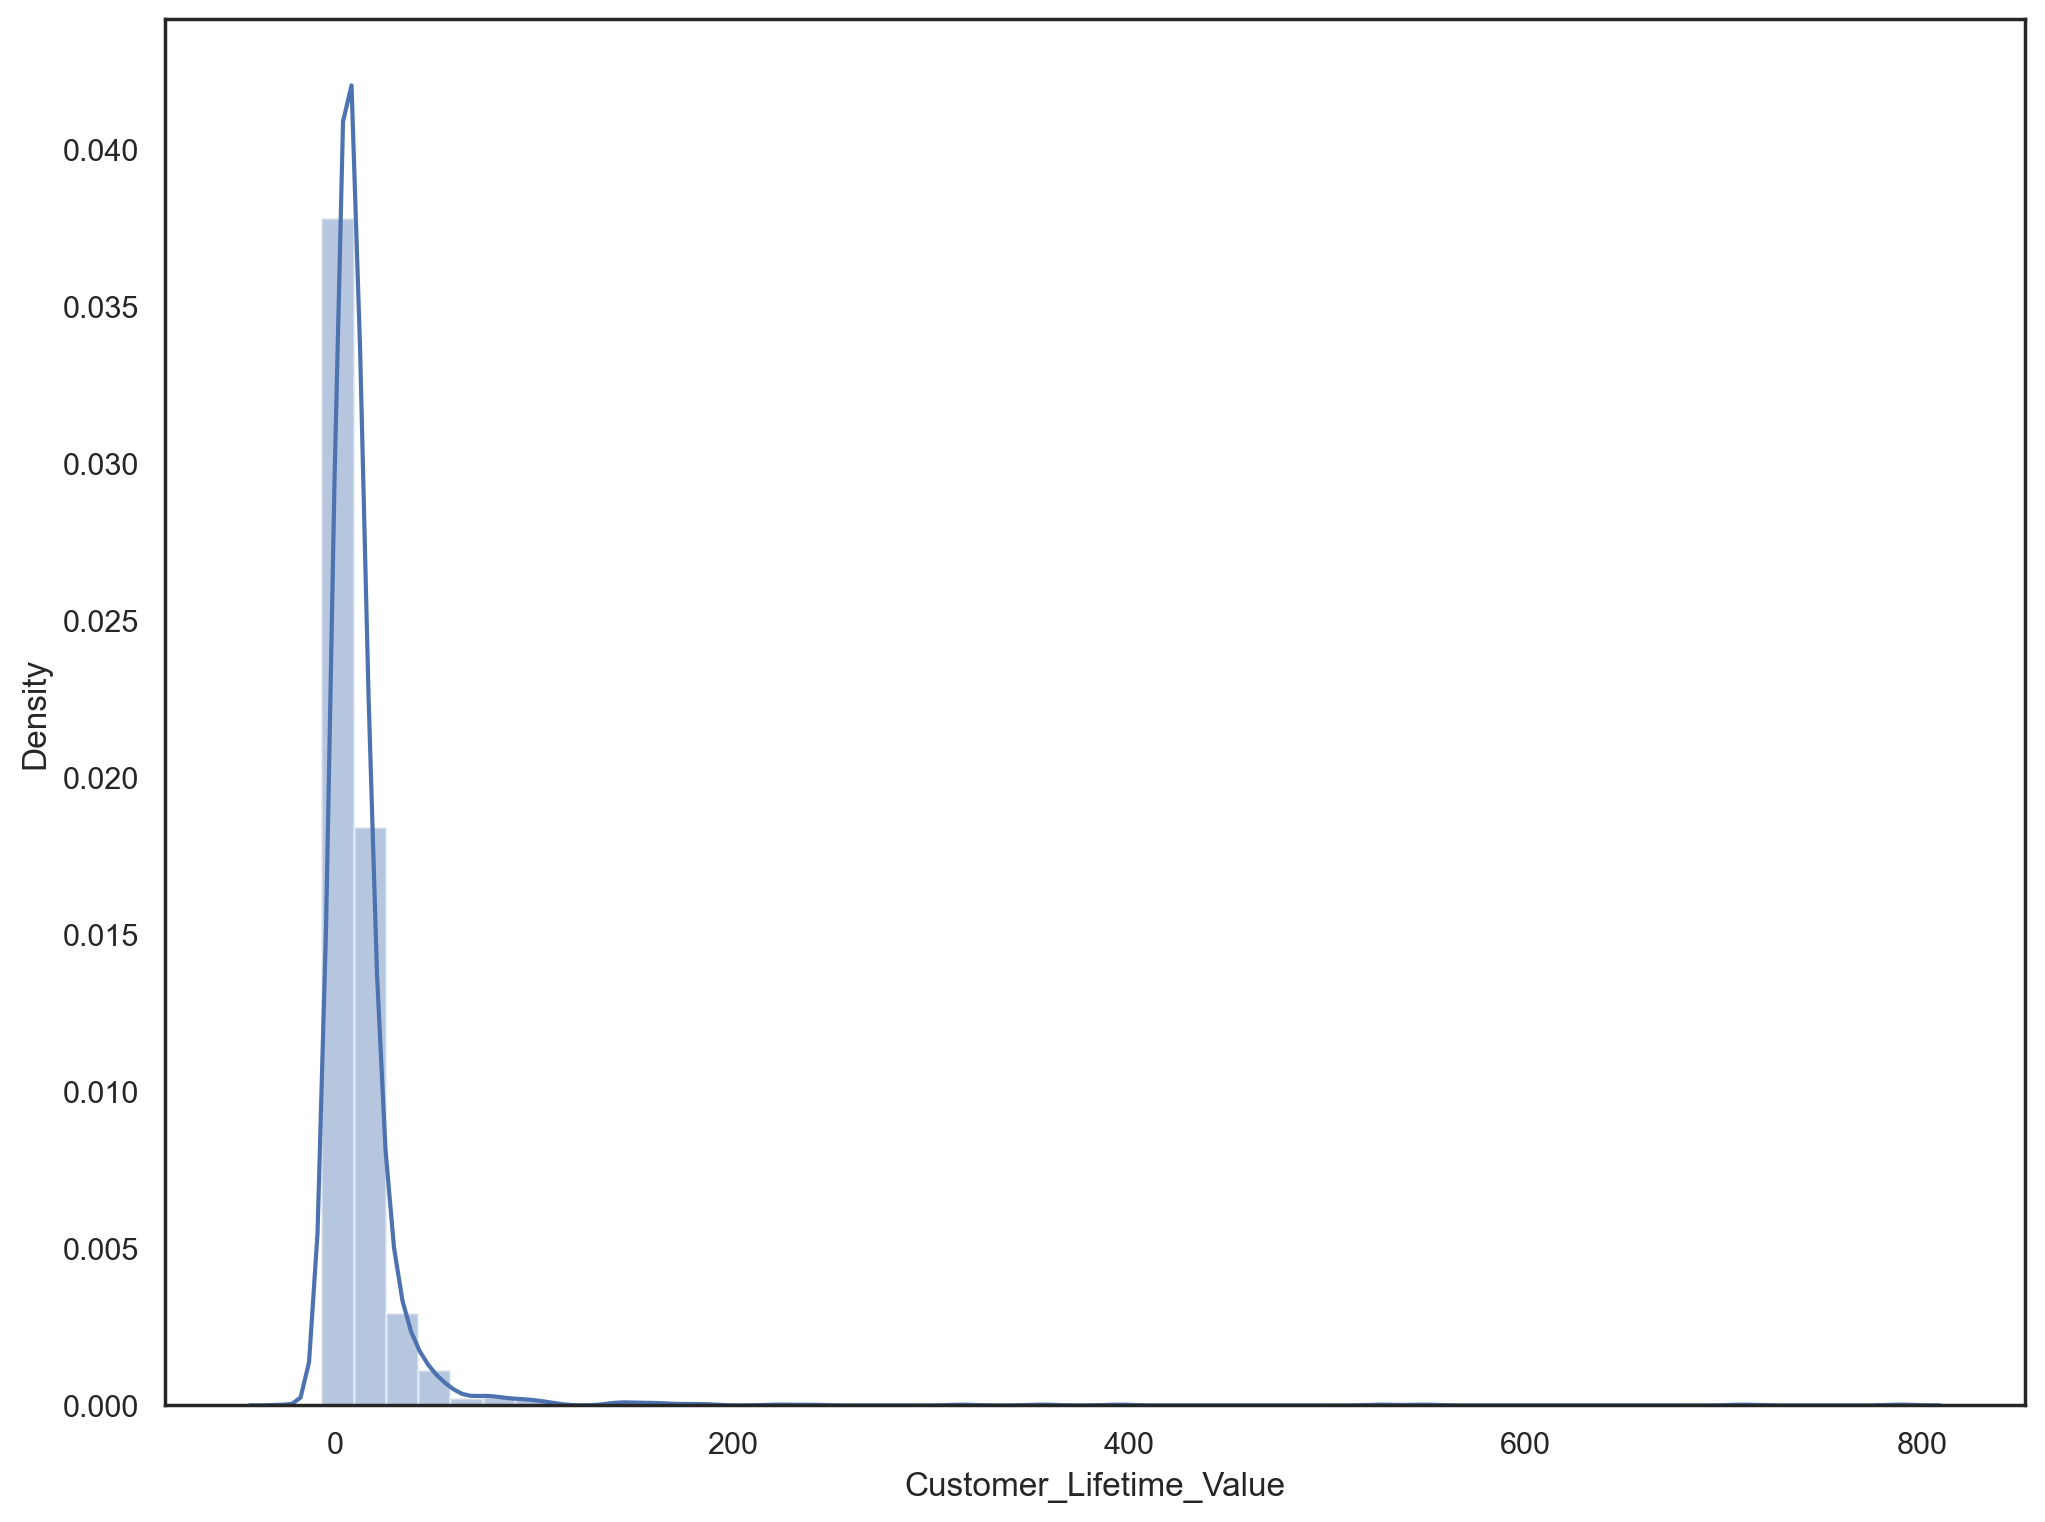

In [495]:
# create a distribution plot to see the count of all the values for Customer_Lifetime_Value
sns.distplot(customer_data['Customer_Lifetime_Value'])

It doesn't make sense to do a log transofmtranraiton of the data actually, as the distro is normal...

It does actually make sense to do some scaling/normalization

    Scaling/Normalization: If the range of values in the feature is significantly different from other features, it can affect the performance of some ML algorithms. In such cases, you can consider scaling or normalizing the feature to bring it within a similar range as other features. Common techniques for scaling include standardization (mean = 0, standard deviation = 1) or min-max scaling (values between 0 and 1).

    Outlier Treatment: If there are outliers present in the feature, they might have a disproportionate effect on the model's performance. You can choose to handle outliers by either removing them if they are due to data errors or transforming them to minimize their impact. Techniques like winsorization (replacing extreme values with a specified percentile value) or logarithmic transformation can help mitigate the influence of outliers.

In [496]:
customer_data['Customer_Lifetime_Value'].describe()

count    2630.000000
mean       12.623527
std        32.088231
min       -23.437059
25%         3.600160
50%         6.901288
75%        12.786534
max       789.154731
Name: Customer_Lifetime_Value, dtype: float64

In a right-skewed distribution, it's advisable to 

<Axes: ylabel='Frequency'>

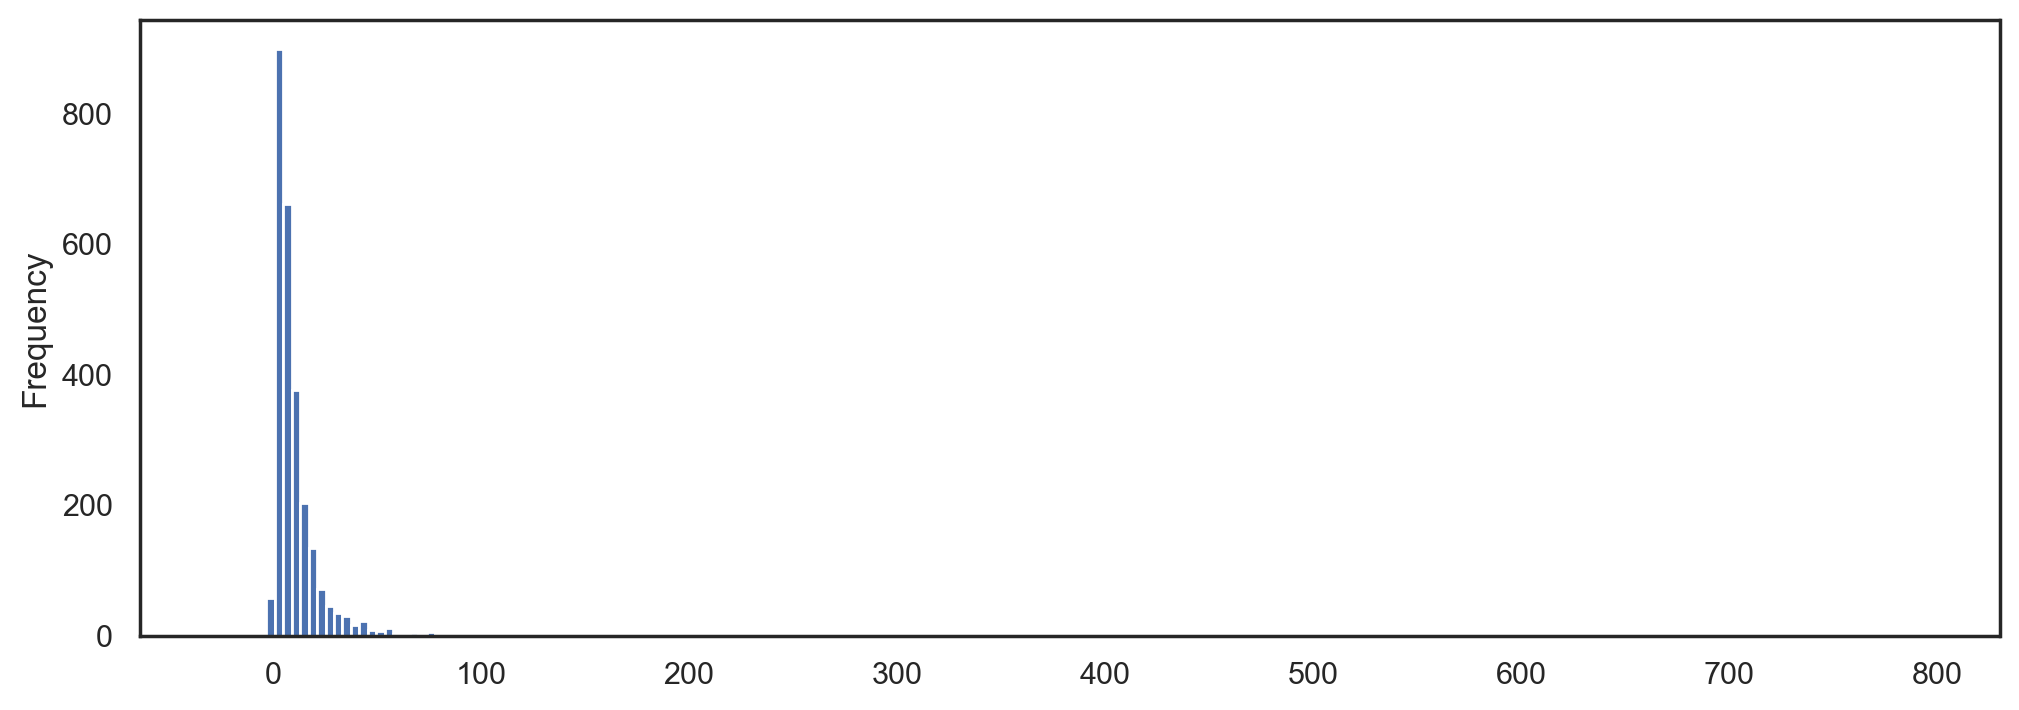

In [497]:
customer_data['Customer_Lifetime_Value'].plot(kind='hist', bins=200, figsize=(12, 4))

In [ ]:
# # Take the Log of Customer Lifetime Value
# customer_data['Log_Customer_Lifetime_Value'] = np.log(customer_data['Customer_Lifetime_Value'])

# # create a distribution plot to see the count of all the values for Customer_Lifetime_Value
# sns.distplot(customer_data['Log_Customer_Lifetime_Value'])

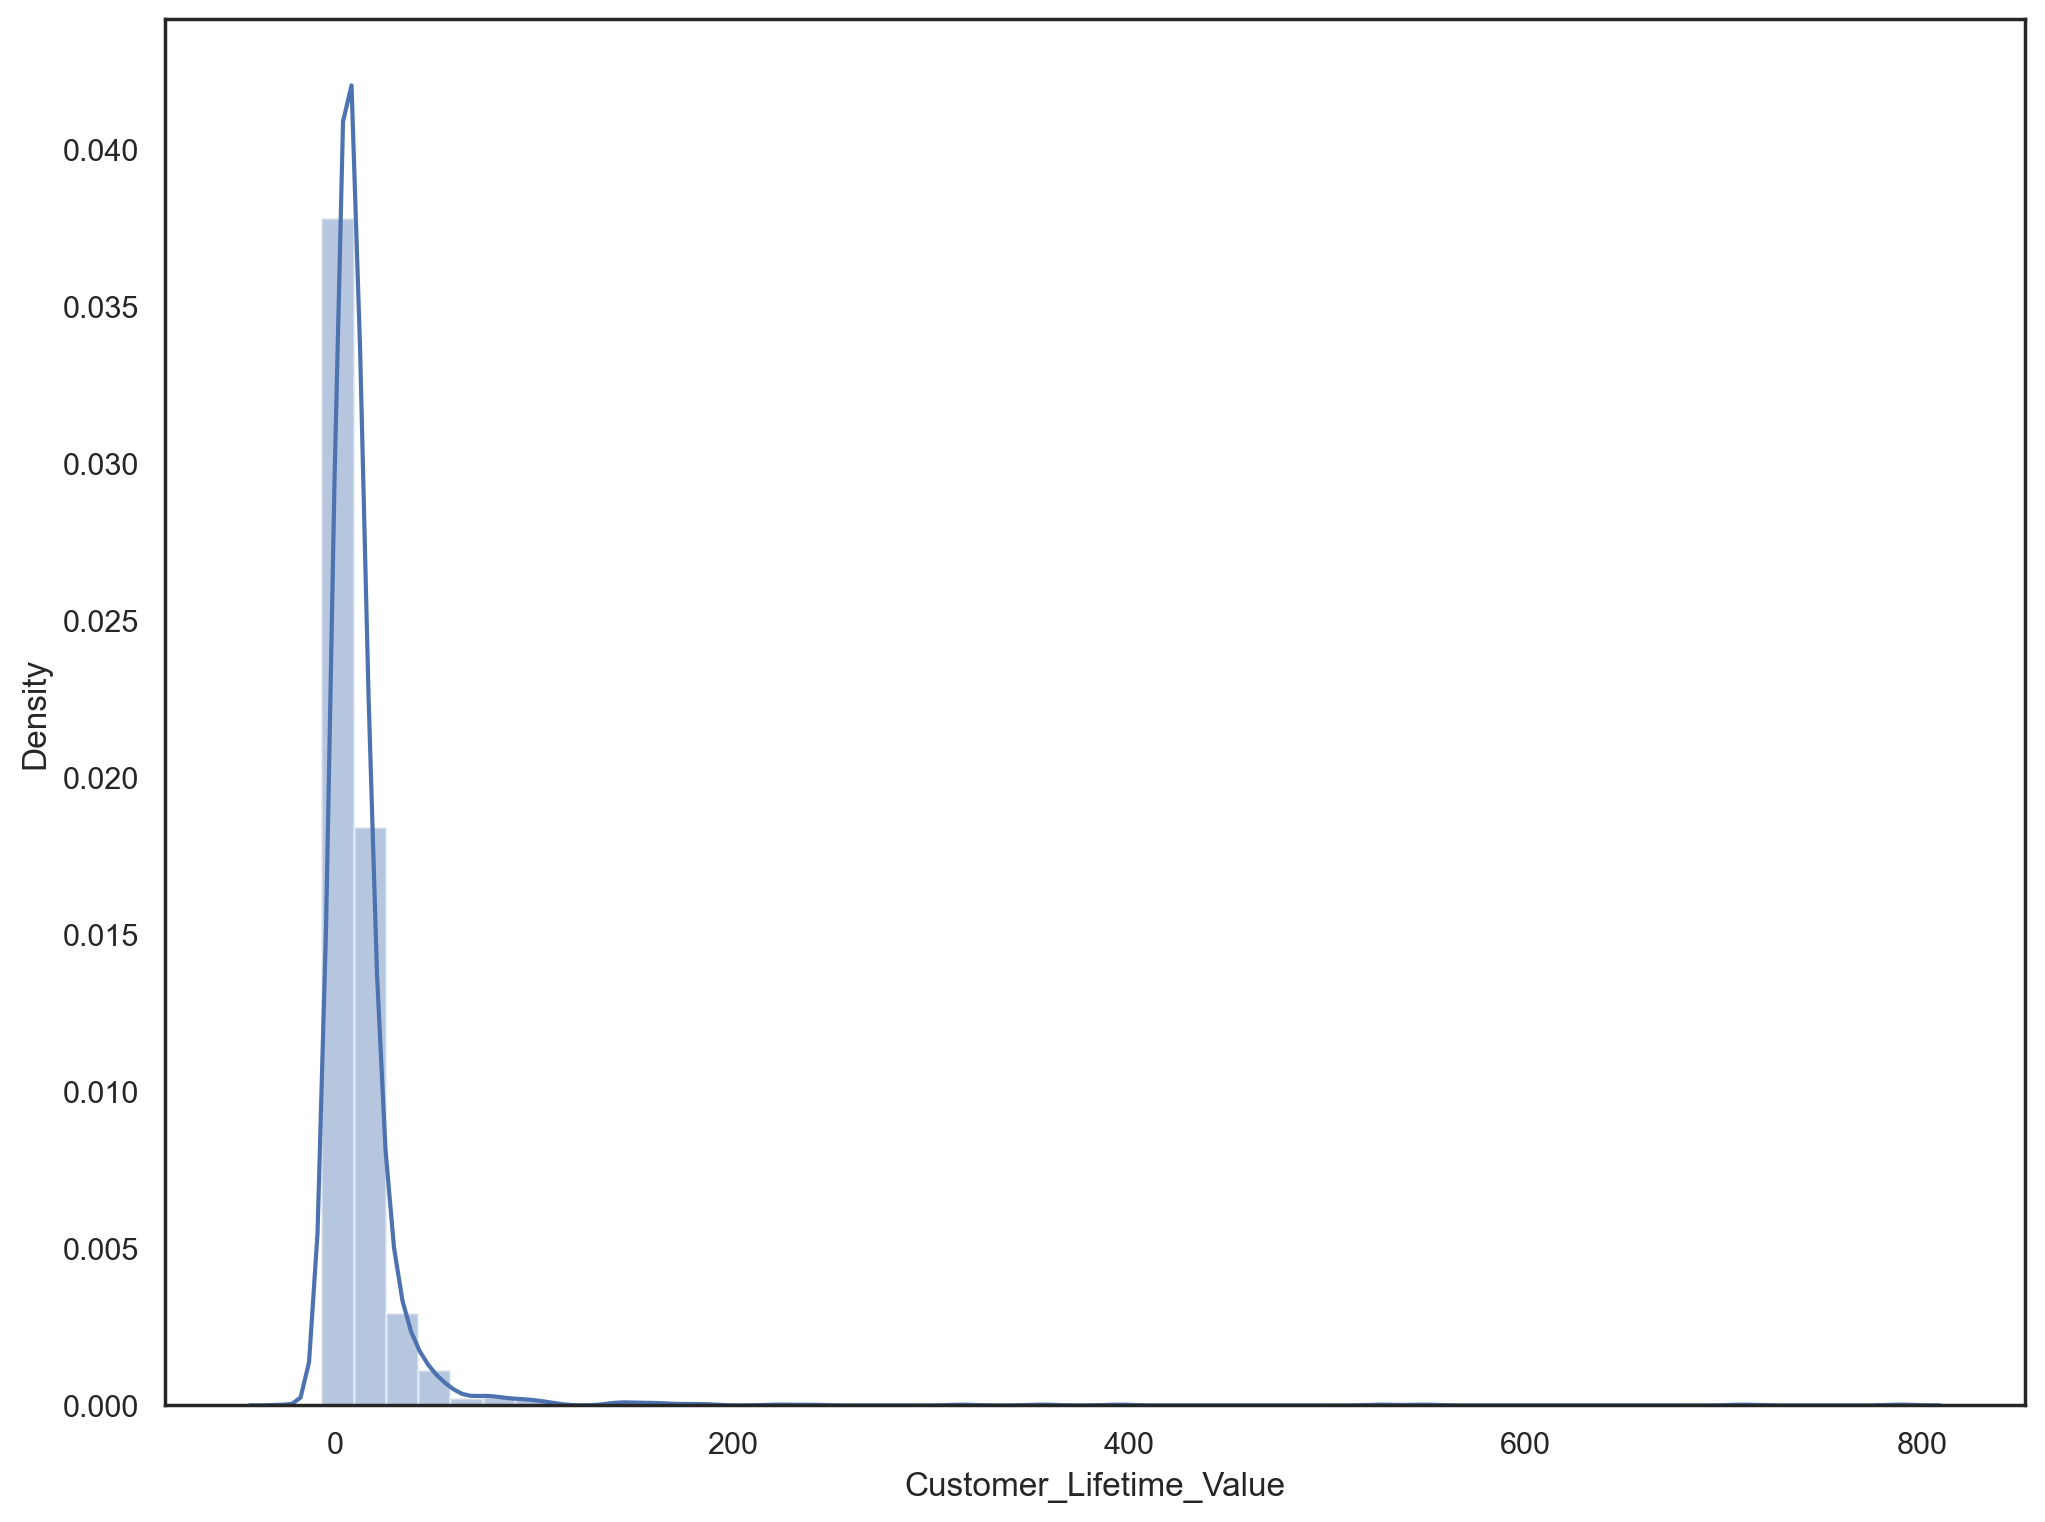

In [ ]:
sns.distplot(customer_data['Customer_Lifetime_Value'])
# plt.xlim(10, 1000)  # Adjust the limits according to the range of values you want to focus on
plt.show();

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.distplot(customer_data['Log_Customer_Lifetime_Value'])
# plt.show();

#### Time Series Data

[ ] Order Date

[X] First Purchase Date  
[X] Last Purchase Date

[ ] year  
[ ] month  
[ ] Quarter

In [ ]:
data.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,is_return,year,month,quarter,Continent,item_color,item_material,Revenue,Item_Category
0,536365,85123A,Hanging Heart T-Light Holder,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,2010,12,4,Europe,White,None,15.3,Home Decor


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


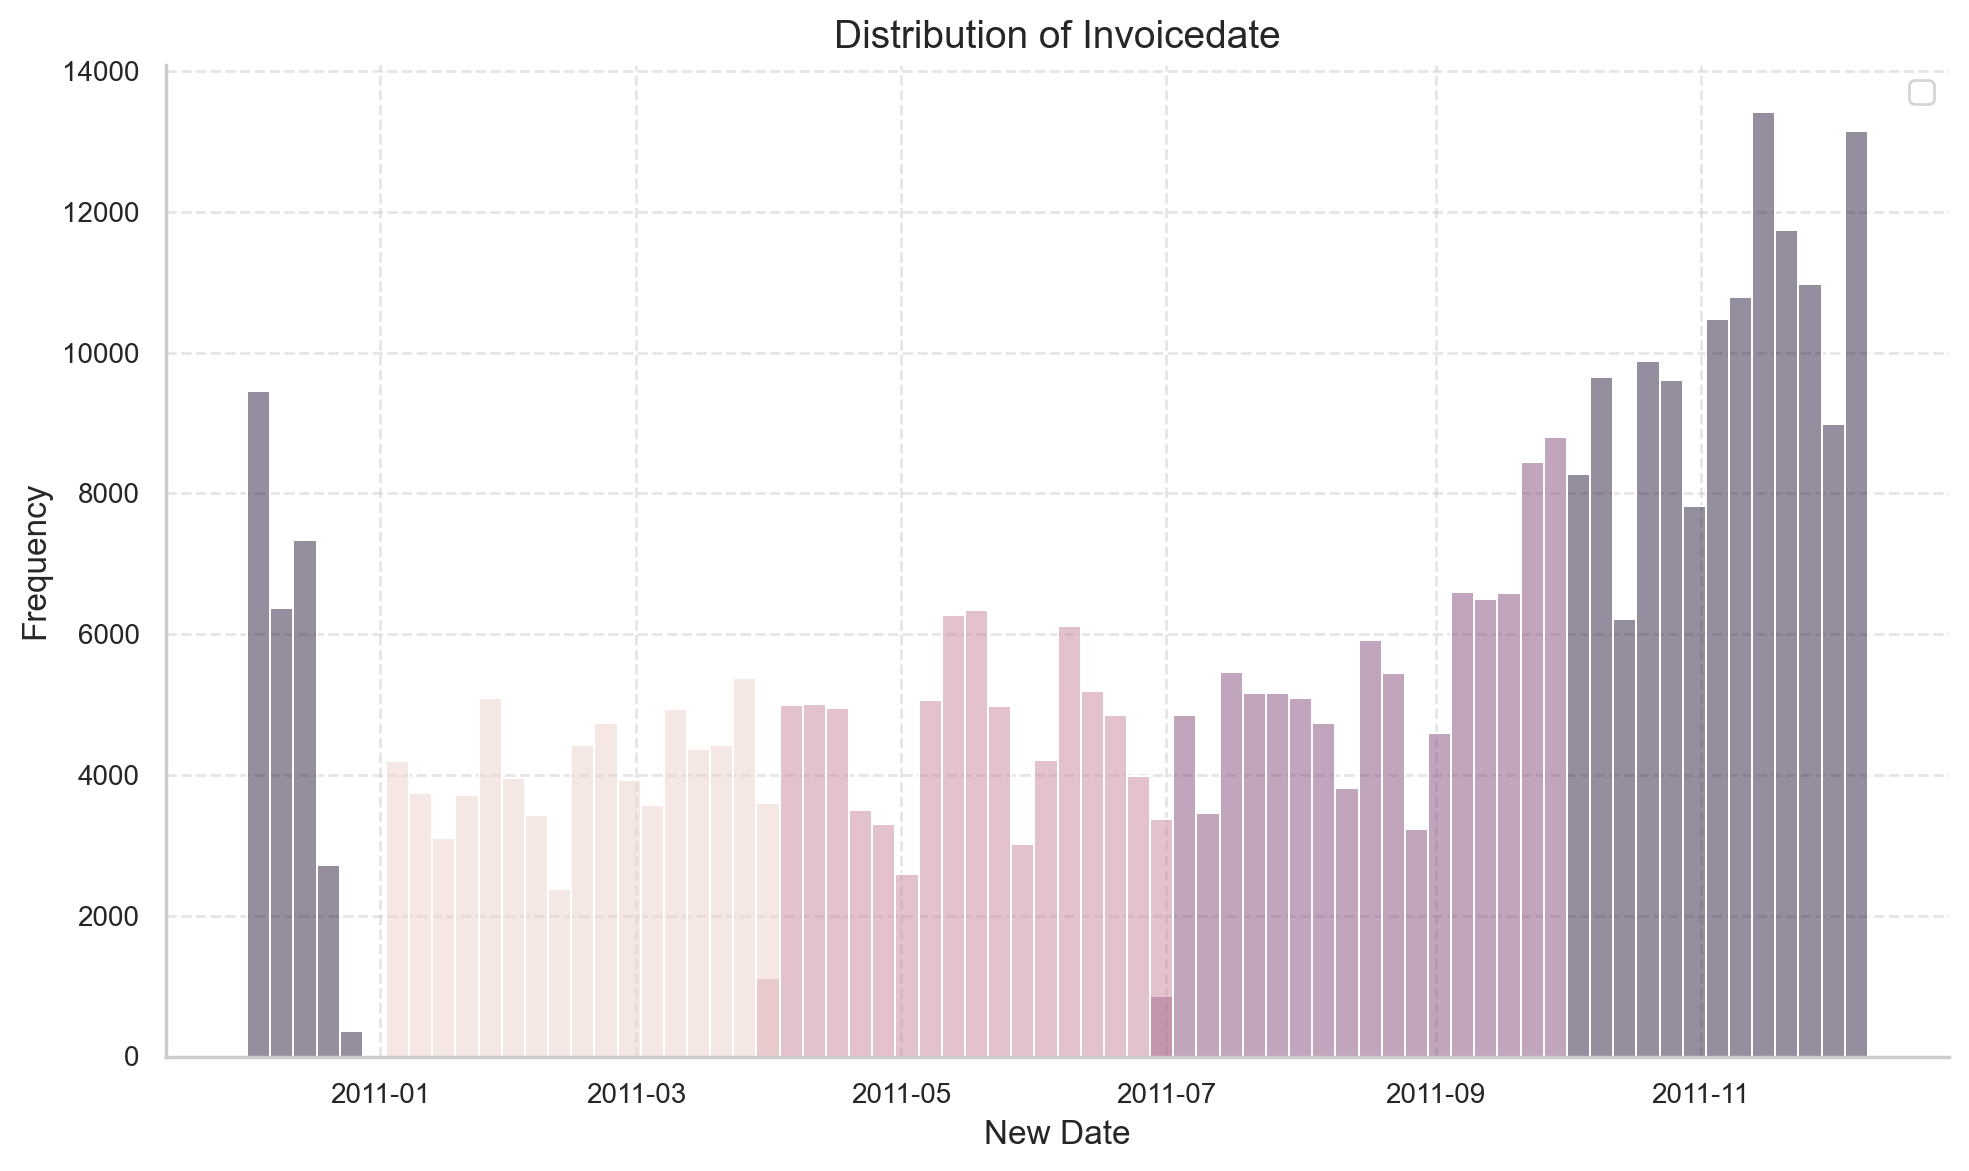

In [ ]:
def plot_time_series(data, column_name, color_column=None):
    # Set the style and color palette
    sns.set_style('whitegrid')

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the time series with color mapping if color_column is provided
    if color_column is not None:
        sns.histplot(data=data, x=column_name, ax=ax, hue=color_column)
    else:
        sns.histplot(data=data, x=column_name, ax=ax)

    # Set axis labels and title
    ax.set_xlabel('New Date', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f"Distribution of {column_name.replace('_', ' ').capitalize()}", fontsize=14)

    # Customize tick labels and grid
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Show the legend if color_column is provided
    if color_column is not None:
        ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show();

plot_time_series(data=data, column_name='InvoiceDate', color_column='quarter')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


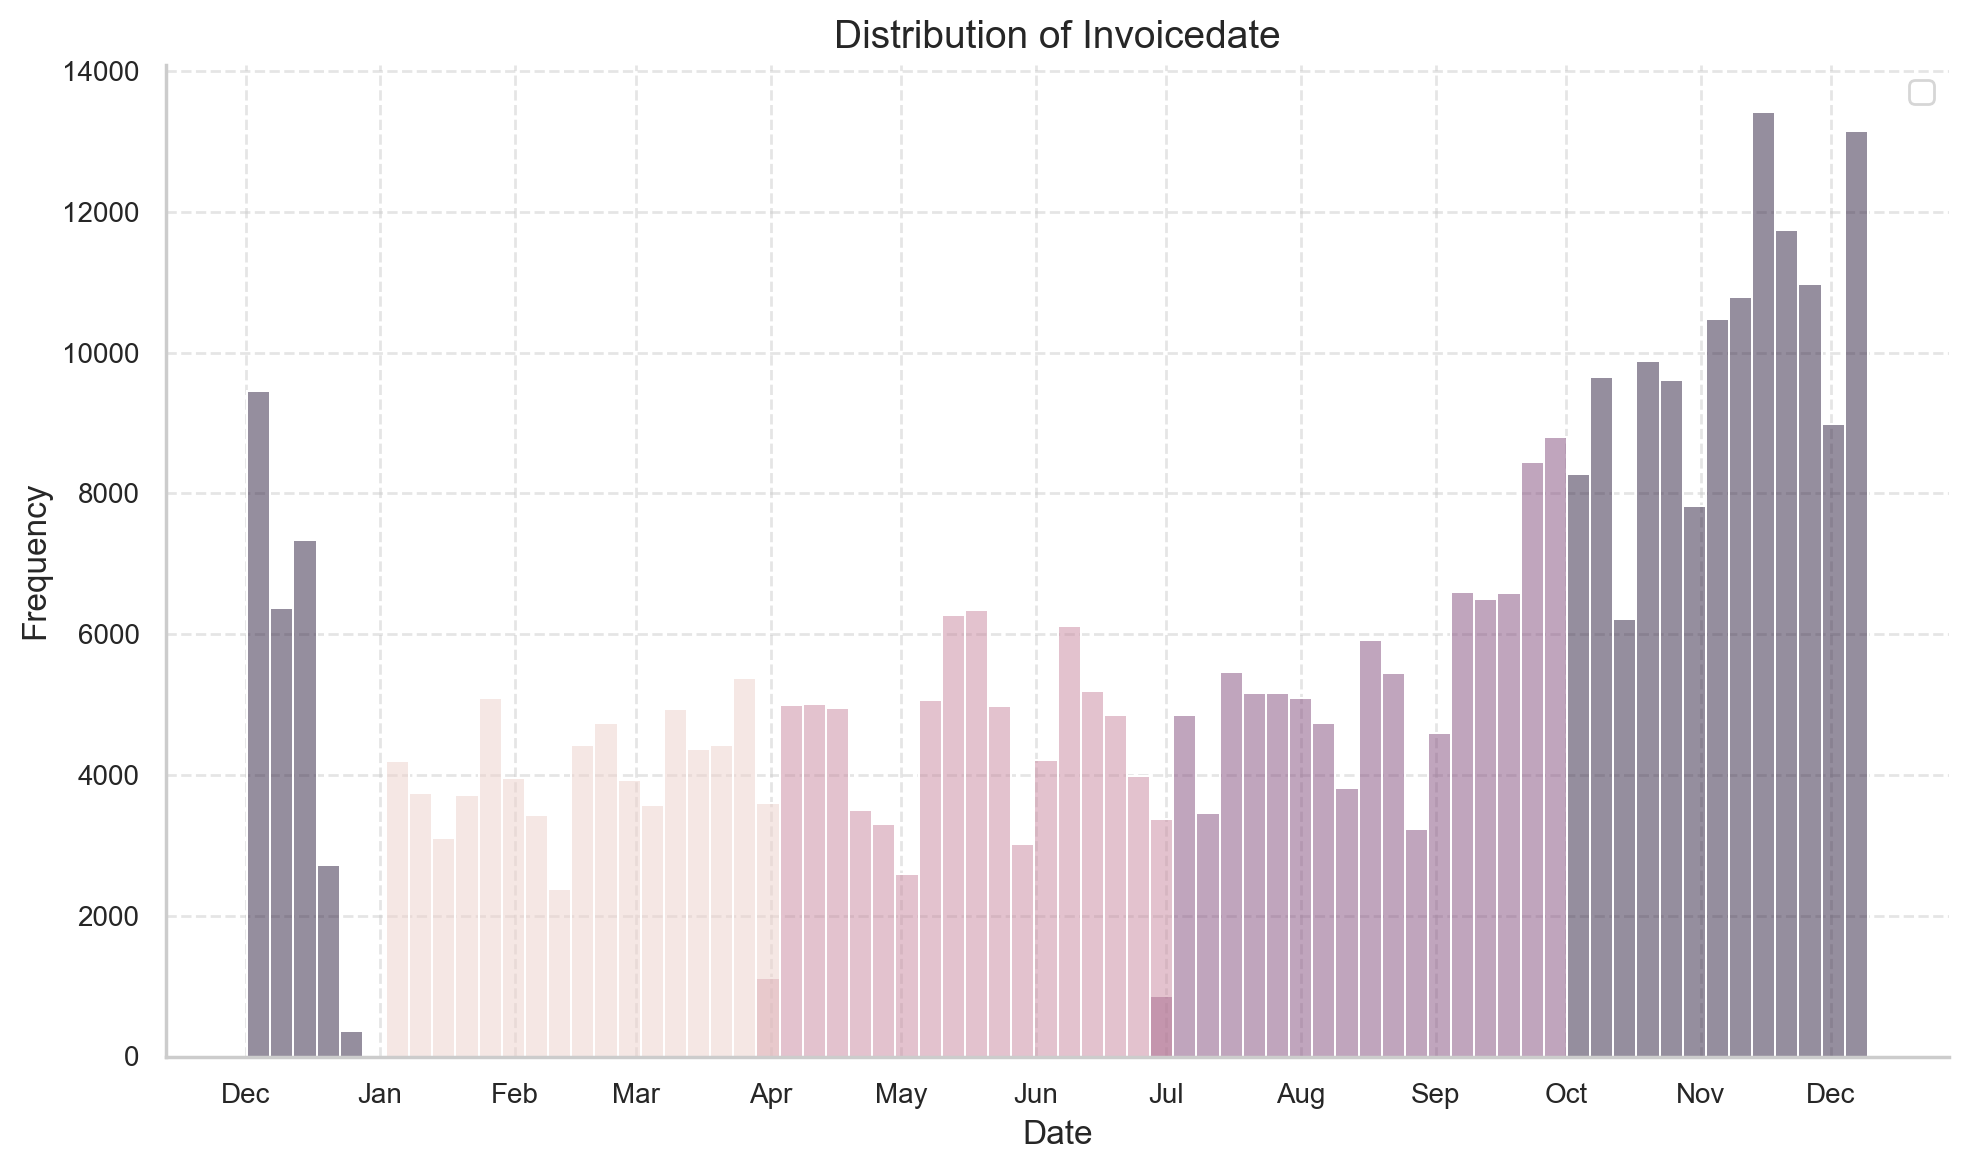

In [ ]:
import matplotlib.dates as mdates

def plot_time_series(data, column_name, color_column=None):
    # Set the style and color palette
    sns.set_style('whitegrid')

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the time series with color mapping if color_column is provided
    if color_column is not None:
        sns.histplot(data=data, x=column_name, ax=ax, hue=color_column)
    else:
        sns.histplot(data=data, x=column_name, ax=ax)

    # Set axis labels and title
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f"Distribution of {column_name.replace('_', ' ').capitalize()}", fontsize=14)

    # Customize tick labels and grid
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Format x-axis tick labels
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Show major ticks at month intervals
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format tick labels as month abbreviations

    # Show the year as a label only when it changes
    ax.xaxis.set_minor_locator(mdates.YearLocator())  # Show minor ticks at year intervals
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))  # Format minor tick labels as new line + year

    # Ensure new year labels are visible
    ax.xaxis.set_tick_params(which='minor', pad=15)  # Increase the padding for new year labels

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Show the legend if color_column is provided
    if color_column is not None:
        ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_time_series(data=data, column_name='InvoiceDate', color_column='quarter')


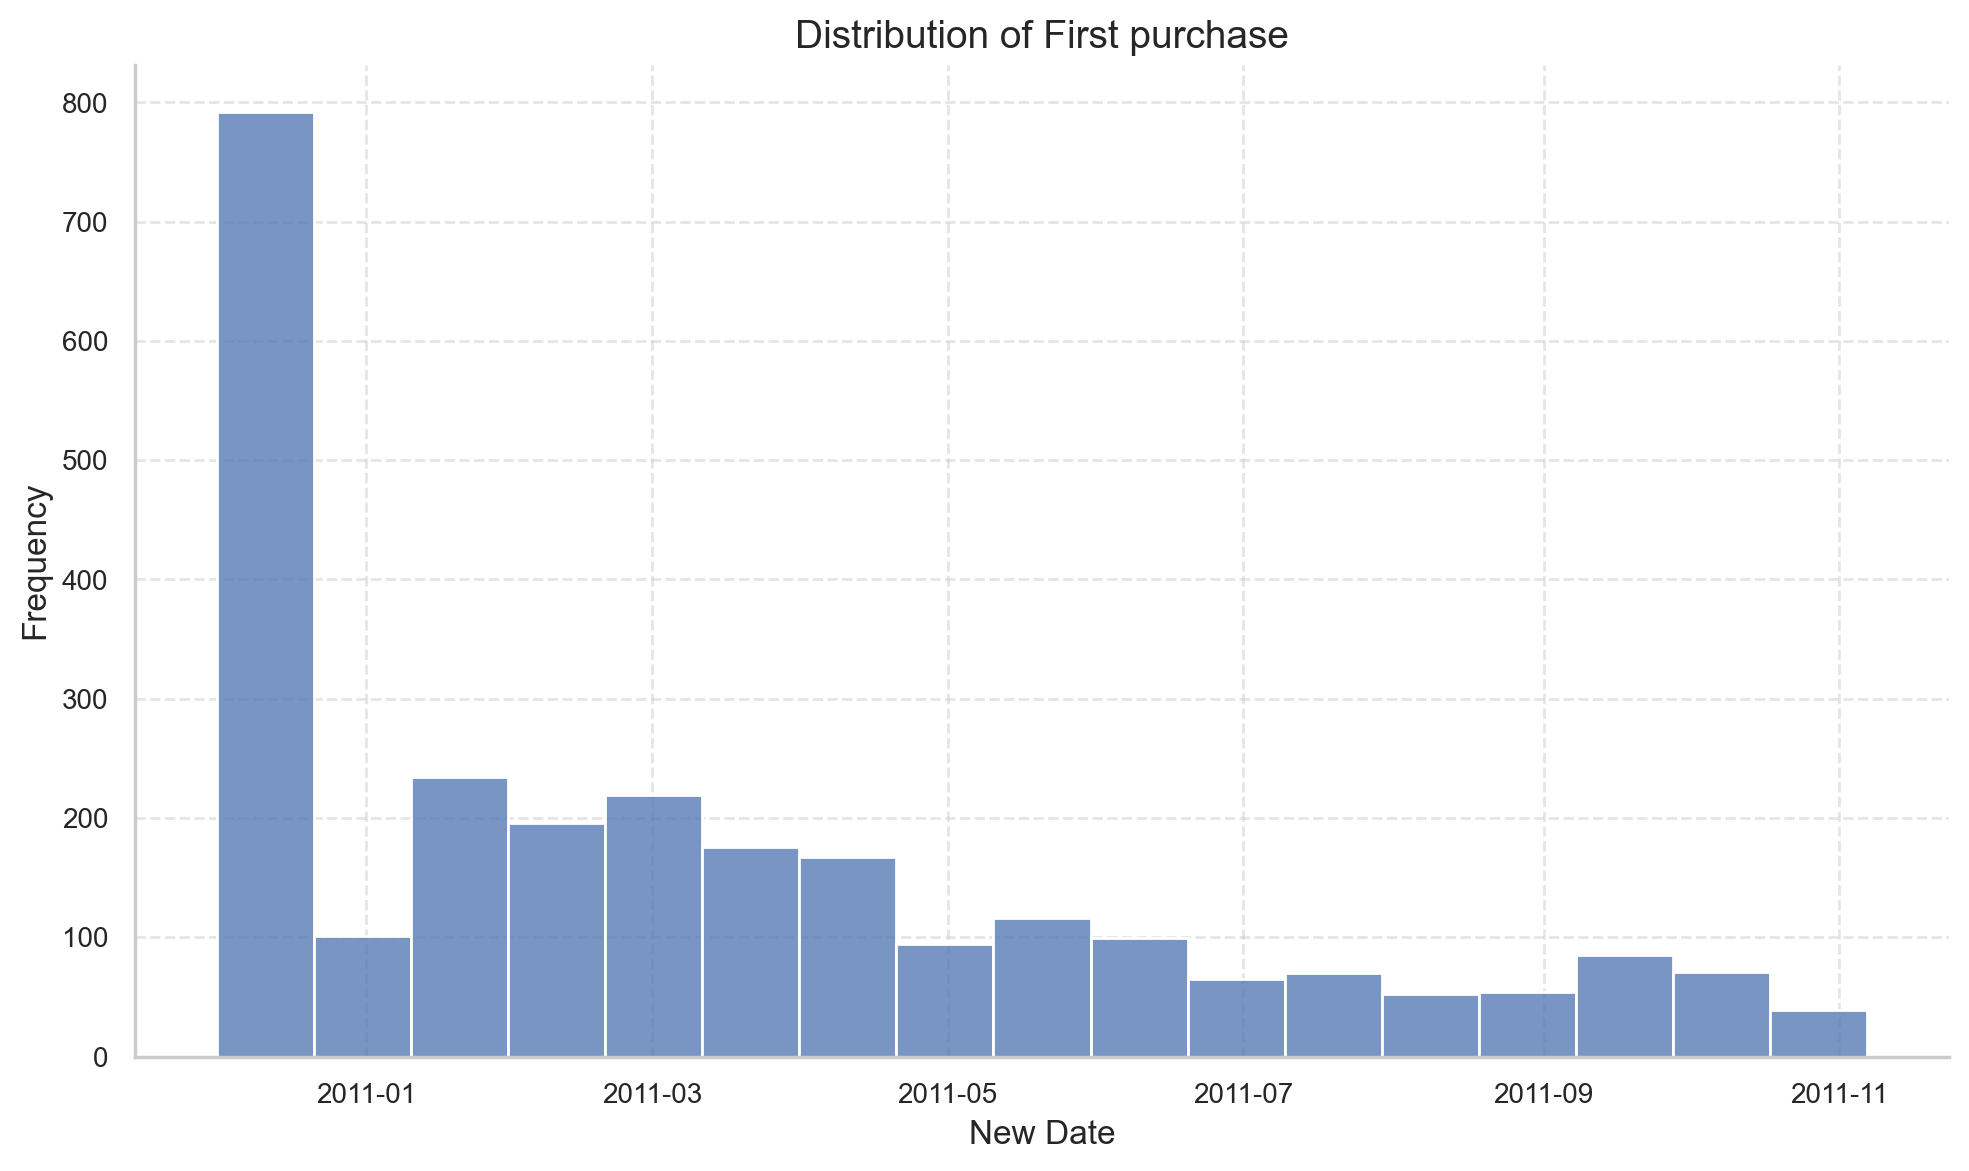

In [ ]:
def plot_time_series(data, column_name, color_column=None):
    # Set the style and color palette
    sns.set_style('whitegrid')

    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the time series with color mapping if color_column is provided
    if color_column is not None:
        sns.histplot(data=data, x=column_name, ax=ax, hue=color_column)
    else:
        sns.histplot(data=data, x=column_name, ax=ax)

    # Set axis labels and title
    ax.set_xlabel('New Date', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f"Distribution of {column_name.replace('_', ' ').capitalize()}", fontsize=14)

    # Customize tick labels and grid
    ax.tick_params(axis='both', which='both', labelsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)

    # Remove the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Show the legend if color_column is provided
    if color_column is not None:
        ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show();

plot_time_series(data=customer_data, column_name='first_purchase')


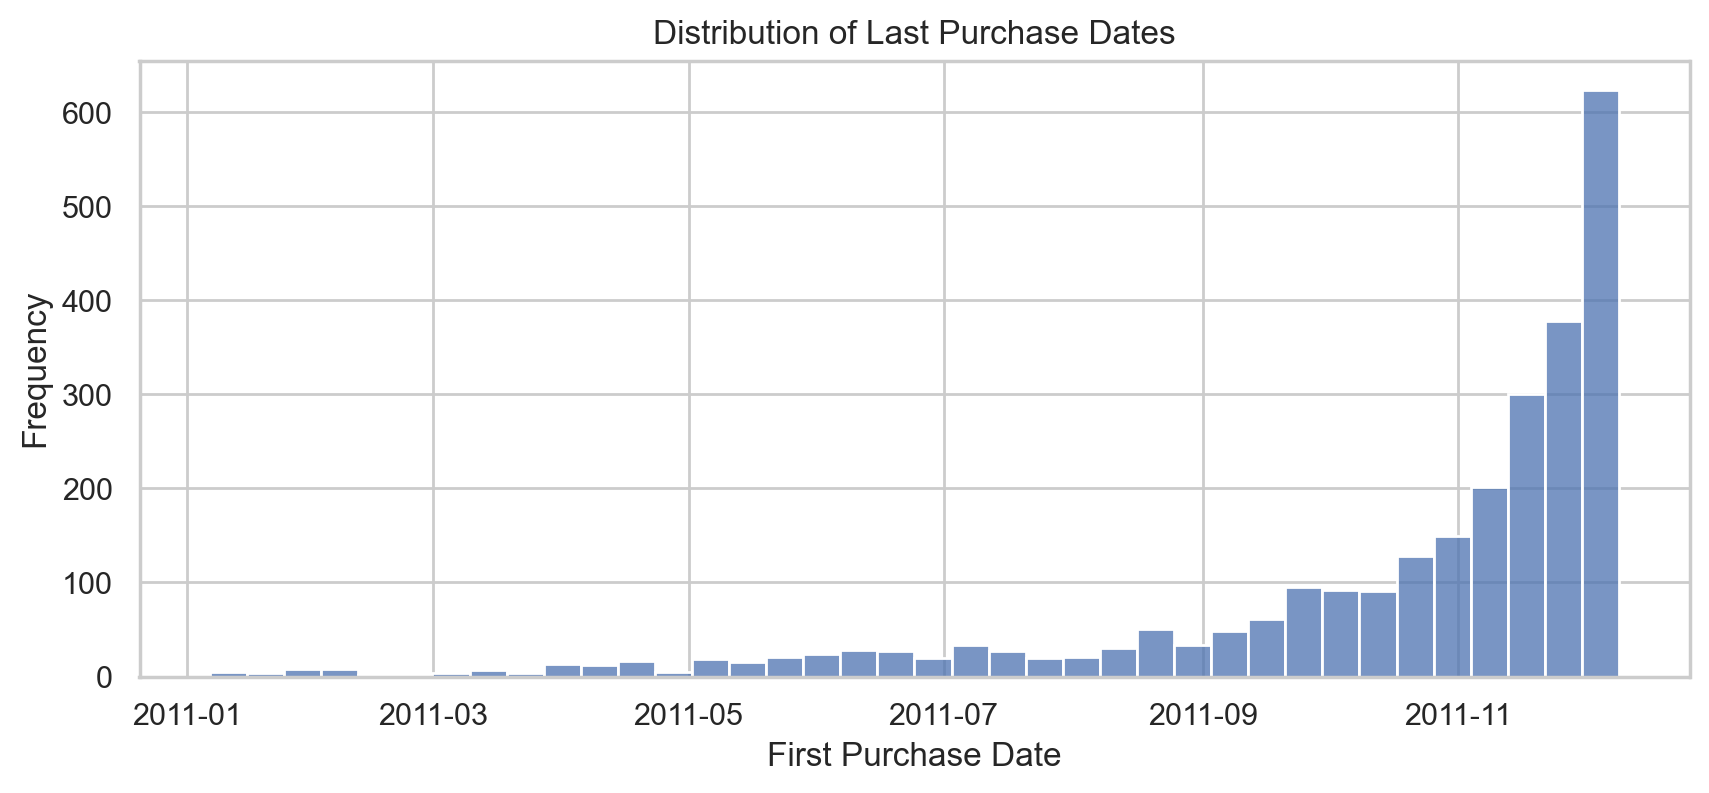

In [ ]:
# Create a histogram of last customer dates
plt.figure(figsize=(10, 4))
sns.histplot(data=customer_data, x='last_purchase')
plt.xlabel('First Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Last Purchase Dates')
plt.show();

### Bivariate Exploration

In [ ]:
# # Create a Column fur UK vs Non UK
# customer_data['is_uk'] = customer_data['Country'].apply(lambda x: 'UK' if x == 'United Kingdom' else 'Non-UK')

KeyError: 'Country'

In [ ]:
# revenue_columns = ['Accessories_Revenue', 'Home_Decor_Revenue', 'Kitchenware_Revenue', 'Lunchware_Revenue', 'Party/Holiday_Revenue', 'Other_Revenue']

# revenue_by_country = customer_data.groupby('Country')[revenue_columns].sum()

# revenue_by_country.plot(kind='bar', stacked=True)
# plt.xlabel('Country')
# plt.ylabel('Revenue')
# plt.title('Stacked Bar Plot: Revenue by Country')
# plt.legend(loc='upper right')
# plt.show();

KeyError: 'Country'

CLV vs. Total Customer Revenue

In [498]:
# # Create a scatterplot of CLV and Total_Customer_Revenue
# plt.scatter(customer_data['Customer_Lifetime'], customer_data['Total_Customer_Revenue'])
# plt.xlabel('Customer Lifetime')
# plt.ylabel('Total Customer Revenue')
# plt.title('Customer Lifetime vs Total Customer Revenue')
# plt.show();

KeyError: 'Total_Customer_Revenue'

In [499]:
# customer_data['Log_Total_Customer_Revenue'] = np.log(customer_data['Total_Customer_Revenue'])

KeyError: 'Total_Customer_Revenue'

In [ ]:
# # Create a scatterplot of CLV and Total_Customer_Revenue
# plt.scatter(customer_data['Total_Customer_Revenue'], customer_data['Log_Customer_Lifetime_Value'])
# plt.xlabel('Total_Customer_Revenue')
# plt.ylabel('Log_Customer_Lifetime_Value')
# plt.title('Customer Lifetime vs Total Customer Revenue')
# plt.show();

### Multivariate Exploration

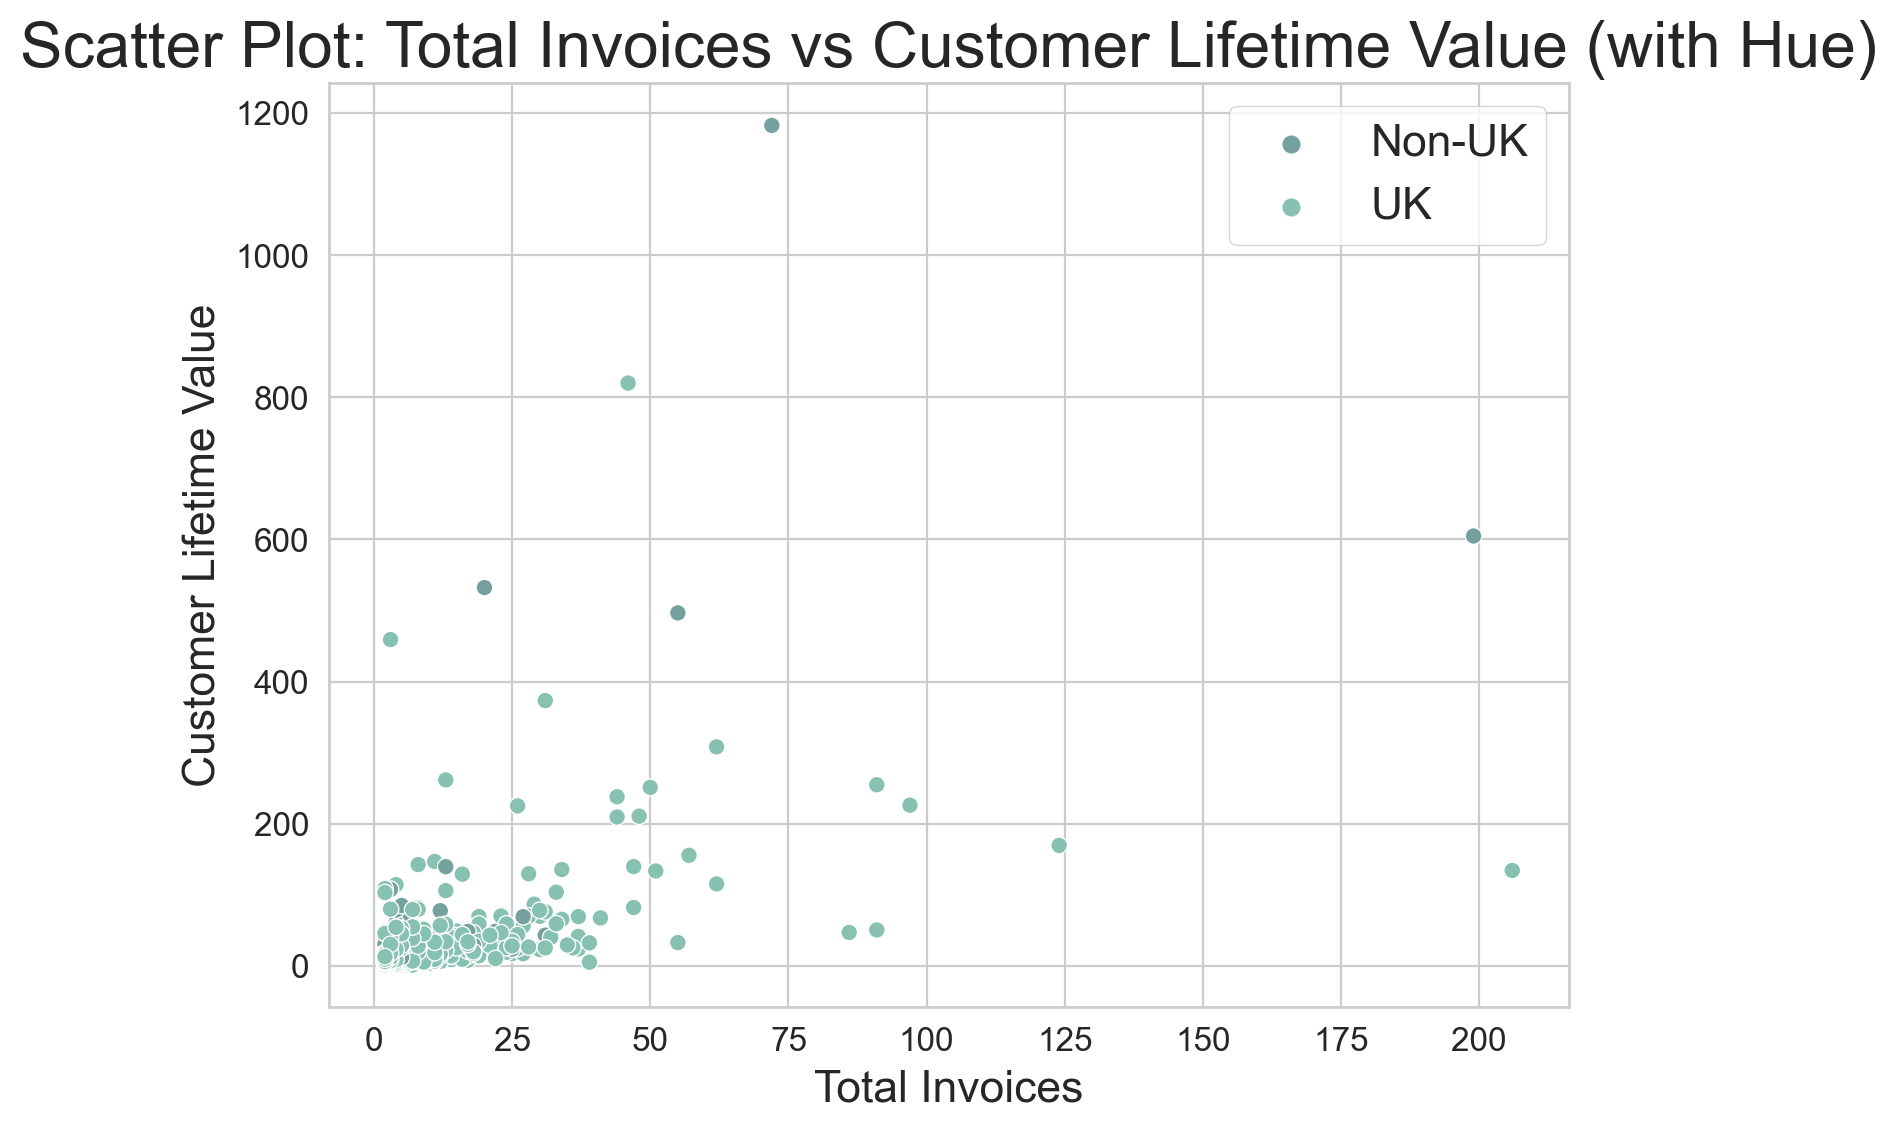

In [ ]:
# import seaborn as sns

# plt.figure(figsize=(8, 6))
# sns.scatterplot(data=customer_data, x='TotalInvoices', y='Customer_Lifetime_Value', hue='is_uk')
# plt.xlabel('Total Invoices')
# plt.ylabel('Customer Lifetime Value')
# plt.title('Scatter Plot: Total Invoices vs Customer Lifetime Value (with Hue)')
# plt.legend()
# plt.show();

# Data Modeling & Analysis

CLF Prediction in Python  
https://medium.com/@ugursavci/customer-lifetime-value-prediction-in-python-89e4a50df12e

In [502]:
customer_data

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,Accessories,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Total_Revenue_Revenue,Other_Revenue,cohort_month
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.00,11.993288,11.808219,2010-12,79.80,1439.44,589.08,0.0,359.93,2468.25,1.841750e+03,2010-12
1,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,1437.24,9.289810,5.096596,2010-12,0.00,0.00,63.60,0.0,270.00,333.60,1.103640e+03,2010-12
4,12352.0,2011-02-16 12:33:00,2011-11-03 14:37:00,1265.41,8.545099,4.866962,2011-02,66.60,225.35,323.18,23.4,182.75,821.28,4.441300e+02,2011-02
8,12356.0,2011-01-18 09:50:00,2011-11-17 08:40:00,2487.43,9.953433,8.236523,2011-01,121.12,12.75,1075.13,0.0,714.71,1923.71,5.637200e+02,2011-01
10,12358.0,2011-07-12 10:04:00,2011-12-08 10:26:00,928.06,4.895880,6.228591,2011-07,15.00,785.40,44.94,0.0,82.72,928.06,-2.842171e-14,2011-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4268,18273.0,2011-03-27 11:22:00,2011-12-07 13:16:00,204.00,8.380596,0.800000,2011-03,0.00,204.00,0.00,0.0,0.00,204.00,0.000000e+00,2011-03
4271,18277.0,2011-01-25 12:34:00,2011-10-12 15:22:00,97.63,8.546103,0.375500,2011-01,0.00,44.20,0.00,0.0,7.73,51.93,4.570000e+01,2011-01
4275,18282.0,2011-08-05 13:35:00,2011-12-02 11:43:00,176.60,3.907176,1.496610,2011-08,0.00,12.47,40.94,0.0,84.69,138.10,3.850000e+01,2011-08
4276,18283.0,2011-01-06 14:14:00,2011-12-06 12:02:00,2039.58,10.970520,6.124865,2011-01,96.00,666.04,174.83,354.9,312.14,1603.91,4.356700e+02,2011-01


In [503]:
import lifetimes
from lifetimes import BetaGeoFitter # BG/NBD
from lifetimes import GammaGammaFitter # Gamma-Gamma Model
from lifetimes.plotting import plot_frequency_recency_matrix

In [516]:
data = data[data['is_return'] == 0]

In [517]:
clv = lifetimes.utils.summary_data_from_transaction_data(data,'CustomerID','InvoiceDate','Revenue',observation_period_end='2011-12-09')

In [518]:
clv['T'].value_counts().sort_index()

0.0       1
1.0       4
2.0       5
3.0       9
4.0       7
         ..
368.0    70
369.0    69
371.0    46
372.0    93
373.0    95
Name: T, Length: 305, dtype: int64

In [519]:
# We only want customers who've shopped 3+ Times
clv = clv[clv['frequency']>2] 

In [520]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(clv['frequencay'], clv['recency'], clv['T'])

<lifetimes.BetaGeoFitter: fitted with 1410 subjects, a: 0.00, alpha: 107.19, b: 0.00, r: 2.68>

Expected # of Purchases in < 6 Months

In [521]:
t = 180 # 30 day period
clv['expected_purchases_in_six_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, clv['frequency'], clv['recency'], clv['T'])
clv.sort_values(by='expected_purchases_in_six_months',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purchases_in_six_months
CustomerID,,,,,
14911.0,130.0,372.0,373.0,1075.241923,49.736141
12748.0,112.0,373.0,373.0,282.552054,42.988765
17841.0,111.0,372.0,373.0,360.032072,42.613911
15311.0,89.0,373.0,373.0,676.210899,34.367118
14606.0,87.0,372.0,373.0,134.975057,33.617410


The most likely value for each transaction (Gamma-Gamma Model)

In [522]:
clv[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.170304
monetary_value,0.170304,1.000000


In [523]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv["frequency"],
        clv["monetary_value"])

<lifetimes.GammaGammaFitter: fitted with 1410 subjects, p: 3.73, q: 0.32, v: 3.68>

In [524]:
clv['6_months_clv'] = ggf.customer_lifetime_value(bgf,
                                   clv["frequency"],
                                   clv["recency"],
                                   clv["T"],
                                   clv["monetary_value"],
                                   time=6,
                                   freq='D',
                                   discount_rate=0.01)


In [525]:
clv.sort_values('6_months_clv',ascending=False).head()

,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv
CustomerID,,,,,,
14646.0,44.0,353.0,354.0,6342.774091,18.219590,112086.608275
18102.0,25.0,367.0,367.0,9349.477200,10.507744,95587.452081
17450.0,26.0,359.0,367.0,7398.536538,10.887342,78352.213430
12415.0,14.0,313.0,337.0,8396.653571,6.759843,55545.930305
14096.0,16.0,97.0,101.0,3327.985000,16.152005,52519.711882


Currently this just divides Customers into 4 equal groups. With Customer Segmentation, we can predict the correct number of groups

In [526]:
clv['Segment'] =  pd.qcut(clv['6_months_clv'],4,labels = ['Hibernating','Need Attention','Loyal Customers', 'Champions'])

In [527]:
clv.reset_index()

,CustomerID,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv,Segment
0,12347.0,6.0,365.0,367.0,599.701667,3.295395,1970.348608,Loyal Customers
1,12348.0,3.0,283.0,358.0,261.480000,2.198327,593.690882,Hibernating
2,12352.0,6.0,260.0,296.0,181.540000,3.875704,703.144886,Hibernating
3,12359.0,3.0,274.0,331.0,1920.843333,2.333783,4611.322205,Champions
4,12362.0,9.0,292.0,295.0,478.125556,5.228001,2466.154533,Champions
...,...,...,...,...,...,...,...,...
1405,18245.0,4.0,348.0,355.0,550.332500,2.602049,1451.236171,Loyal Customers
1406,18257.0,6.0,257.0,296.0,334.871667,3.875704,1295.031644,Loyal Customers
1407,18260.0,5.0,186.0,358.0,479.530000,2.972210,1430.642788,Loyal Customers
1408,18272.0,5.0,244.0,246.0,487.752000,3.914735,1916.576742,Loyal Customers


In [528]:
clv.head()

,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv,Segment
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,599.701667,3.295395,1970.348608,Loyal Customers
12348.0,3.0,283.0,358.0,261.480000,2.198327,593.690882,Hibernating
12352.0,6.0,260.0,296.0,181.540000,3.875704,703.144886,Hibernating
12359.0,3.0,274.0,331.0,1920.843333,2.333783,4611.322205,Champions
12362.0,9.0,292.0,295.0,478.125556,5.228001,2466.154533,Champions


In [530]:
# merge clv with customer data
customer_data = pd.merge(customer_data, clv.reset_index(), on='CustomerID', how='left')

In [535]:
customer_data.describe()

,CustomerID,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Accessories,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Total_Revenue_Revenue,Other_Revenue,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv
count,2630.00000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,2630.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000,1404.000000
mean,15270.68289,2867.375031,7.193285,12.623527,95.614099,873.677274,331.509278,106.838399,372.203403,1779.842453,1087.532578,7.453704,267.195157,299.583333,453.628322,4.503646,2310.058222
std,1721.27382,10509.539591,3.412151,32.088231,449.167782,3621.436371,1743.968701,784.595044,1277.942669,6567.161081,4196.924065,8.723764,85.452318,79.195443,573.734305,3.318396,5781.674868
min,12347.00000,-796.860000,1.011269,-23.437059,-106.200000,-72.000000,-225.900000,-54.450000,-255.000000,-404.100000,-392.760000,3.000000,34.000000,37.000000,6.783333,2.129656,17.835136
25%,13798.25000,631.925000,4.301999,3.600160,0.000000,112.835000,30.000000,0.000000,45.732500,321.145000,254.797500,3.000000,214.750000,262.000000,220.064833,2.879308,791.717921
50%,15219.00000,1202.870000,7.420093,6.901288,19.800000,280.650000,93.850000,0.000000,132.385000,675.880000,477.415000,5.000000,282.500000,324.000000,330.348077,3.634549,1290.087231
75%,16777.75000,2467.705000,10.306087,12.786534,74.340000,687.105000,268.862500,49.500000,318.732500,1493.147500,967.155000,8.000000,343.250000,365.000000,496.092833,5.151154,2159.400149
max,18287.00000,278571.620000,12.258043,789.154731,11730.620000,107982.290000,64175.650000,35811.900000,26674.210000,174130.520000,132338.610000,130.000000,373.000000,373.000000,9349.477200,49.736141,112086.608275


In [534]:
customer_data.head(1)

,CustomerID,first_purchase,last_purchase,total_revenue,Customer_Lifetime,Customer_Lifetime_Value,Cohort_Group,Accessories,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Total_Revenue_Revenue,Other_Revenue,cohort_month,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv,Segment
0,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,4310.0,11.993288,11.808219,2010-12,79.8,1439.44,589.08,0.0,359.93,2468.25,1841.75,2010-12,6.0,365.0,367.0,599.701667,3.295395,1970.348608,Loyal Customers


In [533]:
# # Export customer_data  as Excel
# customer_data.to_excel('customer_data_CLV_Groupings.xlsx', index=False)

#### # Stuff from Towards Data Science Article

In [ ]:
data.head(1)

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,quarter,Continent,TotalInvoices,item_color,item_material,Revenue,first_purchase,last_purchase,Total_Customer_Revenue,Customer_Lifetime,Customer_Lifetime_Value,Item_Category,Accessories,Home Decor,Kitchenware,Lunchware,Party/Holiday
0,536365,Hanging Heart T-Light Holder,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010,12,4,Europe,34,White,None,15.3,2010-12-01 10:51:00,2010-12-02 09:44:00,5391.21,0.031326,inf,Home Decor,0.0,2457.4,394.32,0.0,0.0


Forecasting Experiments: Grouping by Individual Day

In [ ]:
# Group By Invoice Date and Sum the Revenue
data_by_date = data.groupby('InvoiceDate')['Revenue'].sum().reset_index()

In [ ]:
data_by_date.tail()

,InvoiceDate,Revenue
17063,9/9/2011 8:48,344.90
17064,9/9/2011 9:03,205.67
17065,9/9/2011 9:13,922.70
17066,9/9/2011 9:38,296.64
17067,9/9/2011 9:52,985.62


In [ ]:
data_by_date.tail()

,InvoiceDate,Revenue
17063,9/9/2011 8:48,344.90
17064,9/9/2011 9:03,205.67
17065,9/9/2011 9:13,922.70
17066,9/9/2011 9:38,296.64
17067,9/9/2011 9:52,985.62


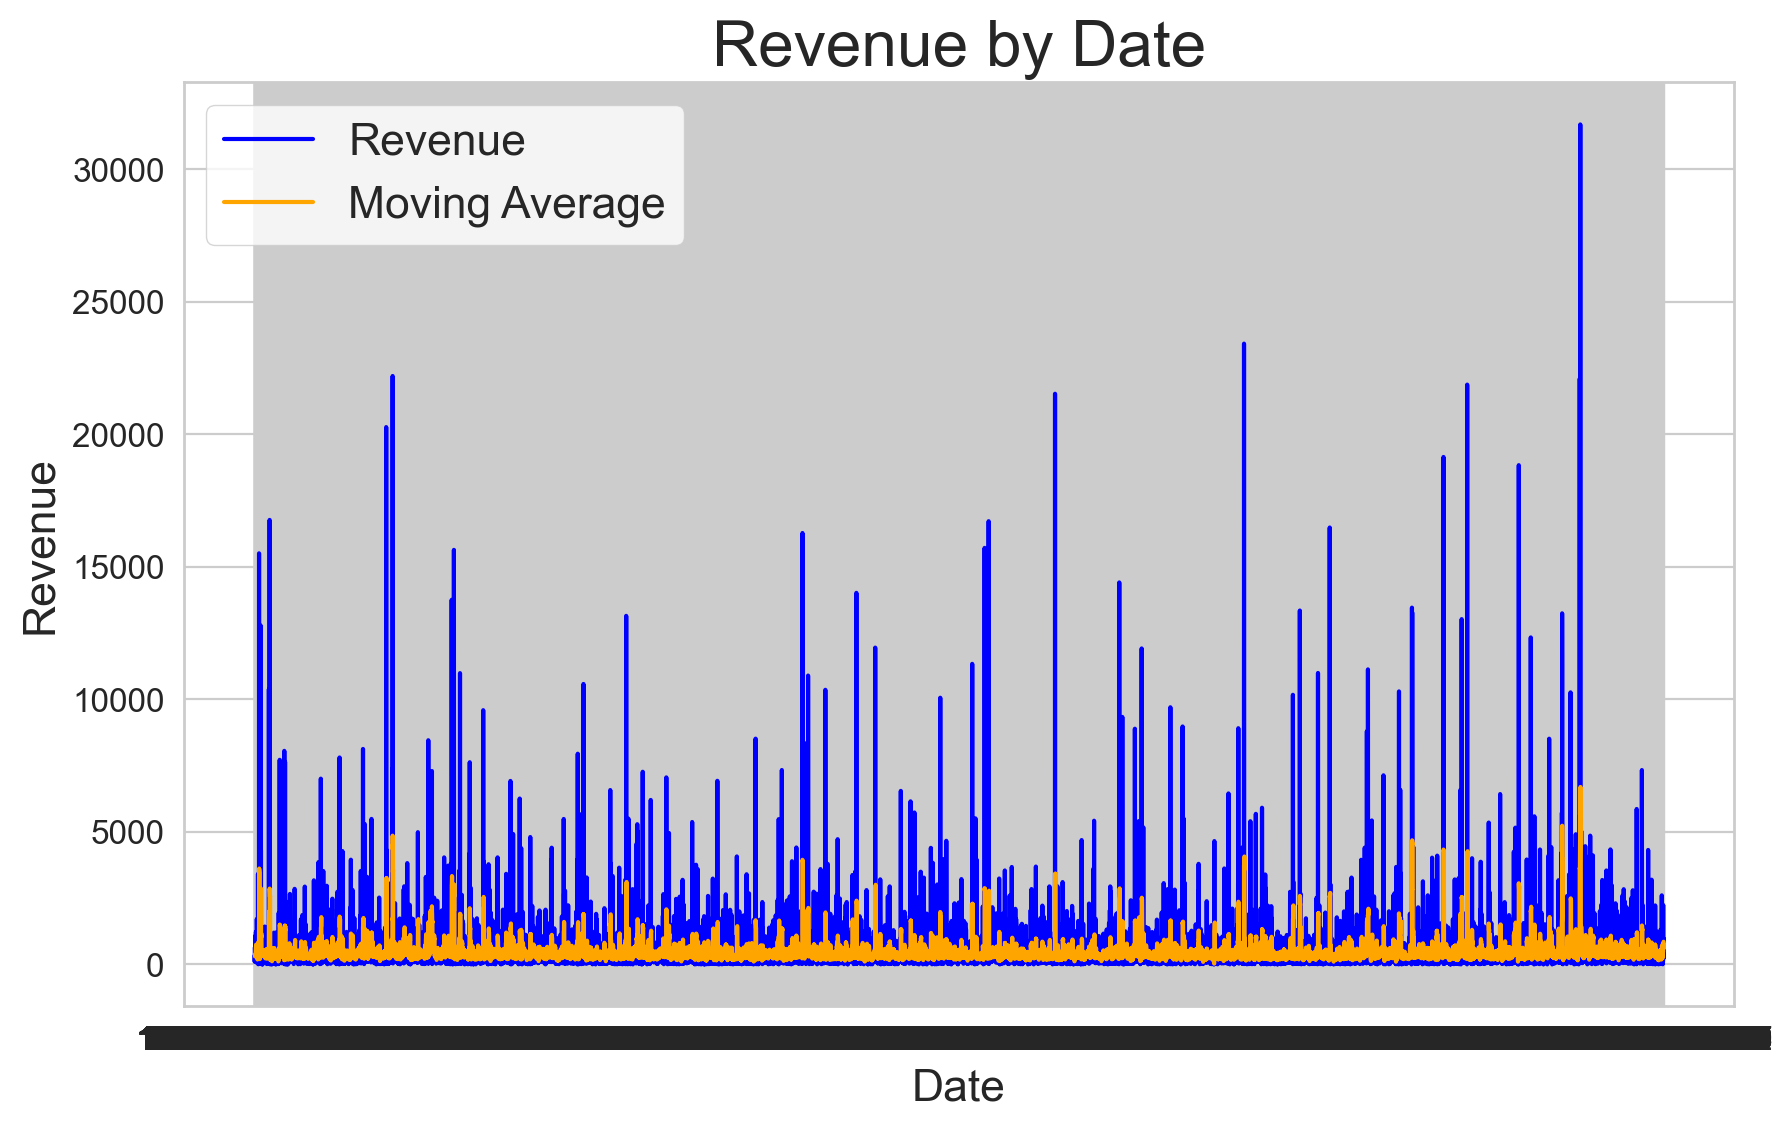

In [ ]:
data_by_date.tail()

# Calculate a moving average on the Revenue
data_by_date['moving_average'] = data_by_date['Revenue'].rolling(window=7).mean()

# Plot the Revenue
# Set up the plot
plt.figure(figsize=(10, 6))
plt.plot(data_by_date['InvoiceDate'], data_by_date['Revenue'], label='Revenue', color='blue')
plt.plot(data_by_date['InvoiceDate'], data_by_date['moving_average'], label='Moving Average', color='orange')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue by Date')
plt.legend(loc='upper left')

# Display the plot
plt.show();

In [ ]:
average_clv = customer_data['Total_Customer_Revenue'].median()

estimated_customer_base = customer_data.shape[0]

total_revenue_forecast = average_clv * estimated_customer_base

# Print the forecasted revenue
print("Total Revenue Forecast for the Next Year: $", total_revenue_forecast)

# THS IS DEFINITELY WRONG!

Total Revenue Forecast for the Next Year: $ 1568335.6799999997


Trying something new...

In [ ]:
data.head()

,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,quarter,Continent,TotalInvoices,item_color,item_material,Revenue,first_purchase,last_purchase,Total_Customer_Revenue,Customer_Lifetime,Customer_Lifetime_Value,Item_Category,Accessories,Home Decor,Kitchenware,Lunchware,Party/Holiday
0,536365,Hanging Heart T-Light Holder,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,2010,12,4,Europe,34,White,None,15.30,2010-12-01 10:51:00,2010-12-02 09:44:00,5391.21,0.031326,inf,Home Decor,0.0,2457.4,394.32,0.0,0.0
1,536365,Lantern,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010,12,4,Europe,34,White,Metal,20.34,2010-12-01 10:51:00,2010-12-02 09:44:00,5391.21,0.031326,inf,None,0.0,2457.4,394.32,0.0,0.0
2,536365,Cupid Hearts Coat Hanger,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,2010,12,4,Europe,34,Cream,None,22.00,2010-12-01 10:51:00,2010-12-02 09:44:00,5391.21,0.031326,inf,None,0.0,2457.4,394.32,0.0,0.0
3,536365,Knitted Union Flag Hot Water Bottle,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010,12,4,Europe,34,None,None,20.34,2010-12-01 10:51:00,2010-12-02 09:44:00,5391.21,0.031326,inf,Home Decor,0.0,2457.4,394.32,0.0,0.0
4,536365,Woolly Hottie Heart.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,2010,12,4,Europe,34,Red,None,20.34,2010-12-01 10:51:00,2010-12-02 09:44:00,5391.21,0.031326,inf,None,0.0,2457.4,394.32,0.0,0.0


https://community.tableau.com/s/question/0D54T00000C6BHcSAN/cohort-charts

In [ ]:
customer_data.head()

,CustomerID,Country,Continent,TotalInvoices,first_purchase,last_purchase,Total_Customer_Revenue,Customer_Lifetime,Customer_Lifetime_Value,Accessories_Revenue,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Other_Revenue,cohort_month,is_uk,Log_Total_Customer_Revenue,frequency,recency,T,monetary_value,expected_purchases_in_six_months,6_months_clv,Segment
0,12583.0,France,Europe,15,2011-01-07 12:07:00,2011-09-30 12:58:00,6705.38,8.740563,25.208195,686.10,1854.98,454.65,340.2,820.30,2549.15,2011-01,Non-UK,8.810665,14.0,371.0,373.0,430.658571,6.254124,2637.218769,Champions
1,13748.0,United Kingdom,Europe,5,2010-12-01 09:00:00,2011-09-05 09:45:00,948.25,9.134684,3.410971,15.00,32.70,27.60,0.0,562.31,310.64,2010-12,UK,6.854618,3.0,278.0,373.0,248.083333,2.129073,545.580959,Hibernating
2,15291.0,United Kingdom,Europe,14,2011-01-12 16:14:00,2011-09-06 09:15:00,4623.30,7.777048,19.590254,15.00,2158.21,36.50,0.0,236.82,2176.77,2011-01,UK,8.438864,13.0,348.0,373.0,324.231538,5.879119,1868.811922,Loyal Customers
3,14688.0,United Kingdom,Europe,21,2011-01-18 09:44:00,2011-09-08 12:16:00,5579.10,7.658656,23.944635,69.41,2361.53,280.00,154.5,463.07,2250.59,2011-01,UK,8.626783,19.0,366.0,373.0,277.730526,8.129147,2203.235697,Champions
4,15311.0,United Kingdom,Europe,91,2011-01-10 16:24:00,2011-09-06 14:38:00,60632.75,7.849899,254.759454,1253.27,32190.61,2461.10,4851.8,2609.87,17266.10,2011-01,UK,11.012590,89.0,373.0,373.0,676.390000,34.379466,22508.348716,Champions


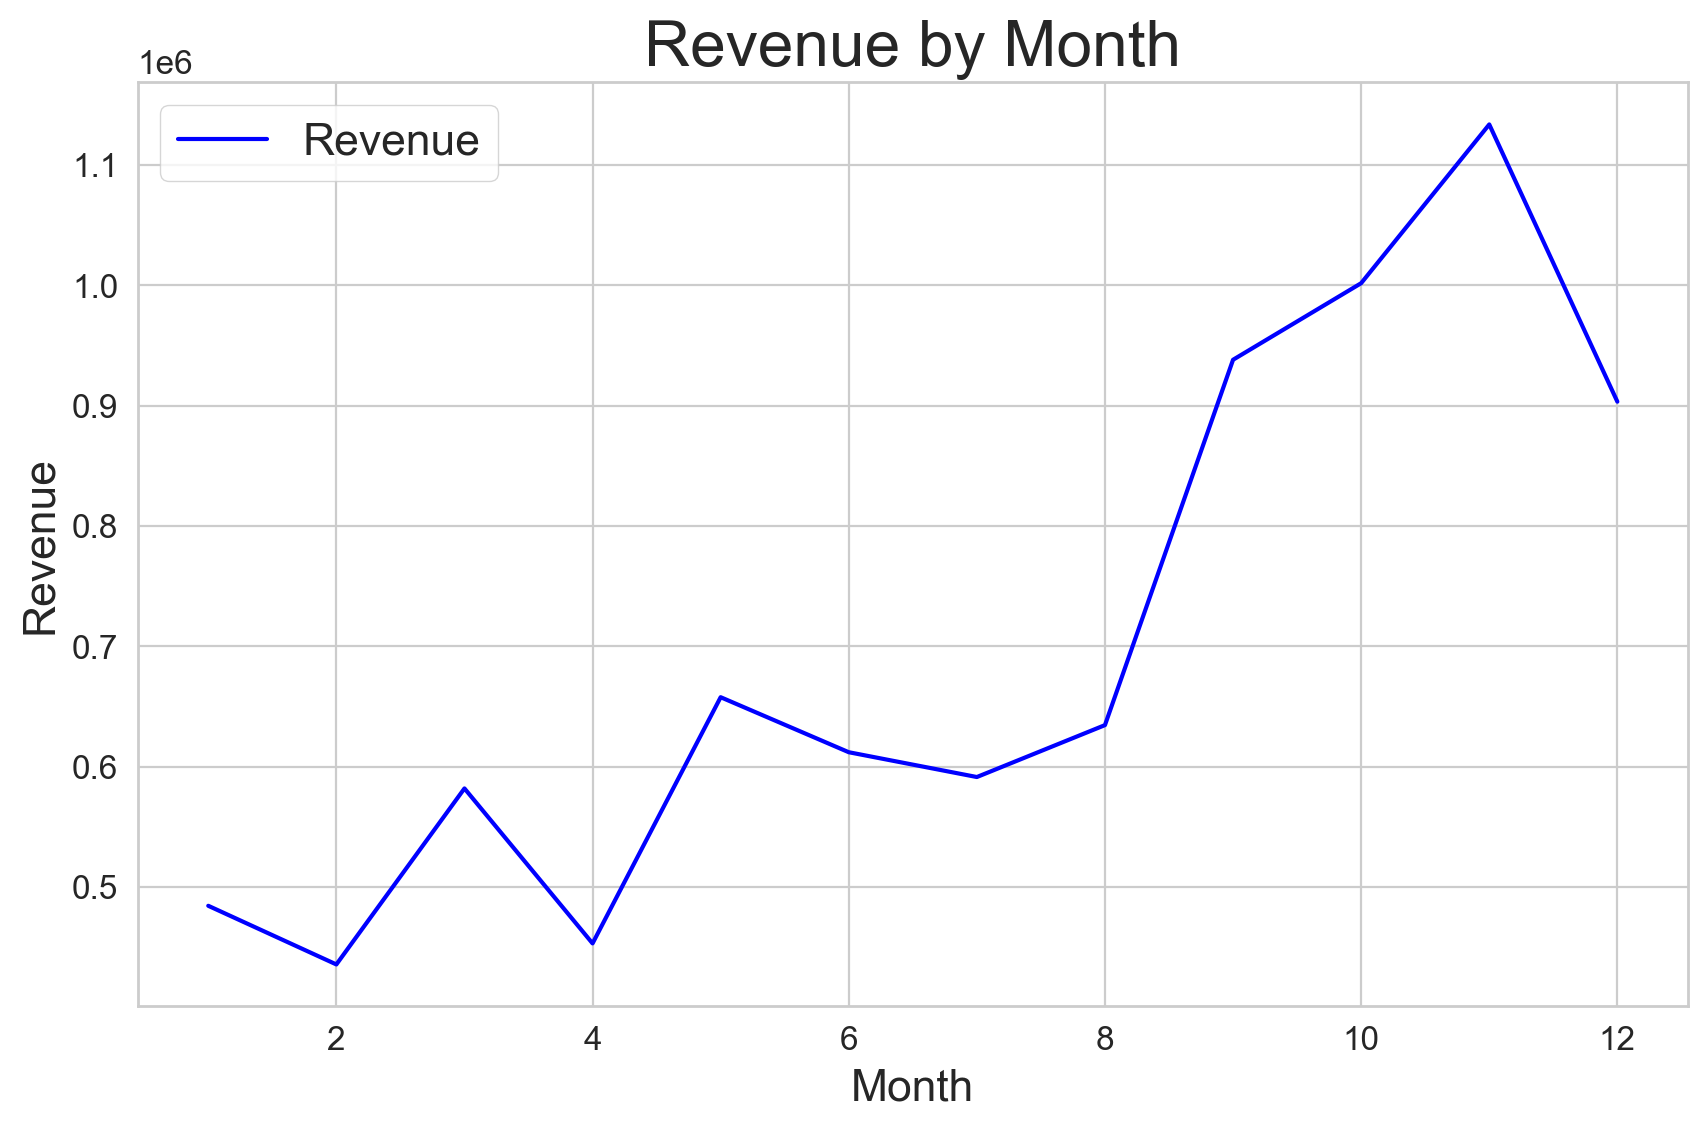

In [ ]:
# Group By Invoice Date and Sum the Revenue
data_by_date_month = data.groupby('month')['Revenue'].sum().reset_index()

# Plot data_by_date_month
plt.figure(figsize=(10, 6))
plt.plot(data_by_date_month['month'], data_by_date_month['Revenue'], label='Revenue', color='blue')

# Customize the plot
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Revenue by Month')
plt.legend(loc='upper left')

# Display the plot
plt.show();

In [ ]:
daily_purchasers = data.groupby(['new_date'])['CustomerID'].nunique().sort_values(ascending=False)
daily_purchasers.head(10).sort_values(ascending=False).plot()

KeyError: 'new_date'

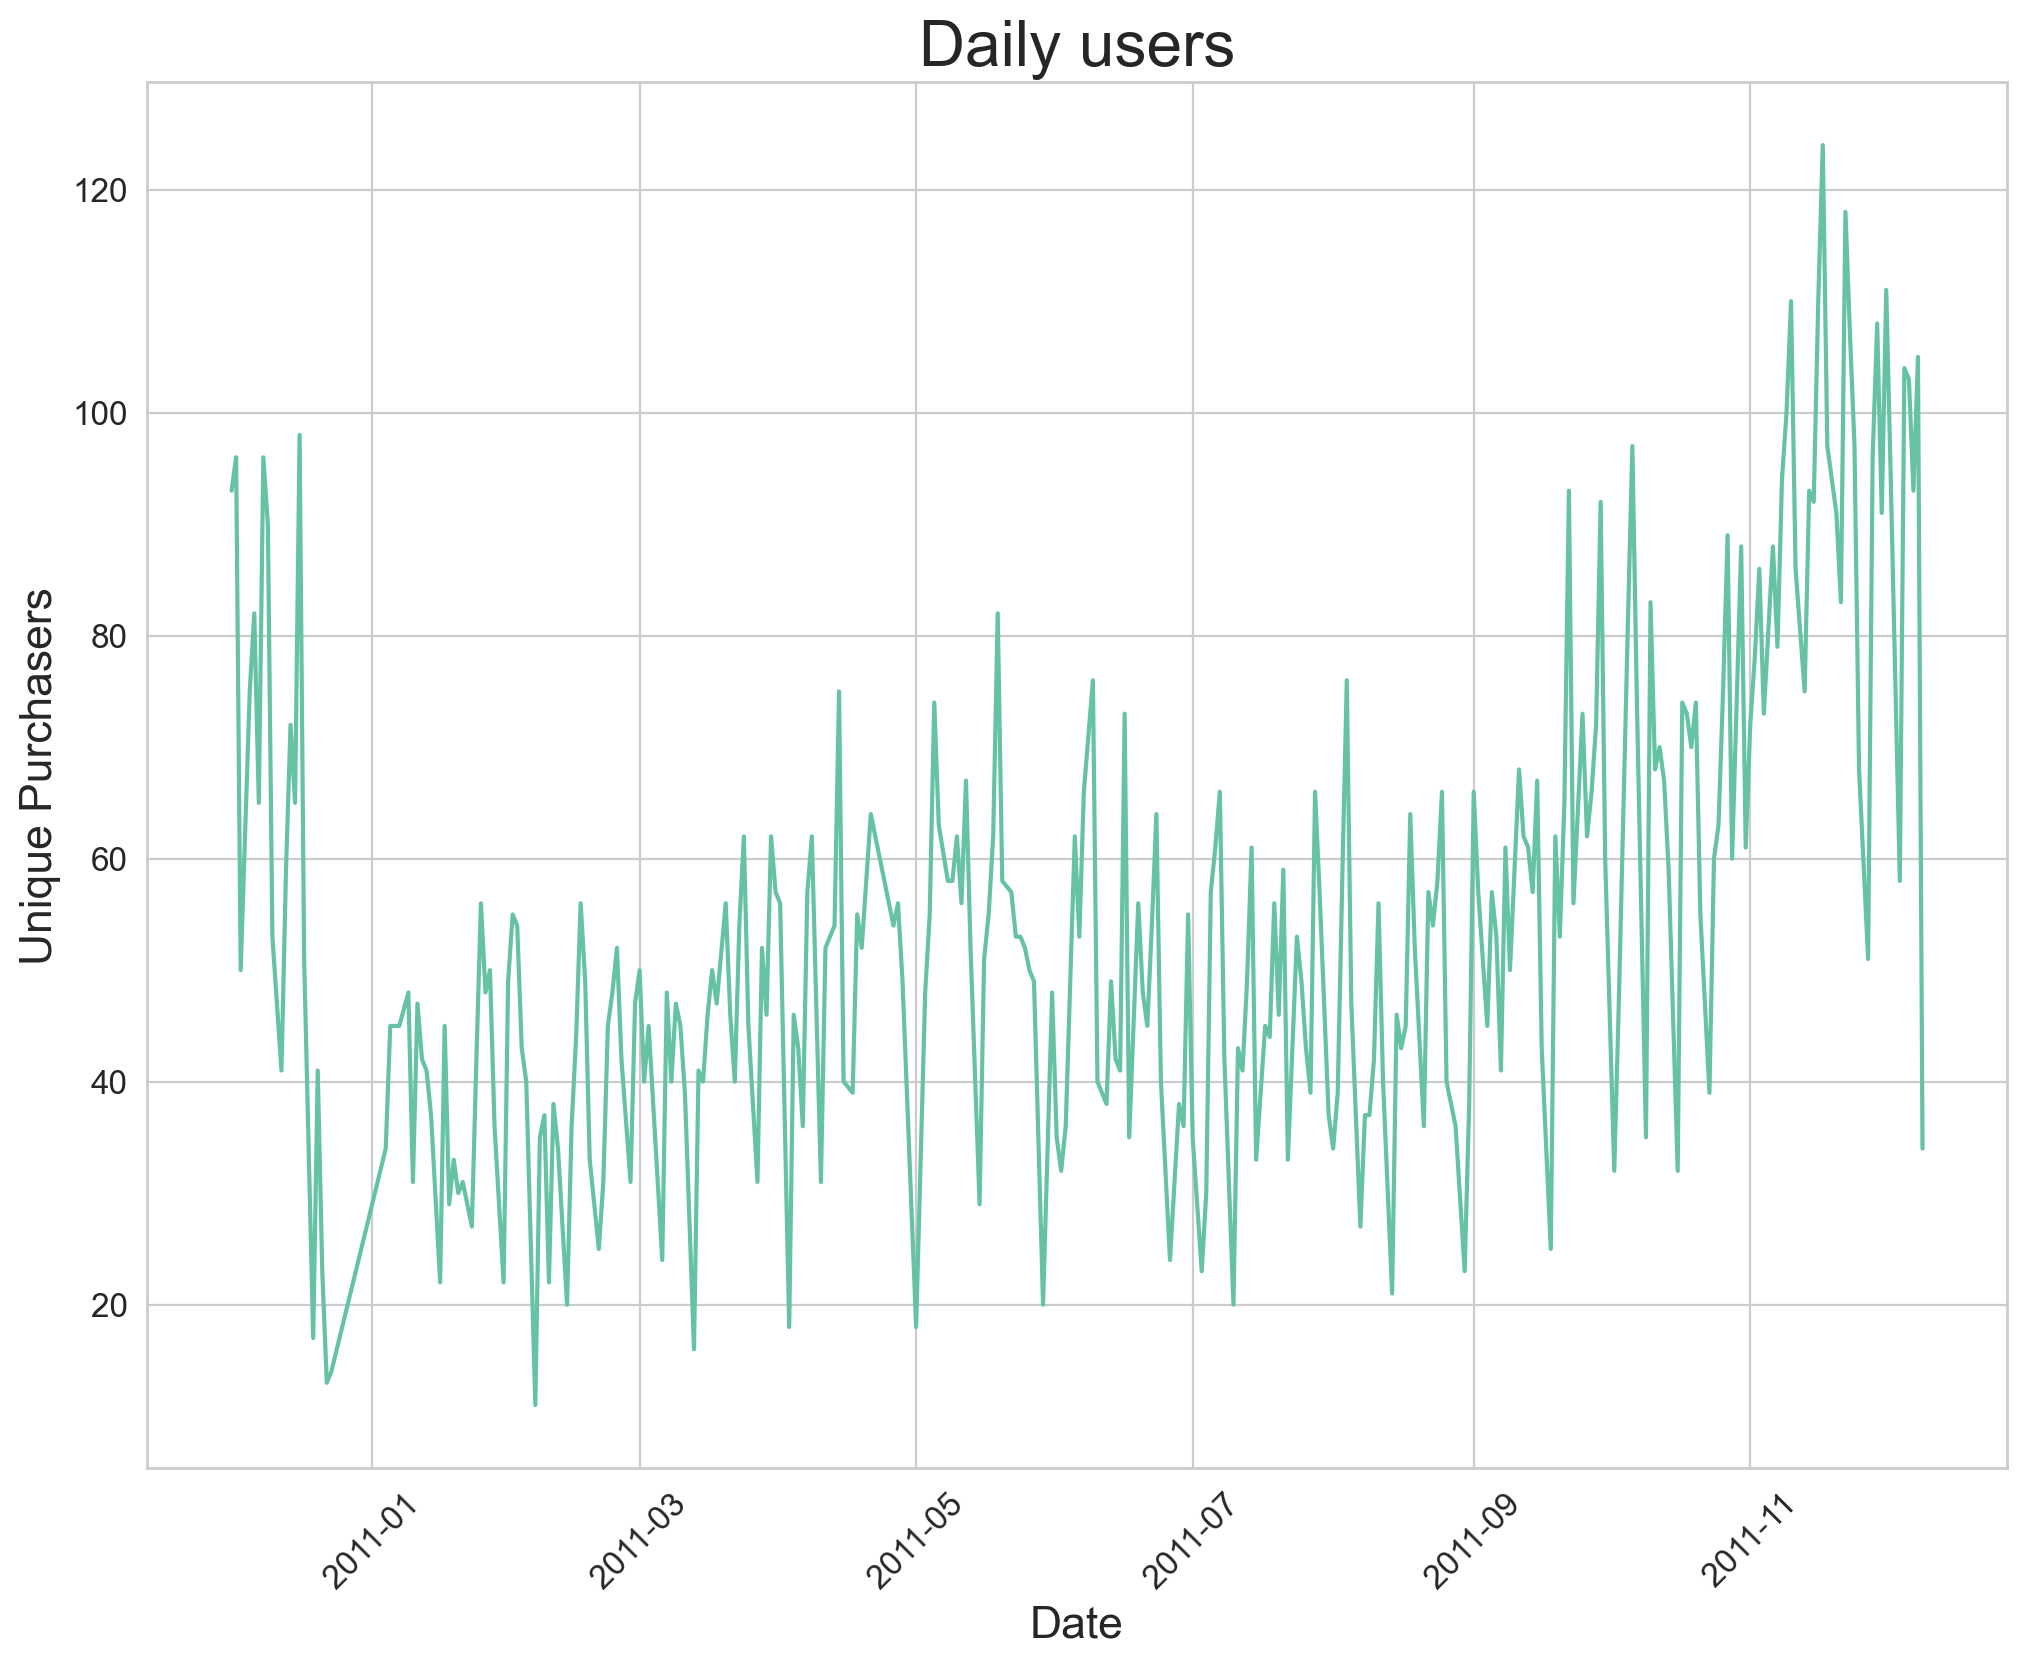

In [ ]:
import matplotlib.pyplot as plt

# Plot daily_subscribers
daily_purchasers.plot()

# Include a title and y-axis label
plt.title('Daily users')
plt.ylabel('Unique Purchasers')
plt.xlabel('Date')

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation = 45)

# Display the plot
plt.show();

In [ ]:
customer_data.head()

,CustomerID,Country,Continent,TotalInvoices,first_purchase,last_purchase,Total_Customer_Revenue,Customer_Lifetime,Customer_Lifetime_Value,Accessories_Revenue,Home_Decor_Revenue,Kitchenware_Revenue,Lunchware_Revenue,Party/Holiday_Revenue,Other_Revenue,cohort_month,is_uk,Log_Total_Customer_Revenue
297,13047.0,United Kingdom,Europe,9,2010-12-01,2011-10-14,3232.59,10.414998,10.197445,95.40,522.89,713.36,0.0,572.53,1328.41,2010-12,UK,8.081039
468,12583.0,France,Europe,15,2010-12-01,2011-12-07,6705.38,12.189162,18.073801,686.10,1854.98,454.65,340.2,820.30,2549.15,2010-12,Non-UK,8.810665
700,13748.0,United Kingdom,Europe,5,2010-12-01,2011-09-05,948.25,9.133658,3.410971,15.00,32.70,27.60,0.0,562.31,310.64,2010-12,UK,6.854618
728,15291.0,United Kingdom,Europe,14,2010-12-01,2011-11-14,4623.30,11.433500,13.285345,15.00,2158.21,36.50,0.0,236.82,2176.77,2010-12,UK,8.438864
830,14688.0,United Kingdom,Europe,21,2010-12-01,2011-12-02,5579.10,12.024888,15.243443,69.41,2361.53,280.00,154.5,463.07,2250.59,2010-12,UK,8.626783


Exporting Excel File

In [ ]:
# # Export Excel File with two sheets
# with pd.ExcelWriter('rex_london_processed_data_v1.xlsx') as writer:
#     customer_data.to_excel(writer, sheet_name='customer_data', index=False)
#     data.to_excel(writer, sheet_name='transaction_data', index=False)

### Create The RFM Table

- After we sample the data, we will make the data easier to conduct an analysis.
    - To segmenting customer, there are some metrics that we can use, such as..
        - when the customer buy the product for last time,
        - how frequent the customer buy the product, and
        - how much the customer pays for the product.
    - We will call this segmentation as RFM segmentation.
- To make the RFM table, we can create these columns, such as Recency, Frequency, and MonetaryValue column.
    - To get the number of days for recency column, we can subtract the snapshot date with the date where the transaction occurred.
    - To create the frequency column, we can count how much transactions by each customer.
    - Lastly, to create the monetary value column, we can sum all transactions for each customer.

In [ ]:
# Create TotalSum colummn
data["TotalSum"] = data["Quantity"] * data["UnitPrice"]

# Create date variable that records recency
import datetime
snapshot_date = max(data['new_date']) + datetime.timedelta(days=1)

# Aggregate data by each customer
customers = data.groupby(['CustomerID']).agg({
    'new_date': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
    
# Rename columns
customers.rename(columns = {'new_date': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'MonetaryValue'}, inplace=True)

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4254 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        4254 non-null   int64  
 1   Frequency      4254 non-null   int64  
 2   MonetaryValue  4254 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 132.9 KB


In [ ]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4249,8.979197,2.373240,5.622064
4250,7.986679,1.996214,3.998333
4251,2.453308,2.567326,5.454165
4252,1.546356,7.176775,12.671908
4253,5.104295,4.493203,11.937078


In [ ]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

StandardScaler()

[ 0.  0. -0.]
[1. 1. 1.]


### Modelling

KMeans(n_clusters=1, random_state=42)

KMeans(n_clusters=2, random_state=42)

KMeans(n_clusters=3, random_state=42)

KMeans(n_clusters=4, random_state=42)

KMeans(n_clusters=5, random_state=42)

KMeans(n_clusters=6, random_state=42)

KMeans(n_clusters=7, random_state=42)

KMeans(random_state=42)

KMeans(n_clusters=9, random_state=42)

KMeans(n_clusters=10, random_state=42)

Text(0.5, 1.0, 'The Elbow Method')

Text(0.5, 0, 'k')

Text(0, 0.5, 'SSE')

<Axes: title={'center': 'The Elbow Method'}, xlabel='k', ylabel='SSE'>

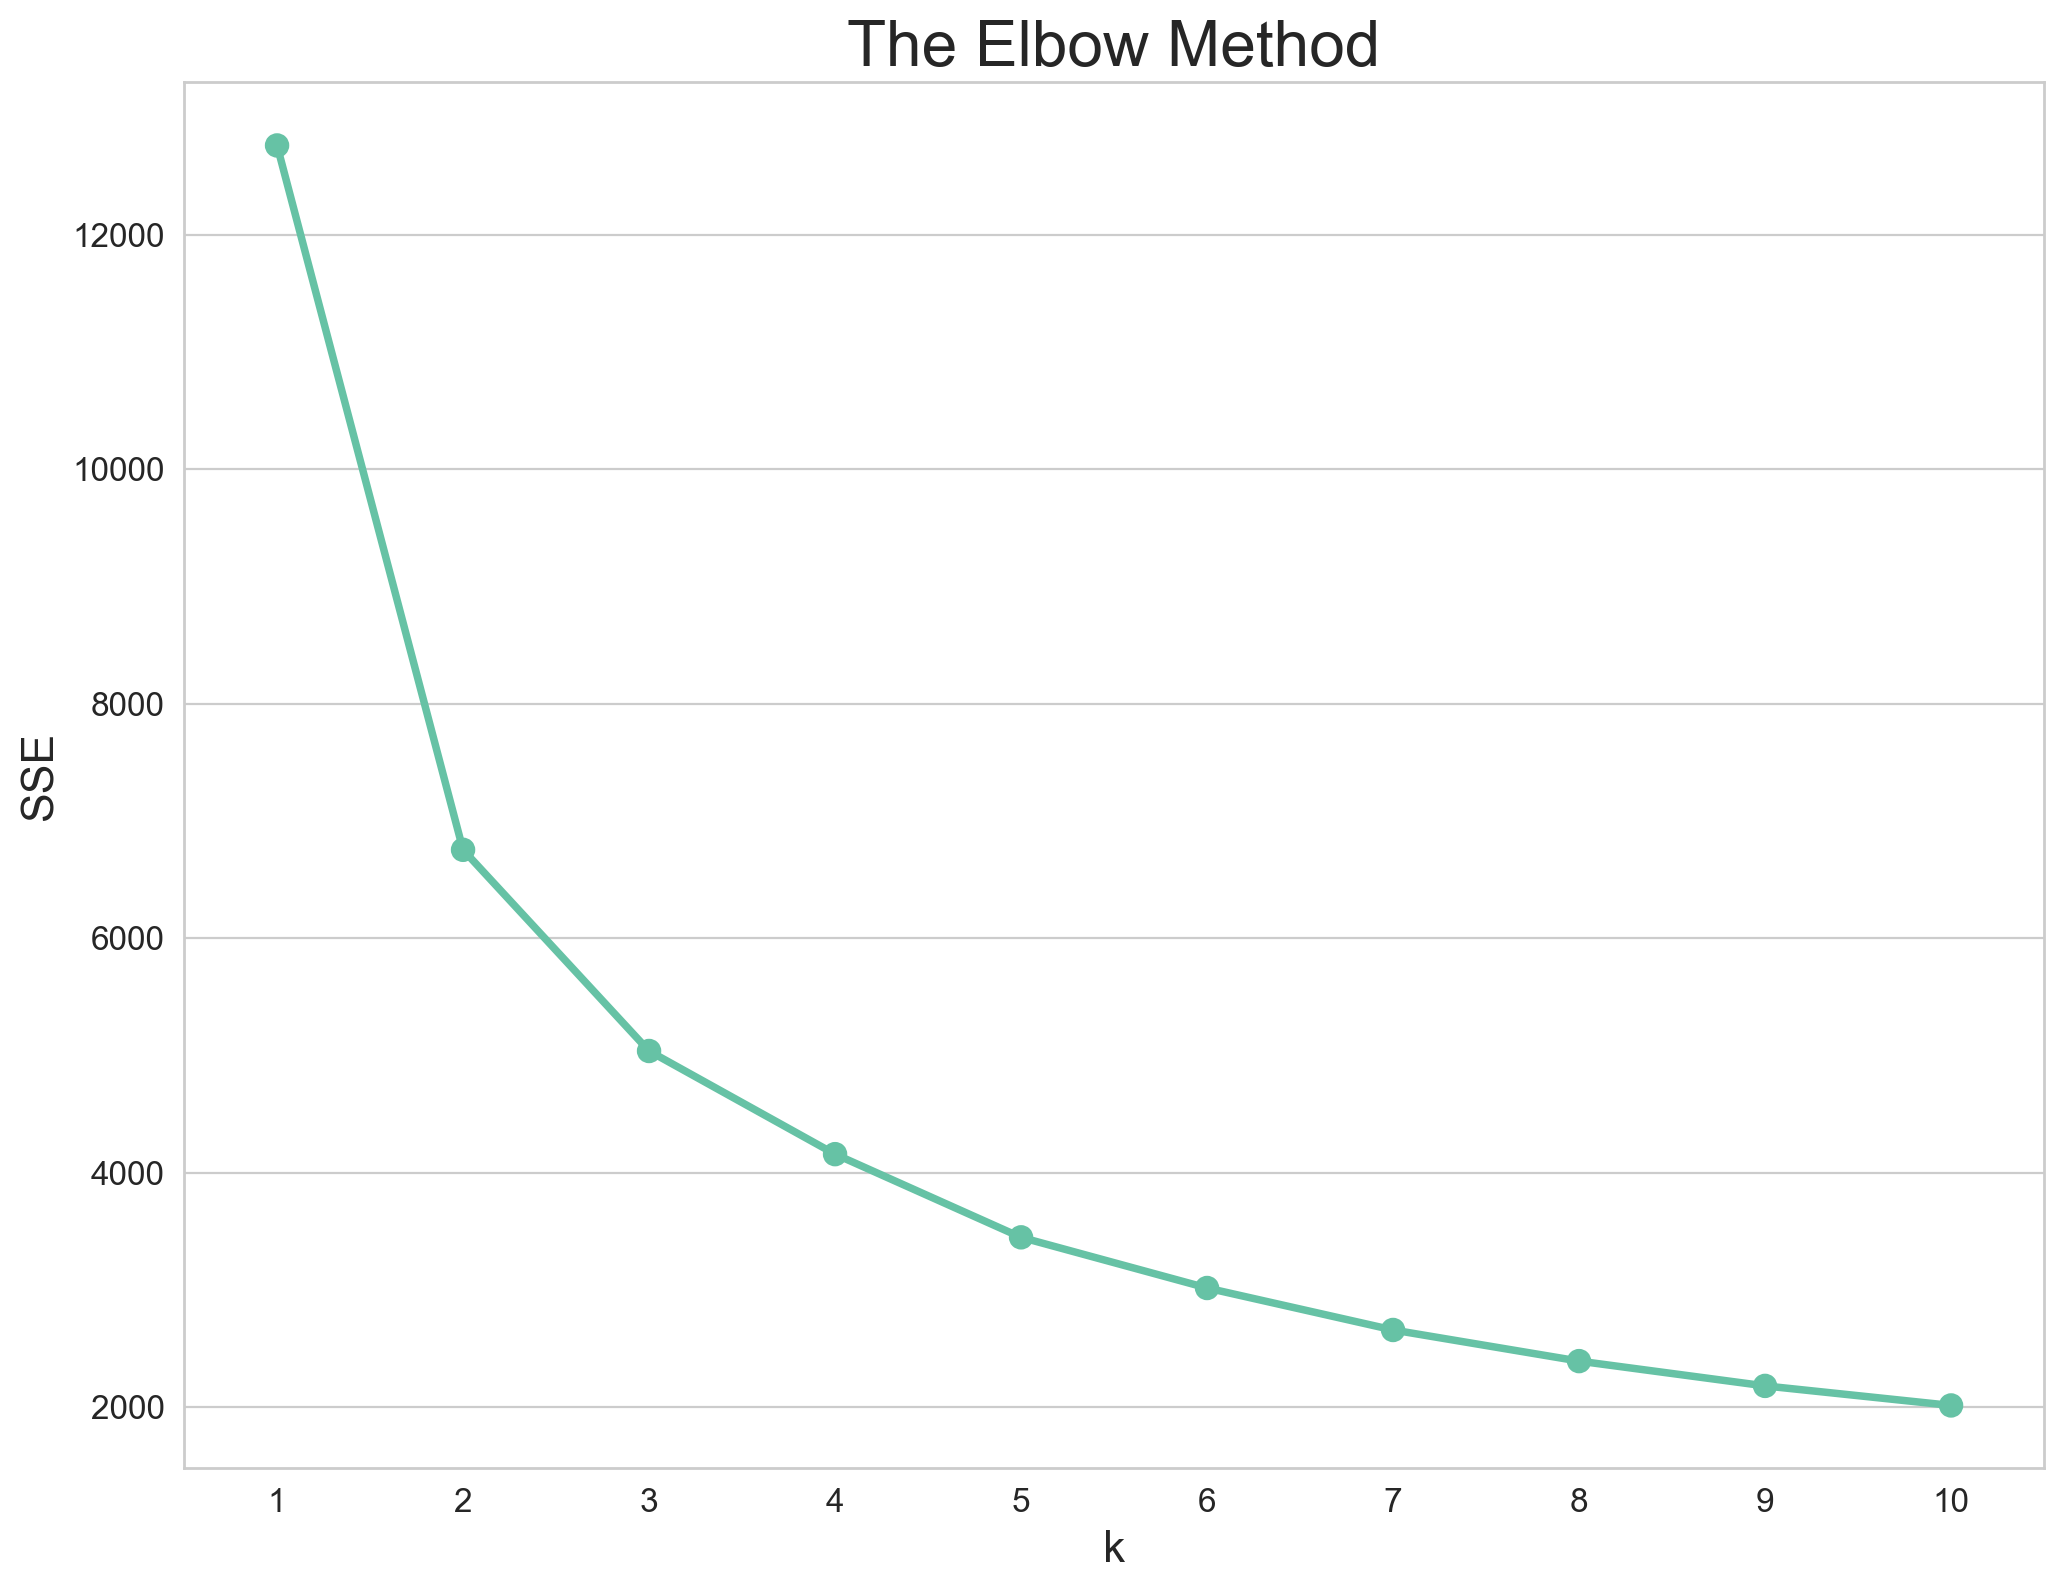

In [ ]:
import seaborn as sns
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [ ]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

KMeans(n_clusters=3, random_state=42)

(4254,)

In [ ]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         43.47     66.13        926.19  1856
1        180.92     19.81        322.17  1627
2         20.38    306.16       5324.65   771

In [ ]:
# # Create the dataframe
# df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
# df_normalized['ID'] = customers.index
# df_normalized['Cluster'] = model.labels_
# # Melt The Data
# df_nor_melt = pd.melt(df_normalized.reset_index(),
#                       id_vars=['ID', 'Cluster'],
#                       value_vars=['Recency','Frequency','MonetaryValue'],
#                       var_name='Attribute',
#                       value_name='Value')
# df_nor_melt.head()
# # Visualize it
# sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)